## Process Data from Sept Cruise (Sept 4-9) for Analysis

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
from matplotlib.patches import Ellipse


#### Pull in CDOM data and ship TSG/GPS data

CDOM data here is from the fCDOM recorded using a DataQ

In [2]:
path = 'data/sept_cruise/wscd859/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=1)
    li.append(df_tmp)
cdom_df = pd.concat(li, axis=0, ignore_index=True)

cdom_df['utc_dt'] = pd.to_datetime(cdom_df['yyyy/mm/dd HH:MM:SS.fff'])

cdom_df = cdom_df.set_index('utc_dt')

In [3]:
# need to remove duplicates to match up to tsg data
cdom_df = cdom_df.loc[~cdom_df.index.duplicated(keep='first')]
cdom_df = cdom_df.sort_index(ascending=True)

This navigation and TSG data is from the R/V Shearwater's nav system and the Seabird TSG on the flow through

In [4]:
nav_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/Navigation/SW-GGA_20210904-222337.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [5]:
date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')
tsg_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/TSG/TSG-_20210904-222337.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

lats = []
lons = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
tsg_df['lat'] = lats
tsg_df['lon'] = lons

In [6]:
tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')

In [7]:
tsg_df = tsg_df.sort_index(ascending=True)

In [8]:
# tsg_df = tsg_df.drop('DateTime', 1)

In [9]:
# tsg_df = tsg_df.drop('Unknown', 1)
# tsg_df.to_csv('sept_4_9_ship_data_geolocated.csv')

In [10]:
# tsg_df = pd.read_csv('sept_4_9_ship_data_geolocated.csv')

<AxesSubplot:>

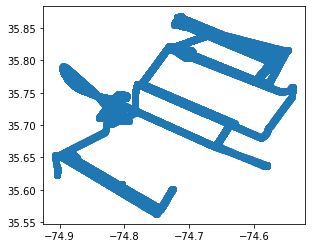

In [11]:
import geopandas as gpd

tsg_gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(tsg_df.lon, tsg_df.lat))
tsg_gdf.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00'].plot()

### Pull in FCM Data

In [12]:
fcm_df = pd.read_csv('data/sept_cruise/SW_fcm_full_bac_chla.csv')

In [13]:
date_time_strs = fcm_df['Date'] + ' ' + fcm_df['Time (UTC)']
fcm_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]

In [14]:
fcm_df['utc_dt'] = fcm_df['datetime']
fcm_df  = fcm_df.set_index('utc_dt')

In [15]:
fcm_df = fcm_df.sort_index(ascending=True)

In [16]:
fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan

<ipython-input-16-a5003a0a14a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan


In [17]:
fcm_df['Bacteria_A'][fcm_df['Bacteria_A']==-999]=np.nan
fcm_df['Bacteria_B'][fcm_df['Bacteria_B']==-999]=np.nan

<ipython-input-17-21214e81176b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Bacteria_A'][fcm_df['Bacteria_A']==-999]=np.nan
<ipython-input-17-21214e81176b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Bacteria_B'][fcm_df['Bacteria_B']==-999]=np.nan


In [18]:
# lats = []
# lons = []
# for i in range(len(fcm_df)):
#     row = df.iloc[df.index.get_loc(pd.to_datetime(fcm_df.iloc[i].datetime), method='nearest')]
#     lats.append(row.lat)
#     lons.append(row.lon)
# fcm_df['lat'] = lats
# fcm_df['lon'] = lons

In [19]:
fcm_df.columns

Index(['Sample#', 'Time (UTC)', 'Date', 'Syn/mL', 'SynA', 'SynB', 'Syn_Avg',
       'Peuks/mL', 'PeuksA', 'PeaksB', 'Peuks_Avg', 'PicoCyano/mL',
       'PicoCyanoA', 'PicoCyanoB', 'PicoCyano_Avg', 'Bacteria_A', 'Bacteria_B',
       'Chla A', 'Chla B', 'Chla_Avg', 'datetime'],
      dtype='object')

## Pull in NCP Data

In [20]:
import scipy.io
fn = 'data/sept_cruise/SW_data.mat'
mat = scipy.io.loadmat(fn)
for item in list(mat.keys()):
    if item not in ['__header__', '__version__', '__globals__']:
        print(item)
        df_ncp = pd.DataFrame(data=mat[item], columns=['time', 'MLD', 'NCP mmol C m-2 d-1', 'NCP (mmol C m-3 d-1)'])
        
df_ncp['dt'] = pd.to_datetime(df_ncp.time-719529, unit='D')
df_ncp = df_ncp.set_index('dt')
df_ncp = df_ncp.sort_index(ascending=True)
df_ncp['datetime'] = pd.to_datetime(df_ncp.time-719529, unit='D')

SW_data


In [21]:
df_ncp.head()

time  MLD  NCP mmol C m-2 d-1  \
dt                                                                      
2021-09-04 22:58:00.000000512  738403.956944  NaN                 NaN   
2021-09-04 23:00:00.000003328  738403.958333  NaN                 NaN   
2021-09-04 23:02:00.000006144  738403.959722  NaN                 NaN   
2021-09-04 23:03:59.999999232  738403.961111  NaN                 NaN   
2021-09-04 23:06:00.000012032  738403.962500  NaN                 NaN   

                               NCP (mmol C m-3 d-1)  \
dt                                                    
2021-09-04 22:58:00.000000512                   NaN   
2021-09-04 23:00:00.000003328                   NaN   
2021-09-04 23:02:00.000006144                   NaN   
2021-09-04 23:03:59.999999232                   NaN   
2021-09-04 23:06:00.000012032                   NaN   

                                                   datetime  
dt                                                           
2021-09-04 22:58:00.000000512 2021-09-04 22:58:00.000000512  
2021-09-04 23:00:00.000003328 2021-09-04 23:00:00.000003328  
2021-09-04 23:02:00.000006144 2021-09-04 23:02:00.000006144  
2021-09-04 23:03:59.999999232 2021-09-04 23:03:59.999999232  
2021-09-04 23:06:00.000012032 2021-09-04 23:06:00.000012032

#### Pull in Nutrient Data

In [22]:
nuts_df = pd.read_csv('data/sept_cruise/20220131_nutstoUCSD_data.csv')

date_time_strs = nuts_df['Date'] + ' ' + nuts_df['Time (UTC)']
nuts_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]
nuts_df['utc_dt'] = nuts_df['datetime']
nuts_df  = nuts_df.set_index('utc_dt')
nuts_df = nuts_df.sort_index(ascending=True)
nuts_df.head()

Station  NO3a  PO4a  SILa  NO2a  NH4a  NO3b  PO4b  SILb  \
utc_dt                                                                         
2021-09-05 12:07:00        1  0.11  0.06   0.8  0.00  0.25  0.10  0.08   1.1   
2021-09-05 13:02:00        2  0.26  0.06   1.5  0.01  0.35  0.23  0.08   2.3   
2021-09-05 13:48:00        3  0.27  0.06   2.3  0.01  0.25  0.32  0.08   2.6   
2021-09-05 14:08:00        4  0.15  0.06   2.3  0.01  0.15  0.18  0.06   1.5   
2021-09-05 14:24:00        6  0.06  0.04   1.0  0.01  0.16  0.10  0.07   1.0   

                     NO2b  NH4b Time (UTC)      Date            datetime  
utc_dt                                                                    
2021-09-05 12:07:00  0.00  0.18      12:07  9/5/2021 2021-09-05 12:07:00  
2021-09-05 13:02:00  0.01  0.23      13:02  9/5/2021 2021-09-05 13:02:00  
2021-09-05 13:48:00  0.01  0.22      13:48  9/5/2021 2021-09-05 13:48:00  
2021-09-05 14:08:00  0.01  0.30      14:08  9/5/2021 2021-09-05 14:08:00  
2021-09-05 14:24:00  0.01  0.21      14:24  9/5/2021 2021-09-05 14:24:00

In [23]:
nuts_df.columns

Index(['Station', 'NO3a', 'PO4a', 'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b',
       'SILb', 'NO2b', 'NH4b', 'Time (UTC)', 'Date', 'datetime'],
      dtype='object')

### Match up all the data in time

In [24]:
SynAs = []
PeuksAs = []
PicoCyanoAs = [] 
SynBs = []
PeuksBs = []
PicoCyanoBs = [] 
BacteriaAs = []
BacteriaBs = []
ChlaAvgs = []
ChlaAs = []
ChlaBs = []

NO3as = []
PO4as = []
SILas = []
NO2as = []
NH4as = []
NO3bs = []
PO4bs = []
SILbs = []
NO2bs = []
NH4bs = []

cdomVolts = []

ncp_area = []
ncp_vol = []
mld_list = []

for i in range(len(tsg_df)):
    try:
        row = fcm_df.iloc[fcm_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        SynAs.append(row.SynA)
        PeuksAs.append(row.PeuksA) 
        PicoCyanoAs.append(row.PicoCyanoA)
        SynBs.append(row.SynB)
        PeuksBs.append(row.PeaksB) 
        PicoCyanoBs.append(row.PicoCyanoB)
        BacteriaAs.append(row.Bacteria_A)
        BacteriaBs.append(row.Bacteria_B)
        ChlaAvgs.append(row.Chla_Avg)
        ChlaAs.append(row['Chla A'])
        ChlaBs.append(row['Chla B'])
    except KeyError:
        SynAs.append(np.nan)
        PeuksAs.append(np.nan) 
        PicoCyanoAs.append(np.nan)
        SynBs.append(np.nan)
        PeuksBs.append(np.nan) 
        PicoCyanoBs.append(np.nan)
        BacteriaAs.append(np.nan)
        BacteriaBs.append(np.nan)
        ChlaAvgs.append(np.nan)
        ChlaAs.append(np.nan)
        ChlaBs.append(np.nan)
        
    try:
        row = cdom_df.iloc[cdom_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        cdomVolts.append(row[' V'])

    except KeyError:
        cdomVolts.append(np.nan)
        
    try:
        row = df_ncp.iloc[df_ncp.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        ncp_area.append(row['NCP mmol C m-2 d-1'])
        ncp_vol.append(row['NCP (mmol C m-3 d-1)'])
        mld_list.append(row['MLD'])

    except KeyError:
        ncp_area.append(np.nan)
        ncp_vol.append(np.nan)
        mld_list.append(np.nan)
        
    try:
        row = nuts_df.iloc[nuts_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        
        NO3as.append(row.NO3a)
        PO4as.append(row.PO4a)
        SILas.append(row.SILa) 
        NO2as.append(row.NO2a)
        NH4as.append(row.NH4a)
        NO3bs.append(row.NO3b)
        PO4bs.append(row.PO4b)
        SILbs.append(row.SILb)
        NO2bs.append(row.NO2b)
        NH4bs.append(row.NH4b)

    except KeyError:
        NO3as.append(np.nan)
        PO4as.append(np.nan)
        SILas.append(np.nan) 
        NO2as.append(np.nan)
        NH4as.append(np.nan)
        NO3bs.append(np.nan)
        PO4bs.append(np.nan)
        SILbs.append(np.nan)
        NO2bs.append(np.nan)
        NH4bs.append(np.nan)   
    
    if i % 2000 == 0:
        print(i)
        
tsg_df['SynA'] = SynAs
tsg_df['PeuksA'] = PeuksAs
tsg_df['PicoCyanoA'] = PicoCyanoAs
tsg_df['SynB'] = SynBs
tsg_df['PeuksB'] = PeuksBs
tsg_df['PicoCyanoB'] = PicoCyanoBs
tsg_df['BacteriaA'] = BacteriaAs
tsg_df['BacteriaB'] = BacteriaBs
tsg_df['ChlaAvg'] = ChlaAvgs
tsg_df['ChlaA'] = ChlaAs
tsg_df['ChlaB'] = ChlaBs
tsg_df['cdomVolts'] = cdomVolts
tsg_df['NCPm2'] = ncp_area
tsg_df['NCPm3'] = ncp_vol
tsg_df['MLD'] = mld_list

tsg_df['NO3a'] = NO3as
tsg_df['PO4a'] = PO4as
tsg_df['SILa'] = SILas
tsg_df['NO2a'] = NO2as
tsg_df['NH4a'] = NH4as
tsg_df['NO3b'] = NO3bs
tsg_df['PO4b'] = PO4bs
tsg_df['SILb'] = SILbs
tsg_df['NO2b'] = NO2bs
tsg_df['NH4b'] = NH4bs

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000


In [25]:
tsg_df['ChlaA'][tsg_df['ChlaA']==-999]=np.nan
tsg_df['ChlaB'][tsg_df['ChlaB']==-999]=np.nan

<ipython-input-25-5bfe795cc01c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsg_df['ChlaA'][tsg_df['ChlaA']==-999]=np.nan
<ipython-input-25-5bfe795cc01c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsg_df['ChlaB'][tsg_df['ChlaB']==-999]=np.nan


In [26]:
# count = 0
# for x,y in zip(np.unique(tsg_df.NCP, return_counts=True)[0], np.unique(tsg_df.NCP, return_counts=True)[1]):
#     if not np.isnan(x):
# #         print(y)
#         count += 1
# print(count)

### Pull in Optical Data

This data could be merged but already has S and T and CDOM integrated and thus probably doesn't need to be merged with everything else

In [27]:
optical_df = pd.read_csv('data/sept_cruise/optical_inline/linear_interp_210905-7_ACS_qc24.csv')
optical_df['datetime'] = pd.to_datetime(optical_df.dt)
optical_df['utc_dt'] = optical_df['datetime']
optical_df  = optical_df.set_index('utc_dt')
optical_df = optical_df.sort_index(ascending=True)

In [28]:
optical_df

dt      ap_1      ap_2  ap_3  ap_4  \
utc_dt                                                                     
2021-09-05 12:26:00  2021/09/05 12:26:00       NaN       NaN   NaN   NaN   
2021-09-05 12:28:00  2021/09/05 12:28:00       NaN       NaN   NaN   NaN   
2021-09-05 12:30:00  2021/09/05 12:30:00       NaN       NaN   NaN   NaN   
2021-09-05 12:32:00  2021/09/05 12:32:00       NaN       NaN   NaN   NaN   
2021-09-05 12:34:00  2021/09/05 12:34:00       NaN       NaN   NaN   NaN   
...                                  ...       ...       ...   ...   ...   
2021-09-07 22:40:00  2021/09/07 22:40:00       NaN       NaN   NaN   NaN   
2021-09-07 22:42:00  2021/09/07 22:42:00       NaN       NaN   NaN   NaN   
2021-09-07 22:44:00  2021/09/07 22:44:00       NaN       NaN   NaN   NaN   
2021-09-07 22:46:00  2021/09/07 22:46:00  0.001403 -0.001455   NaN   NaN   
2021-09-07 22:48:00  2021/09/07 22:48:00       NaN       NaN   NaN   NaN   

                         ap_5      ap_6      ap_7      ap_8      ap_9  ...  \
utc_dt                                                                 ...   
2021-09-05 12:26:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:28:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:32:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:34:00       NaN       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-09-07 22:40:00       NaN       NaN  0.006088  0.006661  0.006902  ...   
2021-09-07 22:42:00  0.006639  0.006288  0.002259  0.003187  0.005718  ...   
2021-09-07 22:44:00       NaN       NaN -0.001021  0.002577  0.001943  ...   
2021-09-07 22:46:00       NaN  0.001813 -0.000893 -0.000692  0.001962  ...   
2021-09-07 22:48:00       NaN       NaN -0.000395  0.000845  0.003551  ...   

                           poc  ap676_lh  chl_ap676lh     gamma      Halh  \
utc_dt                                                                      
2021-09-05 12:26:00  39.831026       NaN          NaN -0.088486  0.004560   
2021-09-05 12:28:00  61.172529       NaN          NaN -0.156479       NaN   
2021-09-05 12:30:00  75.542142       NaN          NaN -0.184516  0.013577   
2021-09-05 12:32:00  73.086927       NaN          NaN -0.174118  0.001662   
2021-09-05 12:34:00  70.776942       NaN          NaN -0.108719       NaN   
...                        ...       ...          ...       ...       ...   
2021-09-07 22:40:00  95.134367  0.002339     0.096870  0.727919  0.023875   
2021-09-07 22:42:00  84.818254  0.002055     0.082698  0.626612  0.022198   
2021-09-07 22:44:00  73.216876  0.002230     0.091363  0.503086  0.009459   
2021-09-07 22:46:00  77.373380  0.002198     0.089783  0.541927  0.022143   
2021-09-07 22:48:00  79.217519  0.002547     0.107454  0.548256  0.016619   

                     chl_Halh    HH_G50  HH_mphi  flag_bit            datetime  
utc_dt                                                                          
2021-09-05 12:26:00  0.218670  3.553904      NaN     76823 2021-09-05 12:26:00  
2021-09-05 12:28:00       NaN  4.649799      NaN     80919 2021-09-05 12:28:00  
2021-09-05 12:30:00  0.827758  5.441465      NaN     76823 2021-09-05 12:30:00  
2021-09-05 12:32:00  0.063842  3.383289      NaN     76823 2021-09-05 12:32:00  
2021-09-05 12:34:00       NaN  4.416846      NaN     80919 2021-09-05 12:34:00  
...                       ...       ...      ...       ...                 ...  
2021-09-07 22:40:00  1.648149  7.155318      NaN     40981 2021-09-07 22:40:00  
2021-09-07 22:42:00  1.507982  7.059592      NaN     40981 2021-09-07 22:42:00  
2021-09-07 22:44:00  0.532644  3.997832      NaN      8349 2021-09-07 22:44:00  
2021-09-07 22:46:00  1.503441  6.823800      NaN     41117 2021-09-07 22:46:00  
2021-09-07 22:48:00  1.059366  5.688504      NaN      8341 2

In [29]:
bb3_df = pd.read_csv('data/sept_cruise/optical_inline/linear_interp_210905-7_BB3_qc24.csv')
bb3_df['datetime'] = pd.to_datetime(bb3_df.dt)
bb3_df['utc_dt'] = bb3_df['datetime']
bb3_df  = bb3_df.set_index('utc_dt')
bb3_df = bb3_df.sort_index(ascending=True)

In [30]:
! ls data/sept_cruise/optical_inline/

cdom_interp_210905-7_ACS_qc24.csv
cdom_interp_210905-7_ACS_qc24_filt.csv
cdom_interp_210905-7_BB3_qc24.csv
cdom_interp_210905-7_CDOM_qc24.csv
cdom_interp_210905-7_TSG_qc24.csv
linear_interp_210905-7_ACS_qc24.csv
linear_interp_210905-7_ACS_qc24_filt.csv
linear_interp_210905-7_BB3_qc24.csv
linear_interp_210905-7_CDOM_qc24.csv
linear_interp_210905-7_TSG_qc24.csv


In [31]:
tsg_optical_df = pd.read_csv('data/sept_cruise/optical_inline/linear_interp_210905-7_TSG_qc24.csv')
tsg_optical_df['datetime'] = pd.to_datetime(tsg_optical_df.dt)
tsg_optical_df['utc_dt'] = tsg_optical_df['datetime']
tsg_optical_df  = tsg_optical_df.set_index('utc_dt')
tsg_optical_df = tsg_optical_df.sort_index(ascending=True)

In [33]:
tsg_optical_df.head(1)

dt        lat  lat_avg_sd  lat_avg_n        lon  \
utc_dt                                                                         
2021-09-05  2021/09/05 00:00:00  34.440118    0.000256          3 -34.440118   

            lon_avg_sd  lon_avg_n          t  t_avg_sd  t_avg_n  c  c_avg_sd  \
utc_dt                                                                         
2021-09-05    0.000256          3  26.668667  0.006898        3  0         0   

            c_avg_n        s  s_avg_sd  s_avg_n  sigma  sigma_avg_sd  \
utc_dt                                                                 
2021-09-05        3  35.9338    0.0025        3      0             0   

            sigma_avg_n   datetime  
utc_dt                              
2021-09-05            3 2021-09-05

In [32]:
cdom_optical_df = pd.read_csv('data/sept_cruise/optical_inline/linear_interp_210905-7_CDOM_qc24.csv')
cdom_optical_df['datetime'] = pd.to_datetime(cdom_optical_df.dt)
cdom_optical_df['utc_dt'] = cdom_optical_df['datetime']
cdom_optical_df  = cdom_optical_df.set_index('utc_dt')
cdom_optical_df = cdom_optical_df.sort_index(ascending=True)

In [34]:
cdom_optical_df.head(1)

dt      fdom  fdom_avg_sd  fdom_avg_n  \
utc_dt                                                                        
2021-09-05 11:39:00  2021/09/05 11:39:00  0.140022     0.000657          45   

                               datetime  
utc_dt                                   
2021-09-05 11:39:00 2021-09-05 11:39:00

In [36]:
bb1s = []
bb2s = []
bb3s = []

Ts = []
Ss = []
CDOMs = []

for i in range(len(optical_df)):
    idx = bb3_df.index[bb3_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    bb1s.append(bb3_df.loc[idx].bbp_1)
    bb2s.append(bb3_df.loc[idx].bbp_2)
    bb3s.append(bb3_df.loc[idx].bbp_3)
    
    idx = tsg_optical_df.index[tsg_optical_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    Ts.append(tsg_optical_df.loc[idx].t)
    Ss.append(tsg_optical_df.loc[idx].s)
    
    idx = cdom_optical_df.index[cdom_optical_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    CDOMs.append(cdom_optical_df.loc[idx].fdom)
    
optical_df['bbp1'] = bb1s
optical_df['bbp2'] = bb2s
optical_df['bbp3'] = bb3s
optical_df['temp'] = Ts
optical_df['sal'] = Ss
optical_df['cdom'] = CDOMs

    
    

In [38]:
optical_df.head(1)

dt  ap_1  ap_2  ap_3  ap_4  ap_5  ap_6  \
utc_dt                                                                         
2021-09-05 12:26:00  2021/09/05 12:26:00   NaN   NaN   NaN   NaN   NaN   NaN   

                     ap_7  ap_8  ap_9  ...    HH_G50  HH_mphi  flag_bit  \
utc_dt                                 ...                                
2021-09-05 12:26:00   NaN   NaN   NaN  ...  3.553904      NaN     76823   

                               datetime      bbp1      bbp2      bbp3  \
utc_dt                                                                  
2021-09-05 12:26:00 2021-09-05 12:26:00  0.001121  0.000612  0.001248   

                         temp        sal      cdom  
utc_dt                                              
2021-09-05 12:26:00  27.12795  34.565283  0.171568  

[1 rows x 357 columns]

In [40]:
optical_df['bbp_ratio_440'] = optical_df.bbp1/(optical_df.iloc[:, 8+81:12+81].mean(axis=1) - optical_df.iloc[:, 8:12].mean(axis=1))
optical_df['bbp_ratio_440']

utc_dt
2021-09-05 12:26:00         NaN
2021-09-05 12:28:00         NaN
2021-09-05 12:30:00         NaN
2021-09-05 12:32:00         NaN
2021-09-05 12:34:00         NaN
                         ...   
2021-09-07 22:40:00    0.003074
2021-09-07 22:42:00    0.004491
2021-09-07 22:44:00    0.005081
2021-09-07 22:46:00    0.003738
2021-09-07 22:48:00    0.004551
Name: bbp_ratio_440, Length: 1592, dtype: float64

In [41]:
SynAs = []
PeuksAs = []
PicoCyanoAs = [] 
SynBs = []
PeuksBs = []
PicoCyanoBs = [] 
BacteriaAs = []
BacteriaBs = []

for i in range(len(optical_df)):
    try:
        row = tsg_df.iloc[tsg_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('61sec'))]
        SynAs.append(row.SynA)
        PeuksAs.append(row.PeuksA) 
        PicoCyanoAs.append(row.PicoCyanoA)
        SynBs.append(row.SynB)
        PeuksBs.append(row.PeuksB) 
        PicoCyanoBs.append(row.PicoCyanoB)
        BacteriaAs.append(row.BacteriaA)
        BacteriaBs.append(row.BacteriaB)

    except KeyError:
        SynAs.append(np.nan)
        PeuksAs.append(np.nan) 
        PicoCyanoAs.append(np.nan)
        SynBs.append(np.nan)
        PeuksBs.append(np.nan) 
        PicoCyanoBs.append(np.nan)
        BacteriaAvgs.append(np.nan)
        
optical_df['SynA'] = SynAs
optical_df['PeuksA'] = PeuksAs
optical_df['PicoCyanoA'] = PicoCyanoAs
optical_df['SynB'] = SynBs
optical_df['PeuksB'] = PeuksBs
optical_df['PicoCyanoB'] = PicoCyanoBs
optical_df['BacteriaA'] = BacteriaAs
optical_df['BacteriaB'] = BacteriaBs

In [42]:
plt.rcParams.update({'font.size': 14})

Text(0, 0.5, 'gaussian values')

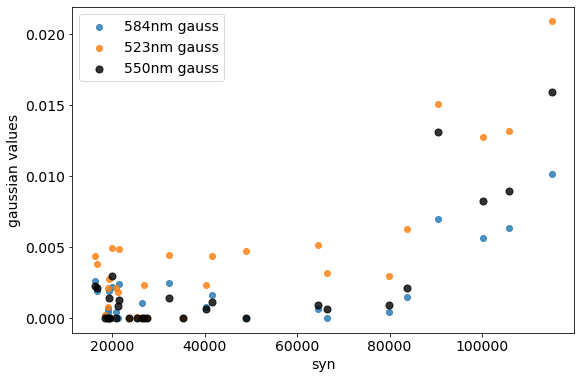

In [43]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus584, alpha=0.8, label='584nm gauss')
ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus523, alpha=0.8, label='523nm gauss')
# ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus453, alpha=0.8, label='453nm gauss')
ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus550, alpha=0.8, label='550nm gauss', color='black', s=50)

ax.legend()


ax.set_xlabel('syn')
ax.set_ylabel('gaussian values')
# plt.savefig('syn_v_gaussians.png', dpi=300)

Text(0, 0.5, 'gaussian values')

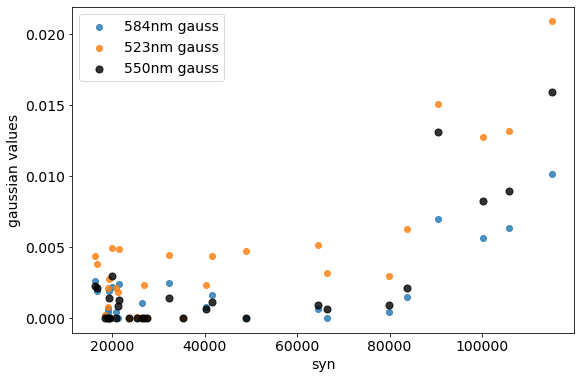

In [44]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus584, alpha=0.8, label='584nm gauss')
ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus523, alpha=0.8, label='523nm gauss')
# ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus453, alpha=0.8, label='453nm gauss')
ax.scatter((optical_df.SynA+optical_df.SynB)/2, optical_df.agaus550, alpha=0.8, label='550nm gauss', color='black', s=50)

ax.legend()


ax.set_xlabel('syn')
ax.set_ylabel('gaussian values')
# plt.savefig('syn_v_gaussians.png', dpi=300)

## Calculate density along the transect

In [45]:
import gsw

In [46]:
# need to smooth out the per second measurements of S and T to minute rolling bins

In [47]:
tsg_df.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaA', 'BacteriaB', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'cdomVolts', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a', 'SILa', 'NO2a',
       'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b'],
      dtype='object')

In [48]:
tsg_df['sigma'] = gsw.density.sigma0(tsg_df.Sal, tsg_df.Temp).rolling(window=5).mean()

Calculate density gradient

In [49]:
tn_names = ['transect_1', 'transect_2', 'transect_3', 'transect_4', 'transect_5', 'transect_6', 'transect_7', 'transect_8', 'transect_9']

In [50]:
# bad practice but they're too noisy
import warnings
warnings.filterwarnings("ignore")

In [41]:
tsg_df.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaA', 'BacteriaB', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'cdomVolts', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a', 'SILa', 'NO2a',
       'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b', 'sigma', 'sigma_grad'],
      dtype='object')

In [42]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

In [51]:
temp_gs = 28.5
sal_gs = 35.9
sal_only_gs = 36.1
temp_only_shelf = 27.5
sal_only_shelf = 35.5

tsg_df['water_mass'] = 'eddy'
tsg_df['water_mass'][(tsg_df.Sal > sal_gs)&(tsg_df.Temp > temp_gs)] = 'gulfstream'
tsg_df['water_mass'][tsg_df.Temp < temp_only_shelf] = 'shelf'
tsg_df['water_mass'][tsg_df.Sal < sal_only_shelf] = 'shelf'

In [52]:
tsg_df['water_mass_color'] = 'yellow' # eddy
tsg_df['water_mass_color'][(tsg_df.Sal > sal_gs)&(tsg_df.Temp > temp_gs)] = 'blue' # gulfstream
tsg_df['water_mass_color'][tsg_df.Temp < temp_only_shelf] = 'green'
tsg_df['water_mass_color'][tsg_df.Sal < sal_only_shelf] = 'green'

In [53]:
tsg_df['water_mass_code'] = 1 # eddy
tsg_df['water_mass_code'][(tsg_df.Sal > sal_gs)&(tsg_df.Temp > temp_gs)] = 2 # gulfstream
tsg_df['water_mass_code'][tsg_df.Temp < temp_only_shelf] = 0
tsg_df['water_mass_code'][tsg_df.Sal < sal_only_shelf] = 0

(array([ 8., 10., 20., 20.,  3.,  4.,  5., 11.,  1.,  3.]),
 array([ 451000.,  512900.,  574800.,  636700.,  698600.,  760500.,
         822400.,  884300.,  946200., 1008100., 1070000.]),
 <BarContainer object of 10 artists>)

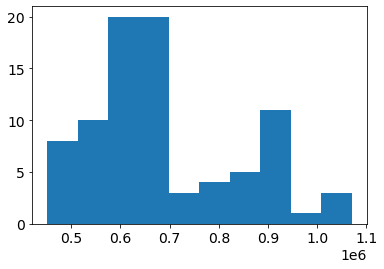

In [54]:
plt.hist(tsg_df.BacteriaA)

In [55]:
optical_df['water_mass'] = 'eddy'
optical_df['water_mass'][(optical_df.sal > sal_gs)&(optical_df.temp > temp_gs)] = 'gulfstream'
optical_df['water_mass'][optical_df.temp < temp_only_shelf] = 'shelf'
optical_df['water_mass'][optical_df.sal < sal_only_shelf] = 'shelf'

optical_df['water_mass_code'] = 1 # eddy
optical_df['water_mass_code'][(optical_df.sal > sal_gs)&(optical_df.temp > temp_gs)] = 2 # gulfstream
optical_df['water_mass_code'][optical_df.temp < temp_only_shelf] = 0
optical_df['water_mass_code'][optical_df.sal < sal_only_shelf] = 0

Let's write out the TSdata/sept_cruise/sept_sw_optical_inline_data.csv

In [48]:
# tsg_df[tsg_df.BacteriaAvg > 0].to_csv('sept_sw_stations_all_details_160321.csv')

In [49]:
plt.rcParams.update({'font.size': 20})

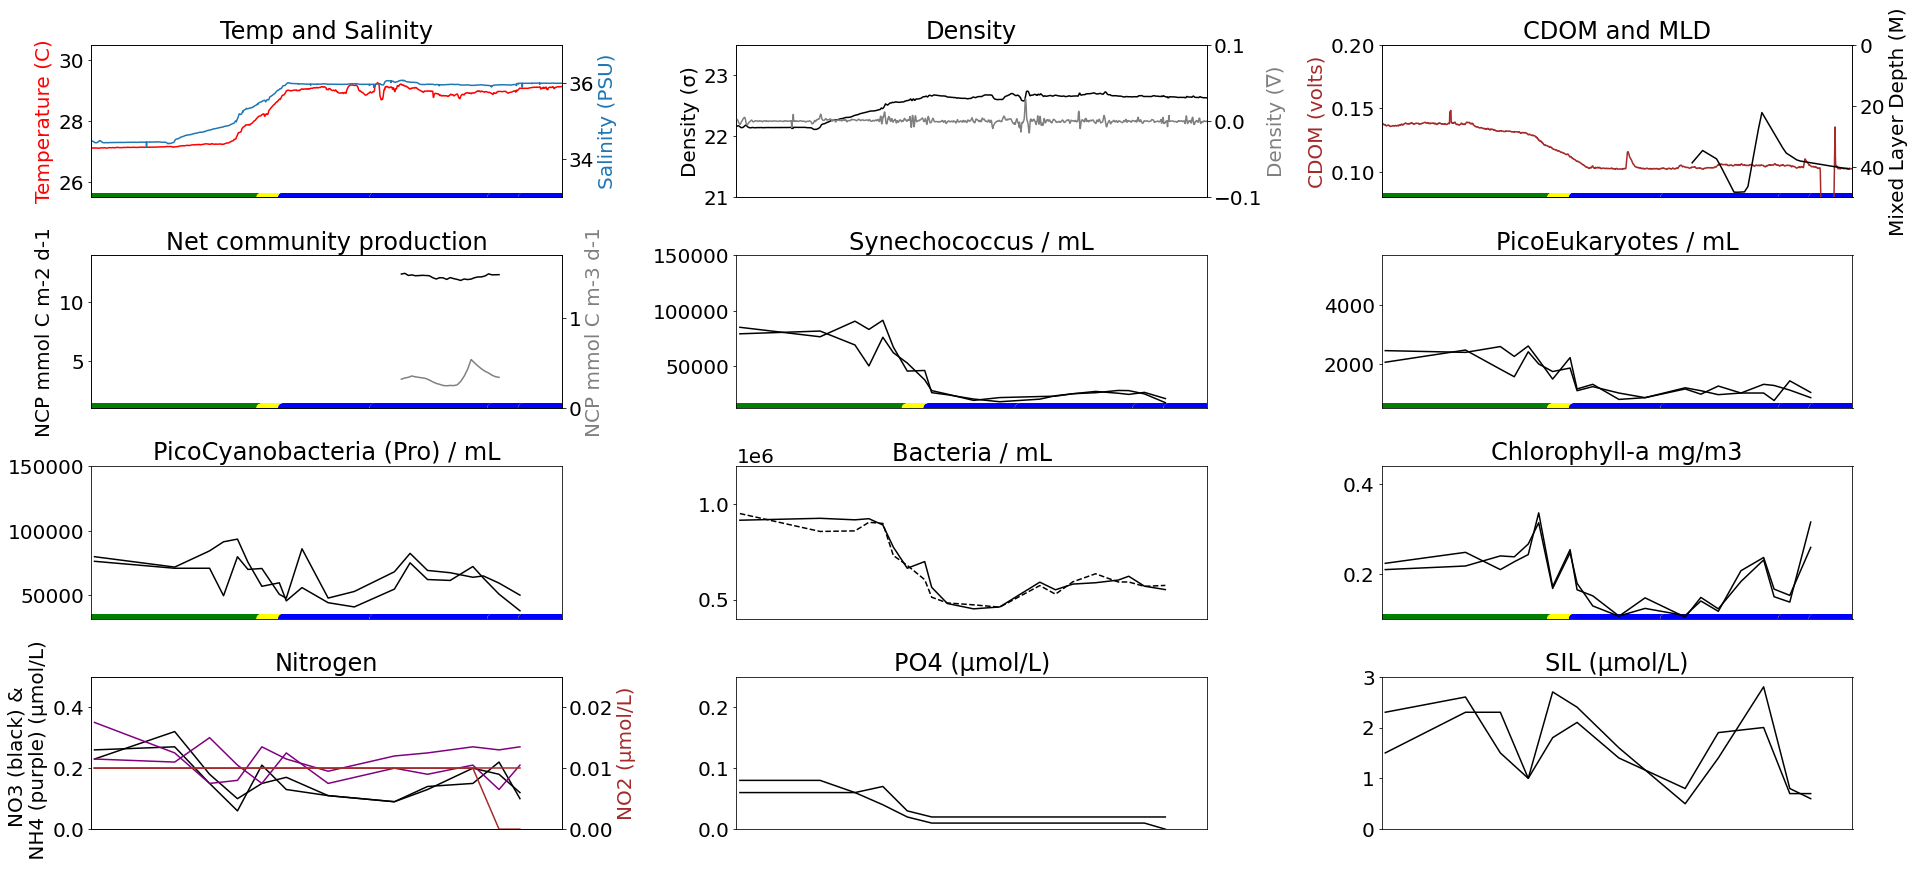

----------------------------------------------------------------------------------------------------------


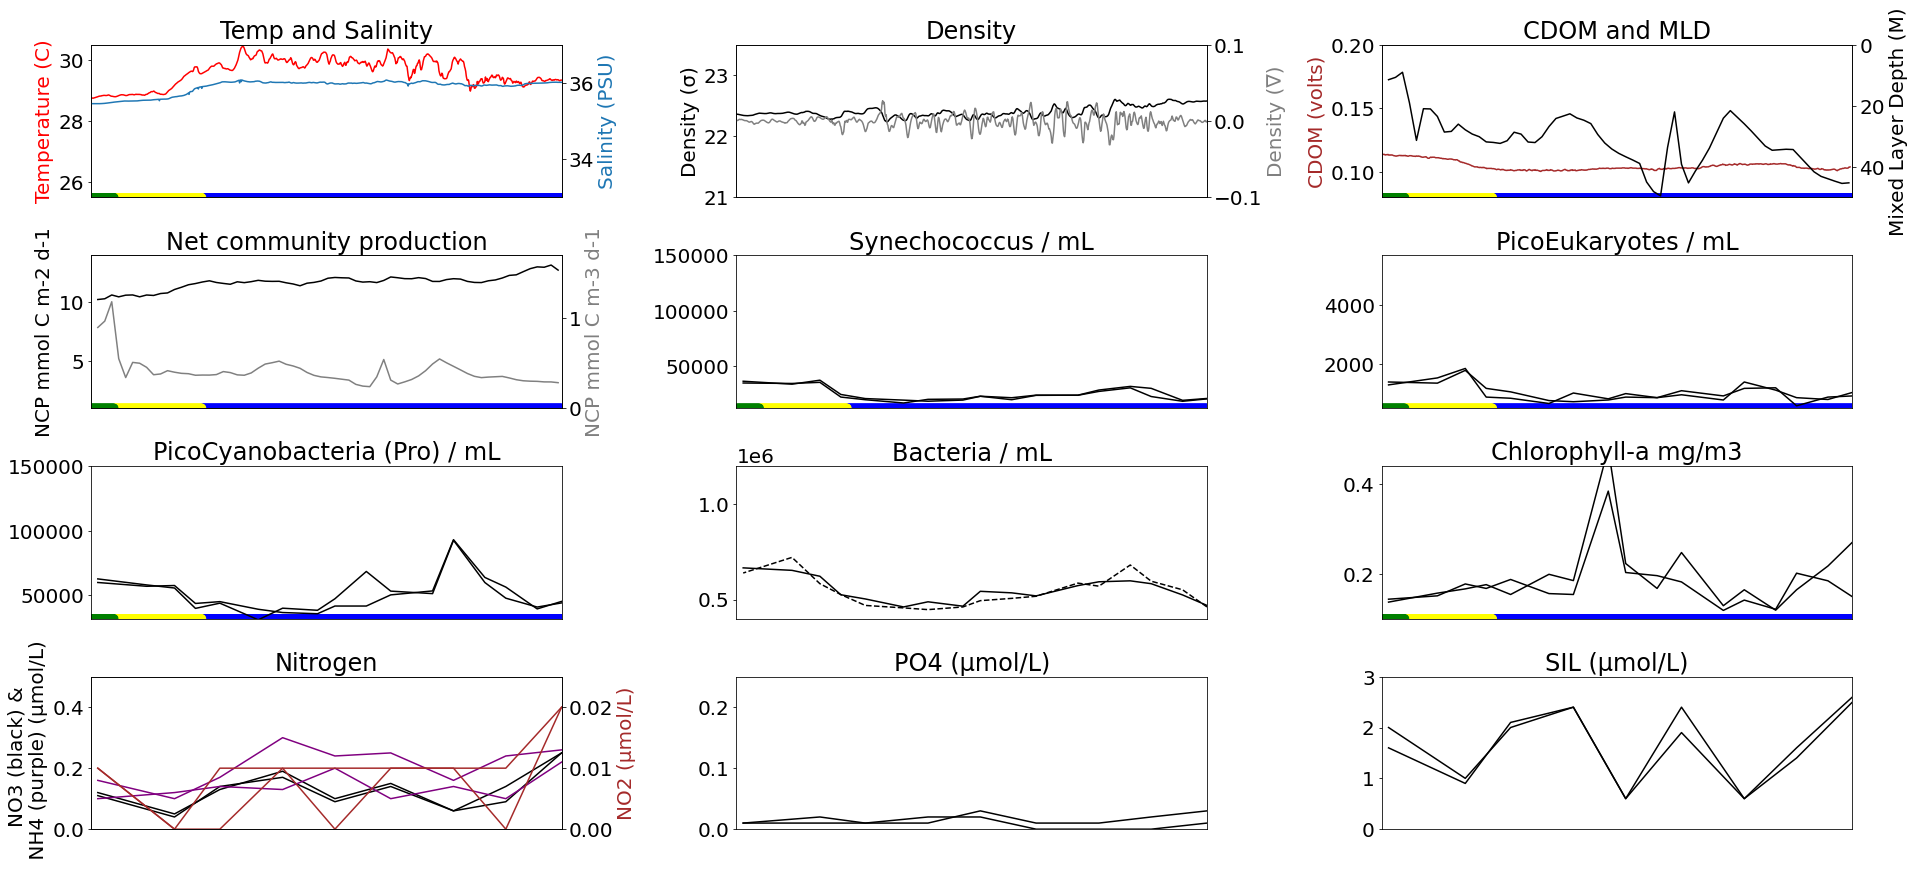

----------------------------------------------------------------------------------------------------------


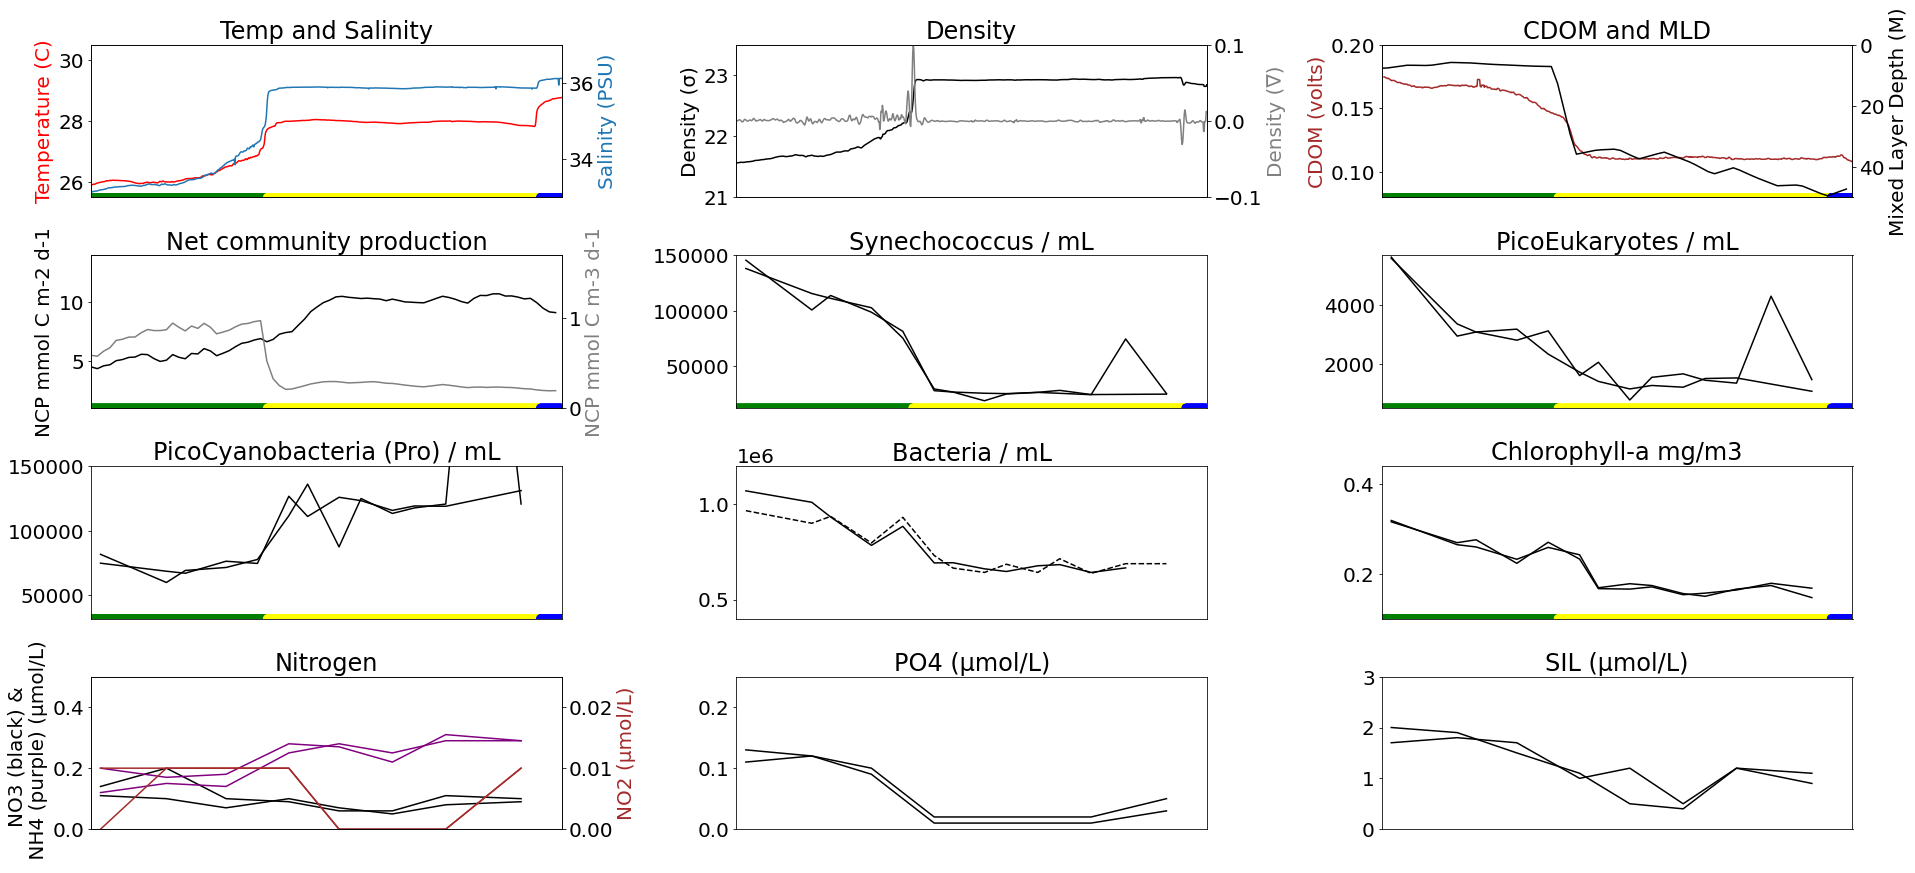

----------------------------------------------------------------------------------------------------------


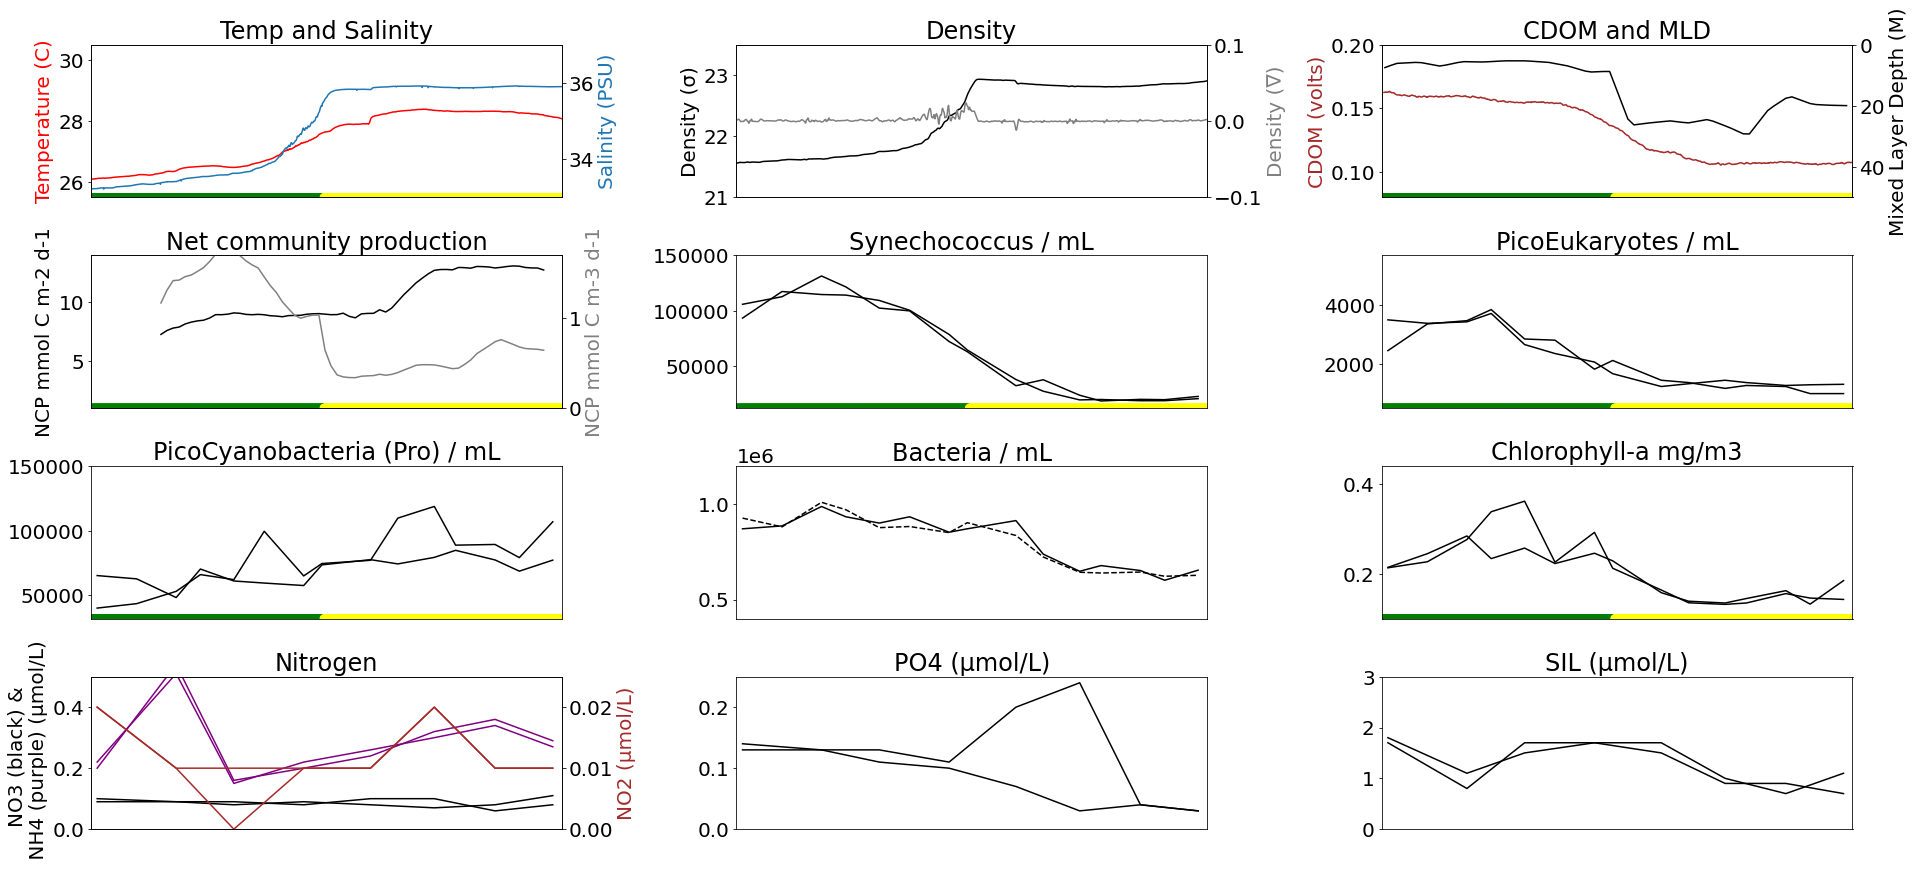

----------------------------------------------------------------------------------------------------------


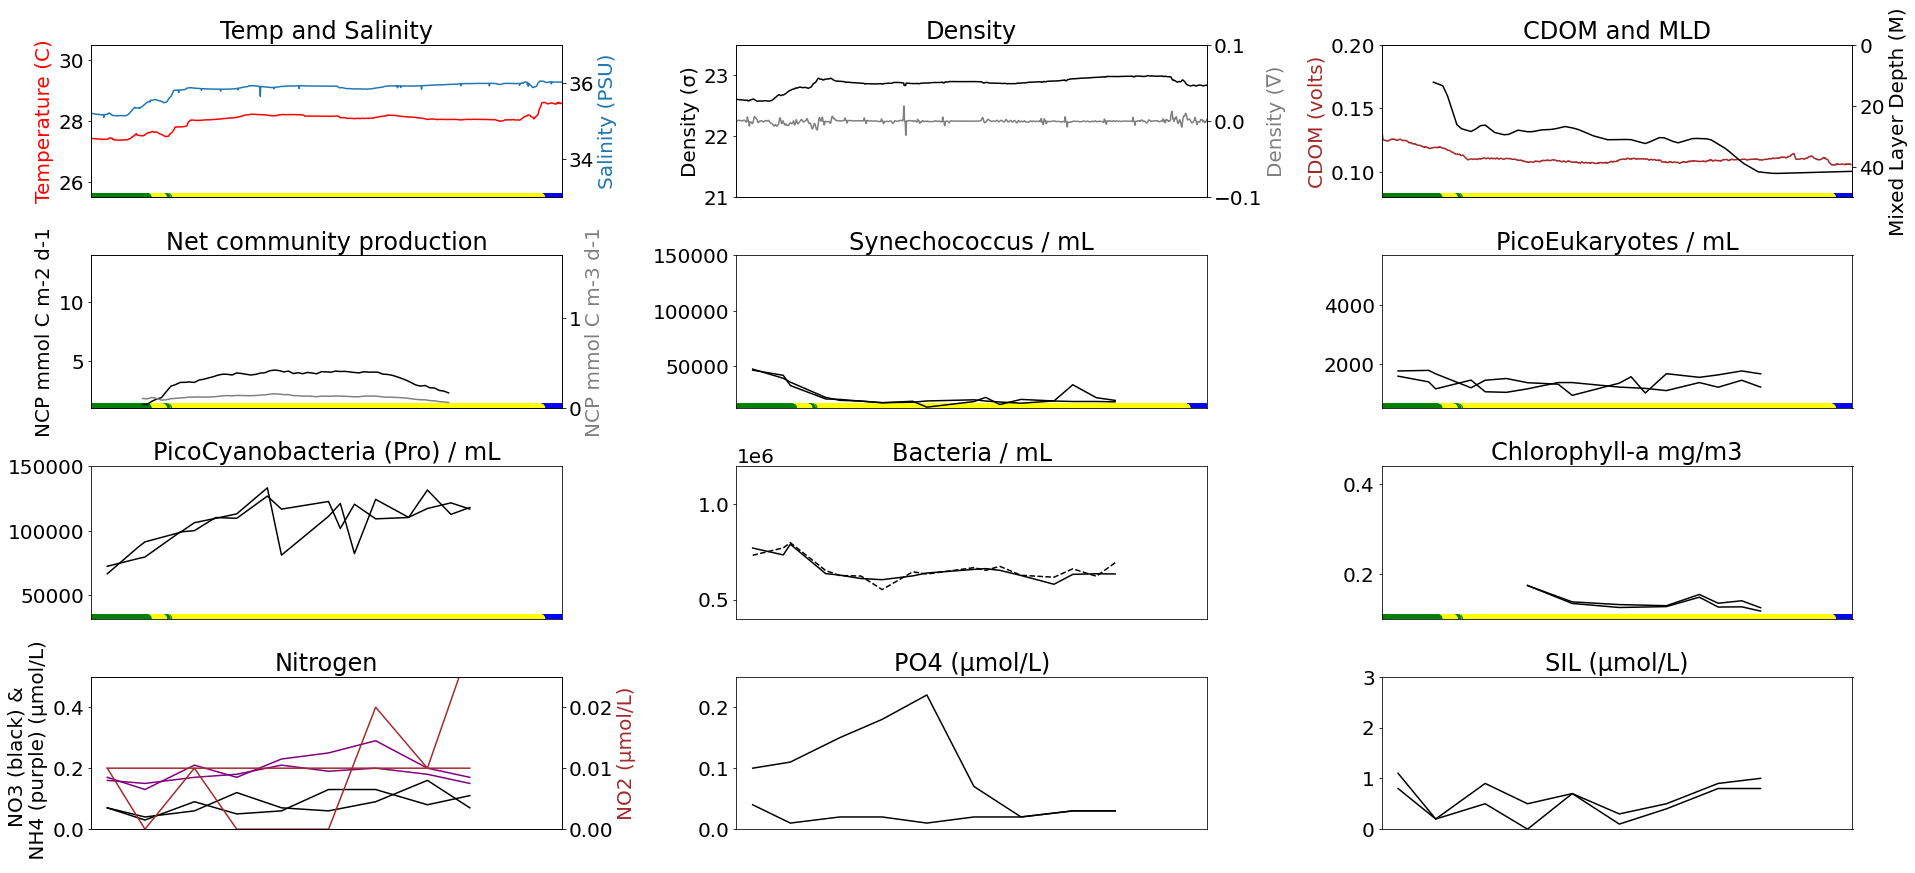

----------------------------------------------------------------------------------------------------------


In [51]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

# for i in range(9):
for i in [0,1,4,5,8]:
        # time series plot
        fig = plt.figure(figsize=(27,12))

        gs = fig.add_gridspec(4,3)
        
        temp_ax = fig.add_subplot(gs[0, 0]) # S/T
        density_ax = fig.add_subplot(gs[0, 1]) # density
        cdom_ax = fig.add_subplot(gs[0, 2]) # cdom
        ncp_ax = fig.add_subplot(gs[1, 0]) # ncp
        syn_ax = fig.add_subplot(gs[1, 1]) # syn
        picoeu_ax = fig.add_subplot(gs[1, 2]) # picoeu
        picocy_ax = fig.add_subplot(gs[2, 0]) # picocy
        bac_ax = fig.add_subplot(gs[2, 1])
        chla_ax = fig.add_subplot(gs[2, 2])
        
        nit_ax = fig.add_subplot(gs[3, 0])
        po4_ax = fig.add_subplot(gs[3, 1])
        sil_ax = fig.add_subplot(gs[3, 2])

        sal_ax = temp_ax.twinx()
        density_grad_ax = density_ax.twinx()
        ncp_vol_ax = ncp_ax.twinx()
        mld_ax = cdom_ax.twinx()
        
        no2_ax = nit_ax.twinx()
        
#         temp_ax.axhline(temp_only_shelf,color='green')
#         sal_ax.axhline(sal_only_shelf,color='green', ls='--')
    

#         temp_ax.axhline(temp_gs,color='blue')
#         sal_ax.axhline(sal_gs,color='blue', ls='--')
        
#         ax3 = ax.twinx()
#         ax4 = ax.twinx()
#         ax5 = ax.twinx()
#         ax6 = ax.twinx()
#         ax7 = ax.twinx()
#         ax8 = ax7.twinx()
#         ax9 = ax.twinx()

        temp_ax.set_ylim(25.5, 30.5)
        sal_ax.set_ylim(33, 37)
        cdom_ax.set_ylim(.08, .2)
        syn_ax.set_ylim(12000, 150000)
        picoeu_ax.set_ylim(500, 5700)
        picocy_ax.set_ylim(32000, 150000)
        bac_ax.set_ylim(400000, 1200000)
        chla_ax.set_ylim(.1, .44)
        ncp_ax.set_ylim(1, 14)
        density_ax.set_ylim(21, 23.5)
        density_grad_ax.set_ylim(-.1, .1)
        ncp_vol_ax.set_ylim(0, 1.7)
        mld_ax.set_ylim(50,0)
        
        nit_ax.set_ylim(0,0.5)
        po4_ax.set_ylim(0,0.25)
        sil_ax.set_ylim(0,3)
        no2_ax.set_ylim(0,0.025)
        
        markersize = 60
        temp_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[25.5],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        syn_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[12000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        picoeu_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[500],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        picocy_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[32000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        bac_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[120000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        chla_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[.1],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        density_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[18],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ncp_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[1],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        cdom_ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[0.08],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)

        
#         ax.axhline(temp_gs, color='red')
#         ax1.axhline(sal_gs, color='blue')
#         ax1.axhline(sal_only_gs, color='blue', ls='--')
        # salinity
        
#         ax3.set_yscale('log')
#         ax4.set_yscale('log')
#         ax5.set_yscale('log')
#         ax6.set_yscale('log')

#         ax.set_xlabel("Time (UTC)")
        temp_ax.set_title("Temp and Salinity")
        temp_ax.set_ylabel("Temperature (C)")
        sal_ax.set_ylabel("Salinity (PSU)")
        
        cdom_ax.set_title("CDOM and MLD")
        cdom_ax.set_ylabel("CDOM (volts)")
        mld_ax.set_ylabel('Mixed Layer Depth (M)')
        
        syn_ax.set_title("Synechococcus / mL")
        picoeu_ax.set_title("PicoEukaryotes / mL")
        picocy_ax.set_title("PicoCyanobacteria (Pro) / mL")
        bac_ax.set_title("Bacteria / mL")
        chla_ax.set_title("Chlorophyll-a mg/m3")
        
        density_ax.set_title('Density')
        density_ax.set_ylabel('Density (σ)')
        density_grad_ax.set_ylabel('Density (∇)')
        
        ncp_ax.set_title('Net community production')
        ncp_ax.set_ylabel('NCP mmol C m-2 d-1')
        ncp_vol_ax.set_ylabel('NCP mmol C m-3 d-1')
        
        nit_ax.set_title('Nitrogen')
        nit_ax.set_ylabel('NO3 (black) & \n NH4 (purple) (µmol/L)')
        no2_ax.set_ylabel('NO2 (µmol/L)')
        po4_ax.set_title('PO4 (µmol/L)')
        sil_ax.set_title('SIL (µmol/L)')



        p1, = temp_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp')
        p2, = sal_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity')
        
        p10, = density_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)',  color='black')
        p11, = density_grad_ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma_grad'], label='Density (sigma)',  color='grey')

        p3, = cdom_ax.plot(tsg_df[tsg_df['cdomVolts'].notnull()].loc[start_times[i]:end_times[i]].index, 
                             tsg_df[tsg_df['cdomVolts'].notnull()].loc[start_times[i]:end_times[i]].rolling(window=5).mean()['cdomVolts'], label='CDOM',color='brown')

        p4, = syn_ax.plot(tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='k')
        p4, = syn_ax.plot(tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]]['SynB'], label='Syn/mL', color='k')
        p5, = picoeu_ax.plot(tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='k')
        p5, = picoeu_ax.plot(tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]]['PeuksB'], label='Peuks/mL', color='k')
        p6, = picocy_ax.plot(tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='k')
        p6, = picocy_ax.plot(tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoB'], label='PicoCyano/mL', color='k')
        p7, = bac_ax.plot(tsg_df[tsg_df['BacteriaA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaA'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaA'], label='Bacteria/mL', color='k')
        p7, = bac_ax.plot(tsg_df[tsg_df['BacteriaB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaB'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaB'],label='Bacteria/mL', color='k', ls='--')
        p8, = chla_ax.plot(tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]]['ChlaA'], label='Chla mg/m3', color='k')
        p8, = chla_ax.plot(tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]]['ChlaB'], label='Chla mg/m3', color='k')
        p9, = ncp_ax.plot(tsg_df[tsg_df['NCPm2'].notnull()].loc[start_times[i]:end_times[i]].index, 
                          tsg_df[tsg_df['NCPm2'].notnull()].loc[start_times[i]:end_times[i]]['NCPm2'], label='NCP mmol C m-2 d-1', color='k')    
        p12, = ncp_vol_ax.plot(tsg_df[tsg_df['NCPm3'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NCPm3'].notnull()].loc[start_times[i]:end_times[i]]['NCPm3'], label='NCP mmol C m-3 d-1', color='grey')
        p13, = mld_ax.plot(tsg_df[tsg_df['MLD'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['MLD'].notnull()].loc[start_times[i]:end_times[i]]['MLD'], label='Mixed Layer Depth', color='black')   
        
        
#         'NO3a', 'PO4a', 'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b','SILb', 'NO2b', 'NH4b',
        
        p14, = nit_ax.plot(tsg_df[tsg_df['NO3a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO3a'].notnull()].loc[start_times[i]:end_times[i]]['NO3a'], label='NO3', color='black')  
        p15, = nit_ax.plot(tsg_df[tsg_df['NO3b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO3b'].notnull()].loc[start_times[i]:end_times[i]]['NO3b'], label='NO3', color='black')  
        
        p16, = no2_ax.plot(tsg_df[tsg_df['NO2a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO2a'].notnull()].loc[start_times[i]:end_times[i]]['NO2a'], label='NO2', color='brown')  
        p17, = no2_ax.plot(tsg_df[tsg_df['NO2b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NO2b'].notnull()].loc[start_times[i]:end_times[i]]['NO2b'], label='NO2', color='brown') 
        
        p18, = nit_ax.plot(tsg_df[tsg_df['NH4a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NH4a'].notnull()].loc[start_times[i]:end_times[i]]['NH4a'], label='NH4', color='purple')  
        p19, = nit_ax.plot(tsg_df[tsg_df['NH4b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['NH4b'].notnull()].loc[start_times[i]:end_times[i]]['NH4b'], label='NH4', color='purple') 
        
        
        
        p20, = po4_ax.plot(tsg_df[tsg_df['PO4a'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['PO4a'].notnull()].loc[start_times[i]:end_times[i]]['PO4a'], label='PO4', color='black')  
        p21, = po4_ax.plot(tsg_df[tsg_df['PO4b'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['PO4b'].notnull()].loc[start_times[i]:end_times[i]]['PO4b'], label='PO4', color='black')
        
        
        p22, = sil_ax.plot(tsg_df[tsg_df['SILa'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['SILa'].notnull()].loc[start_times[i]:end_times[i]]['SILa'], label='SIL', color='black')  
        p23, = sil_ax.plot(tsg_df[tsg_df['SILb'].notnull()].loc[start_times[i]:end_times[i]].index, 
                               tsg_df[tsg_df['SILb'].notnull()].loc[start_times[i]:end_times[i]]['SILb'], label='SIL', color='black')
        
        
#         ax.set_title(titles[i])

#         lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
#         ax2.spines['right'].set_position(('outward', 50))
#         ax2.spines['left'].set_position(('outward', 60))
#         ax2.spines['left'].set_visible(True)
#         ax2.yaxis.set_label_position('left')
#         ax2.yaxis.set_ticks_position('left')
#         ax9.spines['left'].set_position(('outward', 120))
#         ax9.spines['left'].set_visible(True)
#         ax9.yaxis.set_label_position('left')
#         ax9.yaxis.set_ticks_position('left')
#         ax3.spines['right'].set_position(('outward', 160))
#         ax4.spines['right'].set_position(('outward', 250))
#         ax5.spines['right'].set_position(('outward', 345))
#         ax6.spines['right'].set_position(('outward', 440))
#         ax7.spines['right'].set_position(('outward', 540))
#         ax8.spines['right'].set_position(('outward', 640))
#         ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
#         ax.xaxis.set_ticks([])
#         ax3.xaxis.set_ticks([])
#         ax4.xaxis.set_ticks([])
#         ax5.xaxis.set_ticks([])
#         ax6.xaxis.set_ticks([])
#         ax7.xaxis.set_ticks([])
#         fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')
        
        for a in [temp_ax,density_ax,cdom_ax,ncp_ax,syn_ax,picoeu_ax,picocy_ax,bac_ax,chla_ax, nit_ax, po4_ax, sil_ax ]:
            if i ==0:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==1:
                 a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))
            elif i ==4:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==5:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==8:
                a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))
                
            a.xaxis.set_ticks([])

        temp_ax.yaxis.label.set_color(p1.get_color())
        sal_ax.yaxis.label.set_color(p2.get_color())
        cdom_ax.yaxis.label.set_color(p3.get_color())
        density_ax.yaxis.label.set_color(p10.get_color())
        density_grad_ax.yaxis.label.set_color(p11.get_color())
        mld_ax.yaxis.label.set_color(p13.get_color())
        ncp_ax.yaxis.label.set_color(p9.get_color())
        ncp_vol_ax.yaxis.label.set_color(p12.get_color())
        nit_ax.yaxis.label.set_color('black')
        no2_ax.yaxis.label.set_color(p17.get_color())
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/s_t_division'+titles[i] +'.png',dpi=600)
    #     plt.close()
        plt.show()
        print('----------------------------------------------------------------------------------------------------------')
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

In [52]:
tsg_df.head(2)

DateTime     Temp      Sal  Unknown  \
utc_dt                                                                         
2021-09-04 22:57:51.709  09/04/2021,22:57:51.709,  26.5469  36.0464  1539.56   
2021-09-04 22:58:01.635  09/04/2021,22:58:01.635,  26.5226  36.0374  1539.49   

                                       datetime        lat        lon  \
utc_dt                                                                  
2021-09-04 22:57:51.709 2021-09-04 22:57:51.709  34.635135 -76.658900   
2021-09-04 22:58:01.635 2021-09-04 22:58:01.635  34.634277 -76.658408   

                                           geometry  SynA  PeuksA  ...  NO3b  \
utc_dt                                                             ...         
2021-09-04 22:57:51.709  POINT (-76.65890 34.63513)   NaN     NaN  ...   NaN   
2021-09-04 22:58:01.635  POINT (-76.65841 34.63428)   NaN     NaN  ...   NaN   

                         PO4b  SILb  NO2b  NH4b  sigma  sigma_grad  \
utc_dt                                                               
2021-09-04 22:57:51.709   NaN   NaN   NaN   NaN    NaN         NaN   
2021-09-04 22:58:01.635   NaN   NaN   NaN   NaN    NaN         NaN   

                         water_mass  water_mass_color  water_mass_code  
utc_dt                                                                  
2021-09-04 22:57:51.709       shelf             green                0  
2021-09-04 22:58:01.635       shelf             green                0  

[2 rows x 38 columns]

In [ ]:
df_subset.columns

In [ ]:
plt.hist(tsg_df.cdomVolts,bins=50)
plt.xlim(0,.3)

In [60]:
start_times = ['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

end_times = ['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 15:30:00']

dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [56]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

In [57]:
dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [62]:
plt.rcParams.update({'font.size': 14})

(array([ 51.,  70., 163., 100.,  29.,  63.,   5.,  17.,  64.,  62.,  25.,
         65.,  76.,  42.,  29.,   8.,   5.,   3.,   3.,   5.]),
 array([0.03592827, 0.12107609, 0.20622392, 0.29137174, 0.37651956,
        0.46166738, 0.54681521, 0.63196303, 0.71711085, 0.80225867,
        0.88740649, 0.97255432, 1.05770214, 1.14284996, 1.22799778,
        1.3131456 , 1.39829343, 1.48344125, 1.56858907, 1.65373689,
        1.73888471]),
 <BarContainer object of 20 artists>)

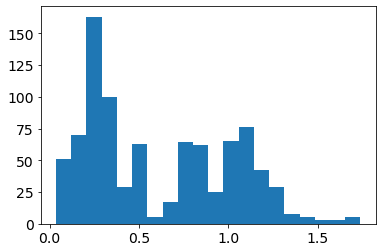

In [63]:
plt.hist(tsg_df.NCPm3,bins=20)

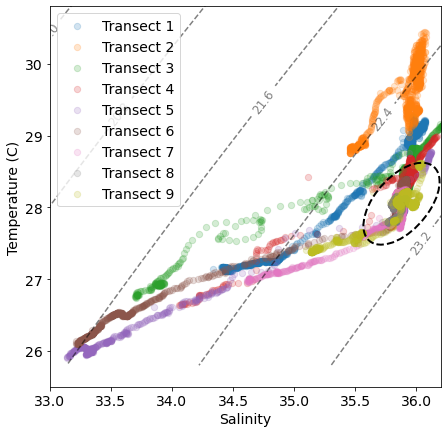

In [61]:
# Figure out boudaries (mins and maxs)
smin = 33-.7
smax = 36.2+.7
tmin = 25.5-.7
tmax = 30.8+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000


    
# plot T and S diagrams first with distance from coast and then with other variables
fig, ax = plt.subplots(figsize=(7,7))
markersize=40

ax.set_xlim(33,36.2)
ax.set_ylim(25.5,30.8)
ax.set_xlabel('Salinity')
ax.set_ylabel('Temperature (C)')

CS = ax.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
ax.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
                edgecolor='k', fc='None', ls='--', lw=2)
ax.add_patch(ellipse)
alpha=0.2

# colors=['blue','green','orange','red', 'aqua',]

# for idx,i in enumerate([0,1,4,5,8]):
for idx,i in enumerate([0,1,2,3,4,5,6,7,8]):
    df_subset_full = tsg_df.loc[start_times[i]:end_times[i]]
    im = ax.scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize,alpha=0.2, label='Transect '+str(i+1))
ax.legend()
# fig.savefig('figs/simple_t_s_diagram_all_transects.png',dpi=300)


(array([32., 49., 71., 70., 24.,  5.,  5.,  4., 10.,  7.]),
 array([ 2.09255879,  3.76779238,  5.44302598,  7.11825958,  8.79349317,
        10.46872677, 12.14396037, 13.81919396, 15.49442756, 17.16966116,
        18.84489475]),
 <BarContainer object of 10 artists>)

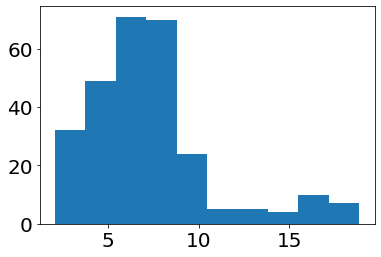

In [55]:
plt.hist(optical_df.HH_G50)

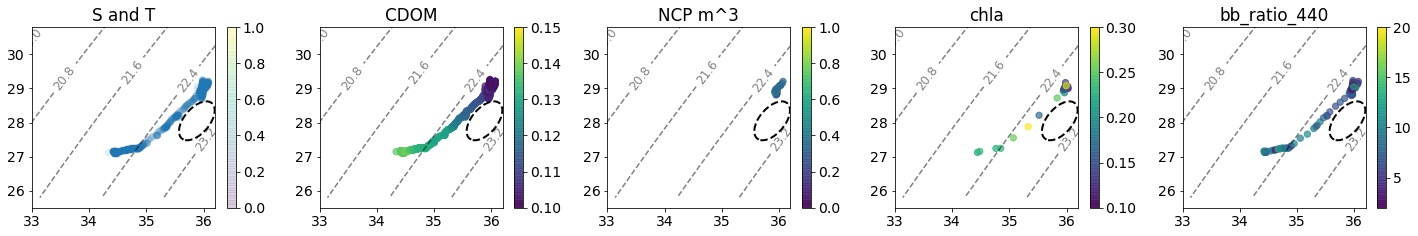

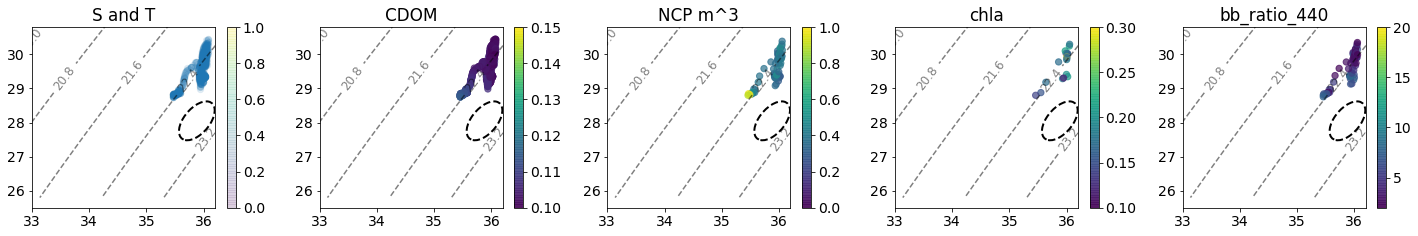

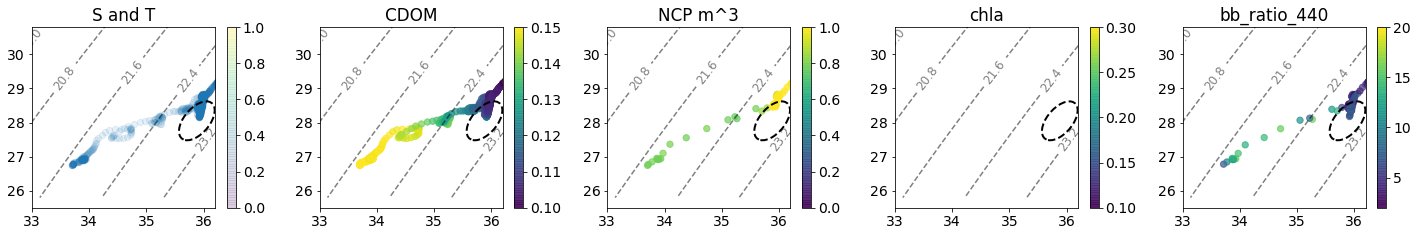

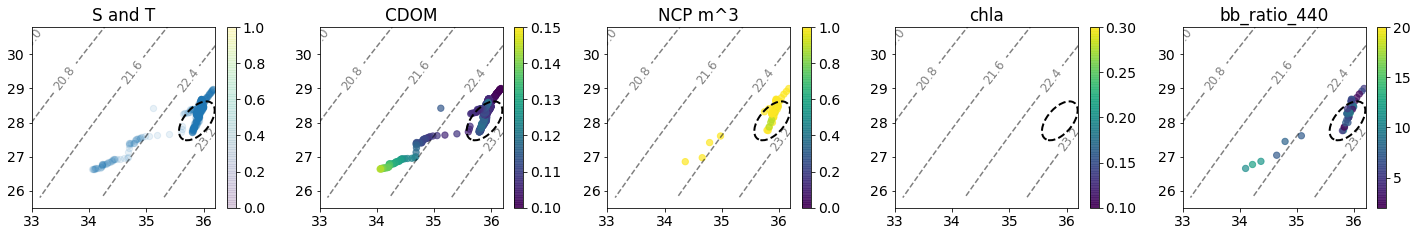

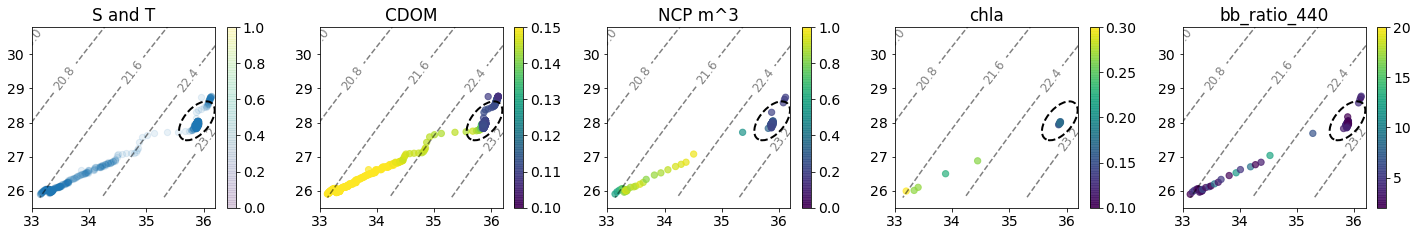

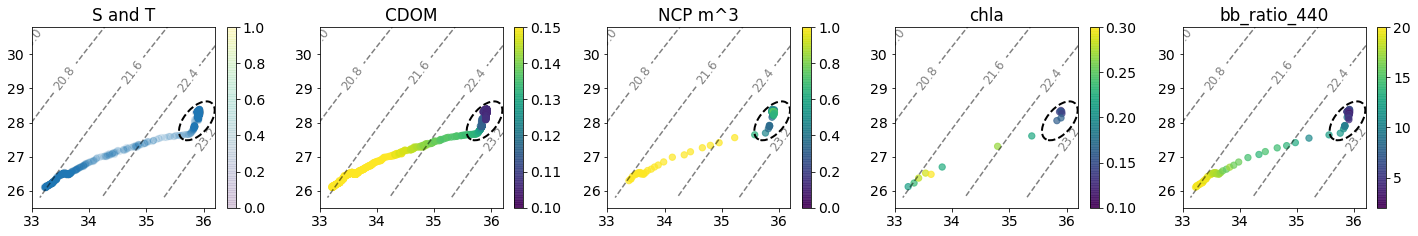

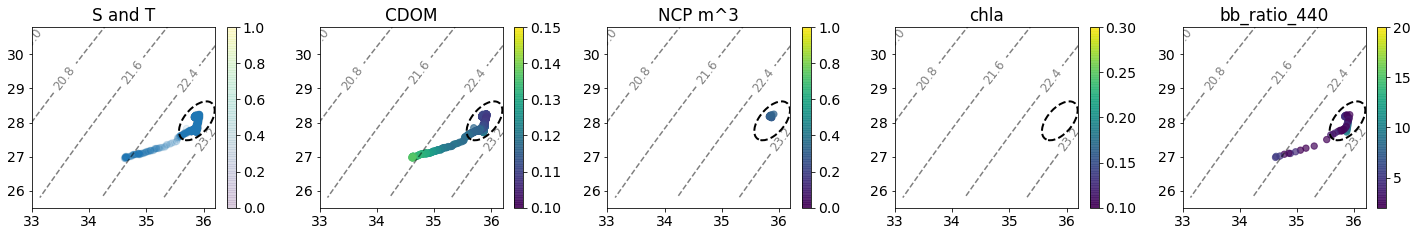

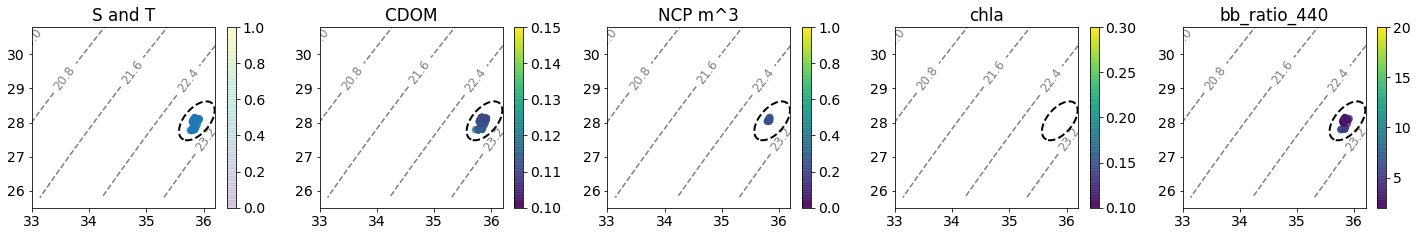

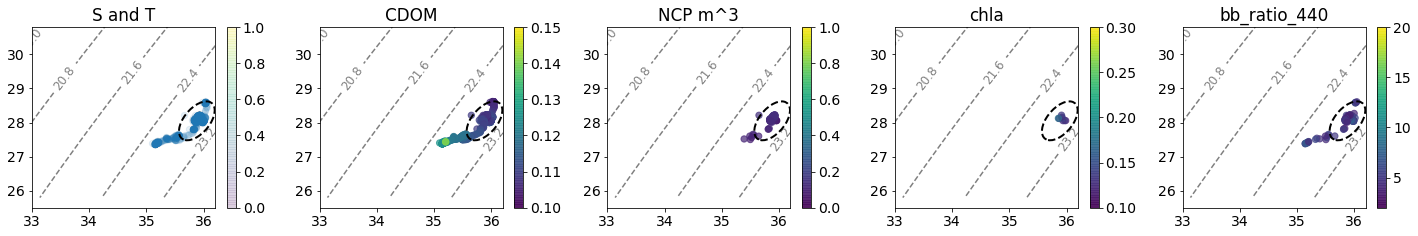

In [64]:
# Figure out boudaries (mins and maxs)
smin = 33-.7
smax = 36.2+.7
tmin = 25.5-.7
tmax = 30.8+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000


# for outer_idx, i in enumerate([0,1,4,5,8]):
for outer_idx,i in enumerate([0,1,2,3,4,5,6,7,8]):
    
    # plot T and S diagrams first with distance from coast and then with other variables
    fig, ax = plt.subplots(1,5,figsize=(5*4,3.5))
    df_subset_full = tsg_df.loc[start_times[i]:end_times[i]]
    df_subset = df_subset_full[df_subset_full['BacteriaA'].notnull()]
    markersize=40
    
    optical_subset = optical_df.loc[start_times[i]:end_times[i]]
#     time_ordering = None
    
#     if i ==0:
#         time_ordering=df_subset.loc[start_times[i]:end_times[i]]['datetime'].values
#     elif i ==1:
#          time_ordering=np.flip(df_subset.loc[start_times[i]:end_times[i]]['datetime'].values)
#     elif i ==4:
#         time_ordering=df_subset.loc[start_times[i]:end_times[i]]['datetime'].values
#     elif i ==5:
#         time_ordering=df_subset.loc[start_times[i]:end_times[i]]['datetime'].values
#     elif i ==8:
#         time_ordering=np.flip(df_subset.loc[start_times[i]:end_times[i]]['datetime'].values)
        
    titles = ['S and T','CDOM', 'NCP m^3', 'chla', 'bb_ratio_440']
    
    for idx,a in enumerate([ax[0], ax[1], ax[2],ax[3],ax[4]]):

        a.set_xlim(33,36.2)
        a.set_ylim(25.5,30.8)
#         a.set_xlabel('Salinity')
#         a.set_ylabel('Temperature (C)')
        a.set_title(titles[idx])
        CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
        a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
        ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
                        edgecolor='k', fc='None', ls='--', lw=2)
        a.add_patch(ellipse)
    alpha=0.7
#     im = ax[0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.cdomVolts, vmin=0.08,vmax=.15,alpha=alpha)
#     fig.colorbar(im,ax=ax[0])
    im = ax[0].scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize,alpha=0.1)
    fig.colorbar(im,ax=ax[0])
    im = ax[1].scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize, c=df_subset_full.cdomVolts, vmin=0.1,vmax=.15,alpha=alpha)
    fig.colorbar(im,ax=ax[1])
#     ax[1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.NH4b, vmin=.1,vmax=.3)
    im = ax[2].scatter(df_subset_full.Sal, df_subset_full.Temp, s=markersize, c=df_subset_full.NCPm3, vmin=0,vmax=1,alpha=alpha)
    fig.colorbar(im,ax=ax[2])
    im=ax[3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.ChlaAvg, vmin=.1,vmax=.3,alpha=alpha)
    fig.colorbar(im,ax=ax[3])
#     im=ax[3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=(df_subset.NH4a+df_subset.NH4b)/2, vmin=.1,vmax=.3,alpha=alpha)
#     fig.colorbar(im,ax=ax[3])
    #im = ax[4].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO3a+df_subset.NO3b)/2/(df_subset.PO4a+df_subset.PO4b)/2), vmin=.0,vmax=2,alpha=alpha)
#     optical_subset = optical_subset[(optical_subset.gamma/optical_df.chl_ap676lh).notnull()]
    im=ax[4].scatter(optical_subset.sal, optical_subset.temp, s=markersize, c=optical_subset.HH_G50, vmin=2,vmax=20, alpha=alpha)
    fig.colorbar(im,ax=ax[4])
    fig.tight_layout()
#     fig.savefig('figs/t_s_diagram_transect_'+str(i+1)+'.png',dpi=300)


(array([24.,  8.,  5.,  5.,  5.,  0.,  0.,  0.,  0.,  1.]),
 array([0.14130435, 0.85217391, 1.56304348, 2.27391304, 2.98478261,
        3.69565217, 4.40652174, 5.1173913 , 5.82826087, 6.53913043,
        7.25      ]),
 <BarContainer object of 10 artists>)

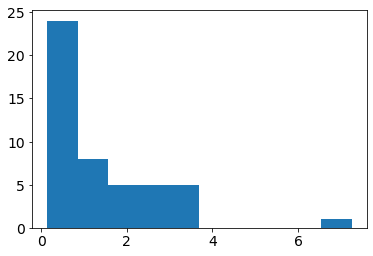

In [65]:
plt.hist(((tsg_df.NO3a+tsg_df.NO3b)/2)/(tsg_df.PO4a+tsg_df.PO4b)/2)

In [ ]:
plt.hist((df_subset.NO2a+df_subset.NO2b)/2)
# plt.xlim(0,.025)

In [ ]:
tsg_df_subset.head(1)

In [ ]:
plt.hist(tsg_df.NCPm3)

In [ ]:
plt.hist(optical_df.bbp_ratio_440)

In [ ]:
plt.hist((tsg_df.BacteriaA+tsg_df.BacteriaB)/2/tsg_df.ChlaAvg)

(array([32., 49., 71., 70., 24.,  5.,  5.,  4., 10.,  7.]),
 array([ 2.09255879,  3.76779238,  5.44302598,  7.11825958,  8.79349317,
        10.46872677, 12.14396037, 13.81919396, 15.49442756, 17.16966116,
        18.84489475]),
 <BarContainer object of 10 artists>)

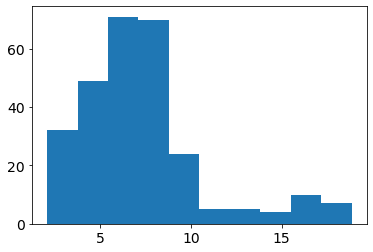

In [68]:
plt.hist(optical_df.HH_G50)

In [66]:

optical_start_times = ['2021-09-5 14:20:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:45:00']
optical_end_times = ['2021-09-5 17:00:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

dfs = []
for i in range(len(optical_start_times)):
    dfs.append(optical_df.loc[optical_start_times[i]:optical_end_times[i]])
optical_df_quality = pd.concat(dfs)

In [ ]:
# Figure out boudaries (mins and maxs)
smin = 33-.7
smax = 36.2+.7
tmin = 25.5-.7
tmax = 30.8+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000

fig, ax = plt.subplots(4,4,figsize=(4.5*4,14.5))

    
# plot T and S diagrams first with distance from coast and then with other variables

df_subset = tsg_df_subset[tsg_df_subset['BacteriaB'].notnull()]
markersize=40

titles = ['CDOM (volts)', 'chla (mg/m3)', 'NCPm3', 'NO3 (µmol/L)', 
          'N02 (µmol/L)', 'NH4 (µmol/L)', 'PO4 (µmol/L)', 'SIL (µmol/L)', 
          'picocyanos /mL', 'syn /mL',  'picoeuk /mL', 'bacteria /mL', 
          'bacteria/chla', 'phyto size (um)', 'backscattering ratio (440)', 'gamma']

for idx,a in enumerate([ax[0,0], ax[0,1], ax[0,2], ax[0,3],
                        ax[1,0], ax[1,1], ax[1,2], ax[1,3],
                        ax[2,0], ax[2,1], ax[2,2], ax[2,3],
                       ax[3,0], ax[3,1], ax[3,2], ax[3,3]]):
    a.set_xlim(33,36.2)
    a.set_ylim(25.5,30.8)
#         a.set_xlabel('Salinity')
#         a.set_ylabel('Temperature (C)')
    a.set_title(titles[idx])
    CS = a.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.5)
    a.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
    
    ellipse = Ellipse(xy=(35.88, 28.05), width=0.5, height=1.2, angle=-20,
                        edgecolor='k', fc='None', ls='--', lw=2)
    a.add_patch(ellipse)
    
alpha=0.85
cmap='viridis'

        
### top column

im = ax[0,0].scatter(tsg_df_subset.Sal, tsg_df_subset.Temp, s=markersize, c=tsg_df_subset.cdomVolts, vmin=0.1,vmax=.16,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,0])

im=ax[0,1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.ChlaAvg, vmin=.1,vmax=.3,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,1])

# im = ax[0,2].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO3a+df_subset.NO3b)/2/(df_subset.PO4a+df_subset.PO4b)/2), vmin=.0,vmax=2,alpha=alpha, cmap=cmap)
# fig.colorbar(im,ax=ax[0,2])
    
im = ax[0,2].scatter(tsg_df_subset.Sal, tsg_df_subset.Temp, s=markersize, c=tsg_df_subset.NCPm3, vmin=.0,vmax=1,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,2])    

im = ax[0,3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO3a+df_subset.NO3b)/2), vmin=.05,vmax=.18, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[0,3])

### nutrients

im=ax[1,0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NO2a+df_subset.NO2b)/2), vmin=.0,vmax=.02 ,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,0])

im=ax[1,1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.NH4a+df_subset.NH4b)/2), vmin=.15,vmax=.3, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,1])

im=ax[1,2].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=((df_subset.PO4a+df_subset.PO4b)/2), vmin=.0,vmax=.12, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,2])

im=ax[1,3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=(df_subset.SILa+df_subset.SILb)/2, vmin=.5,vmax=2, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[1,3])

### FCM

im=ax[2,0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.PicoCyanoA, vmin=40000,vmax=120000, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,0],  format='%.0e')

im=ax[2,1].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.SynA, vmin=10000,vmax=140000,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,1], format='%.0e')

im=ax[2,2].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.PeuksA, vmin=500,vmax=3500, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,2],  format='%.0e')

im=ax[2,3].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=(df_subset.BacteriaA+df_subset.BacteriaB)/2, vmin=400000,vmax=950000,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[2,3],  format='%.0e')

### optical

# 'gamma', 'bbp_ratio_440', 'chl_ap676lh', 'bbp_1'

# im=ax[3,0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=df_subset.PicoCyanoA/df_subset.ChlaAvg, vmin=.2e6,vmax=1e6, alpha=alpha, cmap=cmap)
# # im=ax[3,0].scatter(optical_df.sal, optical_df.temp, s=markersize, c=optical_df.agaus492, vmin=.0,vmax=.025, alpha=alpha, cmap=cmap)
# fig.colorbar(im,ax=ax[3,0],  format='%.0e')
# im=ax[3,1].scatter(optical_df.sal, optical_df.temp, s=markersize, c=optical_df.agaus523, vmin=.000,vmax=.012,alpha=alpha, cmap=cmap)
im=ax[3,0].scatter(df_subset.Sal, df_subset.Temp, s=markersize, c=(df_subset.BacteriaA+df_subset.BacteriaB)/2/df_subset.ChlaAvg, vmin=2e6,vmax=5e6,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[3,0],  format='%.0e')

im=ax[3,1].scatter(optical_df_quality.sal, optical_df_quality.temp, s=markersize, c=optical_df_quality.HH_G50, vmin=3,vmax=18, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[3,1])

im=ax[3,2].scatter(optical_df_quality.sal, optical_df_quality.temp, s=markersize, c=optical_df_quality.bbp_ratio_440, vmin=0.003,vmax=0.007, alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[3,2])

im=ax[3,3].scatter(optical_df_quality.sal, optical_df_quality.temp, s=markersize, c=optical_df_quality.gamma, vmin=0.2,vmax=.6,alpha=alpha, cmap=cmap)
fig.colorbar(im,ax=ax[3,3])

### fin

fig.tight_layout()
# fig.savefig('t_s_diagram_all_variables_200522.png',dpi=600)
plt.show()

In [ ]:
plt.hist(optical_df.agaus550/optical_df.chl_ap676lh)

In [ ]:
plt.hist(optical_df.agaus660
)

Old Version

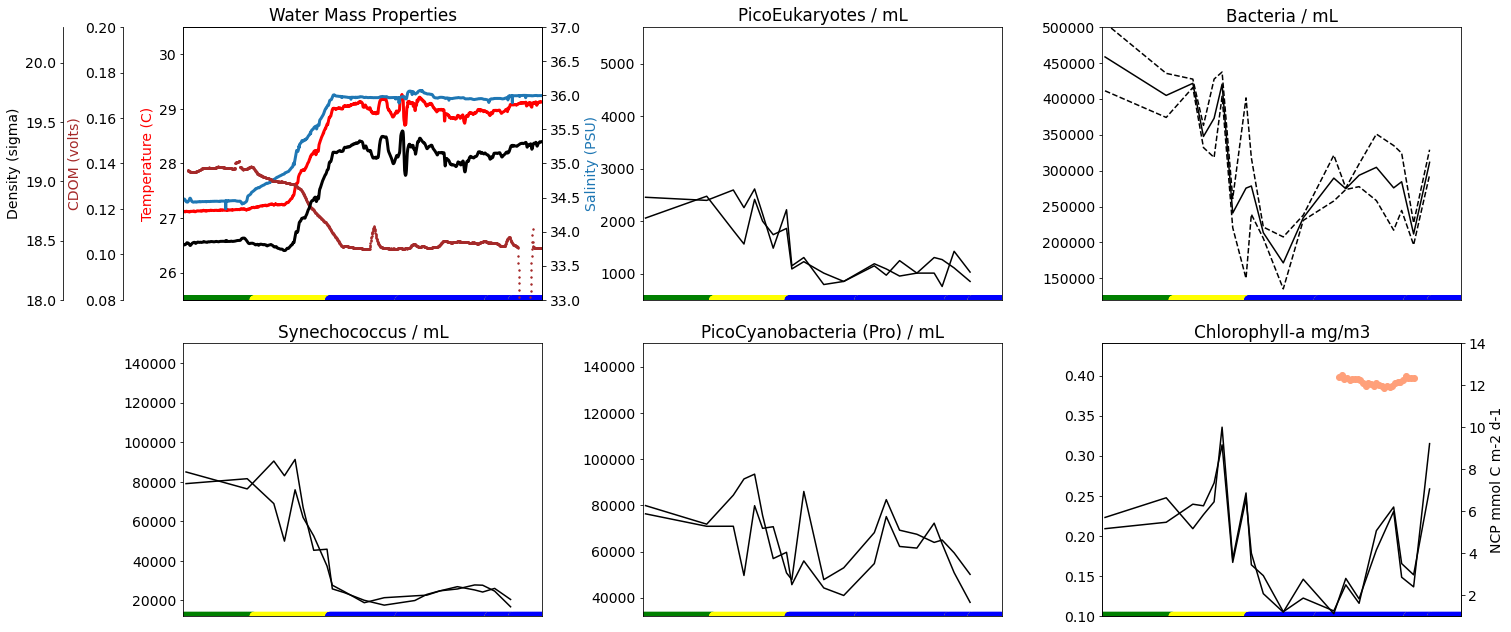

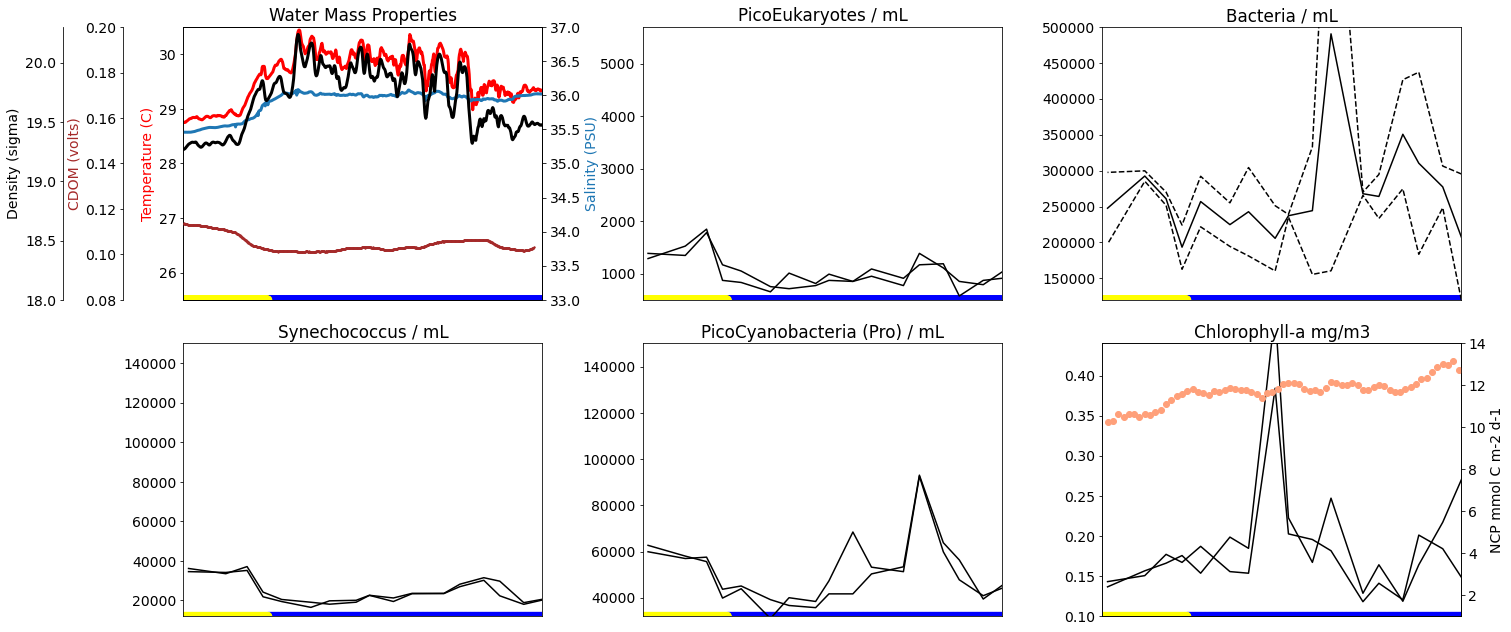

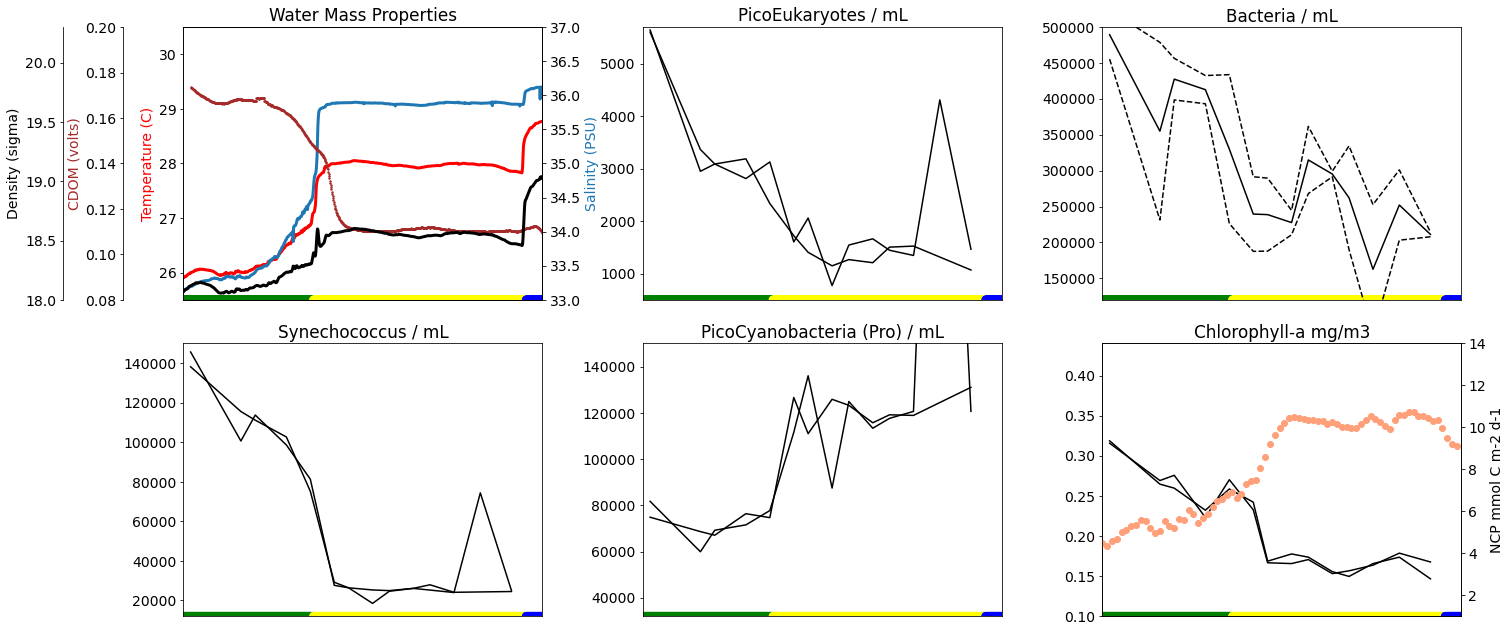

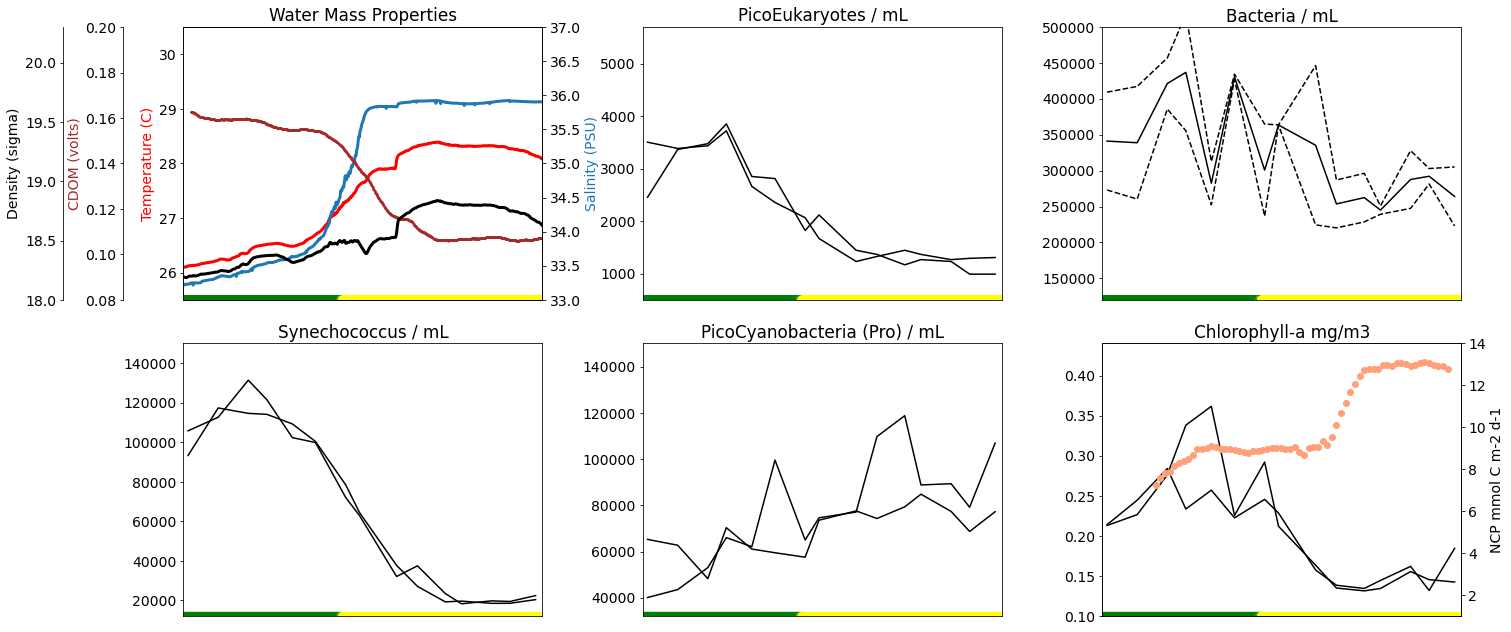

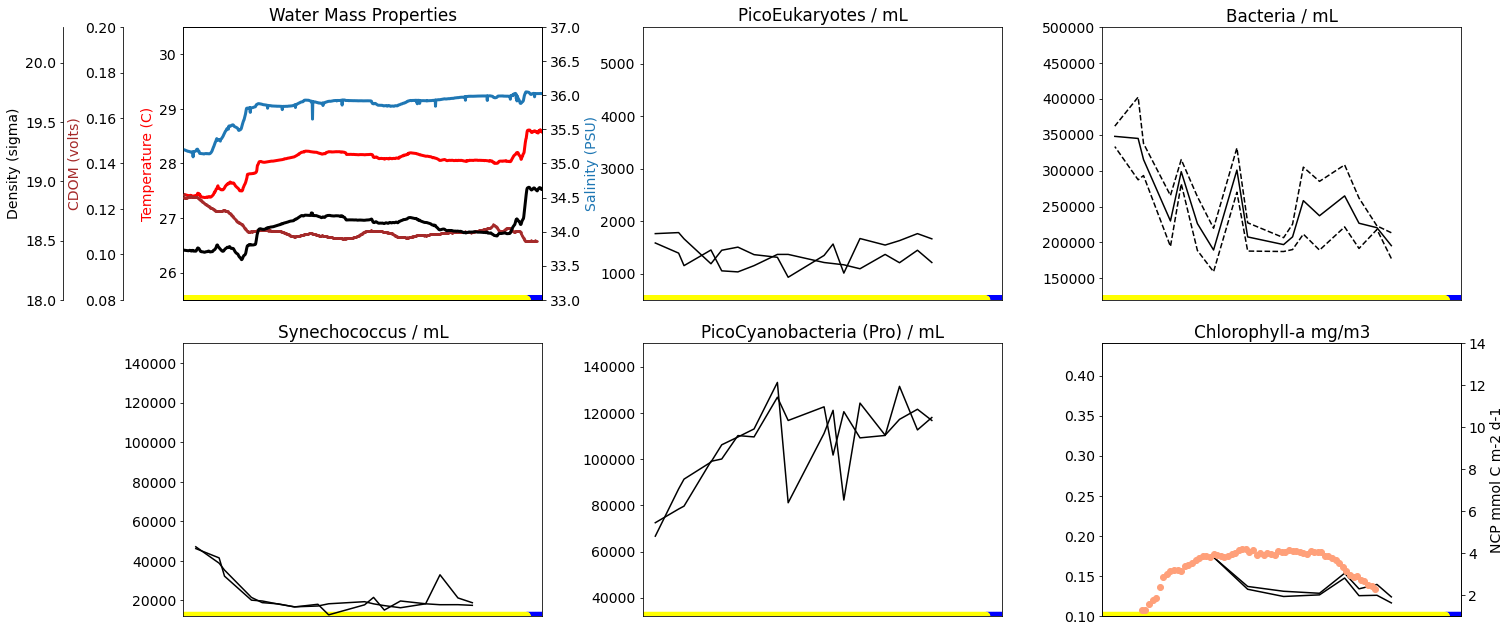

In [308]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

# for i in range(9):
for i in [0,1,4,5,8]:
        # time series plot
        fig = plt.figure(figsize=(27,9))

        gs = fig.add_gridspec(2,4)
        ax = fig.add_subplot(gs[0, 0])
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[0, 1])
        ax5 = fig.add_subplot(gs[1, 1])
        ax6 = fig.add_subplot(gs[0, 2])
        ax7 = fig.add_subplot(gs[1, 2])

        ax1 = ax.twinx()
        ax2 = ax.twinx()
#         ax3 = ax.twinx()
#         ax4 = ax.twinx()
#         ax5 = ax.twinx()
#         ax6 = ax.twinx()
#         ax7 = ax.twinx()
        ax8 = ax7.twinx()
        ax9 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)

        ax2.set_ylim(.08, .2)
        ax3.set_ylim(12000, 150000)
        ax4.set_ylim(500, 5700)
        ax5.set_ylim(32000, 150000)
        ax6.set_ylim(120000, 500000)
        ax7.set_ylim(.1, .44)
        ax8.set_ylim(1, 14)
        ax9.set_ylim(18, 20.3)
        
#         ax.scatter(tsg_df_subset.loc[start_times[i]:end_times[i]].index, len(tsg_df_subset.loc[start_times[i]:end_times[i]].index)*[26]+tsg_df_subset.loc[start_times[i]:end_times[i]].cluster)
        markersize = 60
        ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[25.5],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax3.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[12000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax4.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[500],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax5.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[32000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax6.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[120000],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)
        ax7.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[.1],s=markersize, c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)

        
#         ax.axhline(temp_gs, color='red')
#         ax1.axhline(sal_gs, color='blue')
#         ax1.axhline(sal_only_gs, color='blue', ls='--')
        # salinity
        
#         ax3.set_yscale('log')
#         ax4.set_yscale('log')
#         ax5.set_yscale('log')
#         ax6.set_yscale('log')

#         ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax.set_title("Water Mass Properties")
        ax3.set_title("Synechococcus / mL")
        ax4.set_title("PicoEukaryotes / mL")
        ax5.set_title("PicoCyanobacteria (Pro) / mL")
        ax6.set_title("Bacteria / mL")
        ax7.set_title("Chlorophyll-a mg/m3")
        ax8.set_ylabel('NCP mmol C m-2 d-1')
        ax9.set_ylabel('Density (sigma)')

        for a in [ax,ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
            if i ==0:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==1:
                 a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))
            elif i ==4:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==5:
                a.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
            elif i ==8:
                a.set_xlim(pd.to_datetime(end_times[i]), pd.to_datetime(start_times[i]))

        p1, = ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=3)
        p2, = ax1.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', lw=3)
        p10, = ax9.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)', lw=3, color='black')

        p3 = ax2.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]].rolling(window=20).mean()['cdomVolts'], color='brown', label='CDOM', s=2)

        p4, = ax3.plot(tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynA'].notnull()].loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='k')
        p4, = ax3.plot(tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                       tsg_df[tsg_df['SynB'].notnull()].loc[start_times[i]:end_times[i]]['SynB'], label='Syn/mL', color='k')
        p5, = ax4.plot(tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksA'].notnull()].loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='k')
        p5, = ax4.plot(tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PeuksB'].notnull()].loc[start_times[i]:end_times[i]]['PeuksB'], label='Peuks/mL', color='k')
        p6, = ax5.plot(tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoA'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='k')
        p6, = ax5.plot(tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['PicoCyanoB'].notnull()].loc[start_times[i]:end_times[i]]['PicoCyanoB'], label='PicoCyano/mL', color='k')
        p7, = ax6.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg'], label='Bacteria/mL', color='k')
        p7, = ax6.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg']+tsg_df[tsg_df['BacteriaSD'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaSD'], 
                       label='Bacteria/mL', color='k', ls='--')
        p7, = ax6.plot(tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['BacteriaAvg'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaAvg']-tsg_df[tsg_df['BacteriaSD'].notnull()].loc[start_times[i]:end_times[i]]['BacteriaSD'], 
                       label='Bacteria/mL', color='k', ls='--')
        p8, = ax7.plot(tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaA'].notnull()].loc[start_times[i]:end_times[i]]['ChlaA'], label='Chla mg/m3', color='k')
        p8, = ax7.plot(tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]].index, 
                         tsg_df[tsg_df['ChlaB'].notnull()].loc[start_times[i]:end_times[i]]['ChlaB'], label='Chla mg/m3', color='k')
        p9 = ax8.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['NCP'], label='NCP mmol C m-2 d-1', color='lightsalmon')    
         
        
#         ax.set_title(titles[i])

        lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
#         ax2.spines['right'].set_position(('outward', 50))
        ax2.spines['left'].set_position(('outward', 60))
        ax2.spines['left'].set_visible(True)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')
        ax9.spines['left'].set_position(('outward', 120))
        ax9.spines['left'].set_visible(True)
        ax9.yaxis.set_label_position('left')
        ax9.yaxis.set_ticks_position('left')
#         ax3.spines['right'].set_position(('outward', 160))
#         ax4.spines['right'].set_position(('outward', 250))
#         ax5.spines['right'].set_position(('outward', 345))
#         ax6.spines['right'].set_position(('outward', 440))
#         ax7.spines['right'].set_position(('outward', 540))
#         ax8.spines['right'].set_position(('outward', 640))
#         ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
        ax.xaxis.set_ticks([])
        ax3.xaxis.set_ticks([])
        ax4.xaxis.set_ticks([])
        ax5.xaxis.set_ticks([])
        ax6.xaxis.set_ticks([])
        ax7.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/simplified'+titles[i] +'.png',dpi=300)
    #     plt.close()
        plt.show()
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

AttributeError: 'DataFrame' object has no attribute 'cluster'

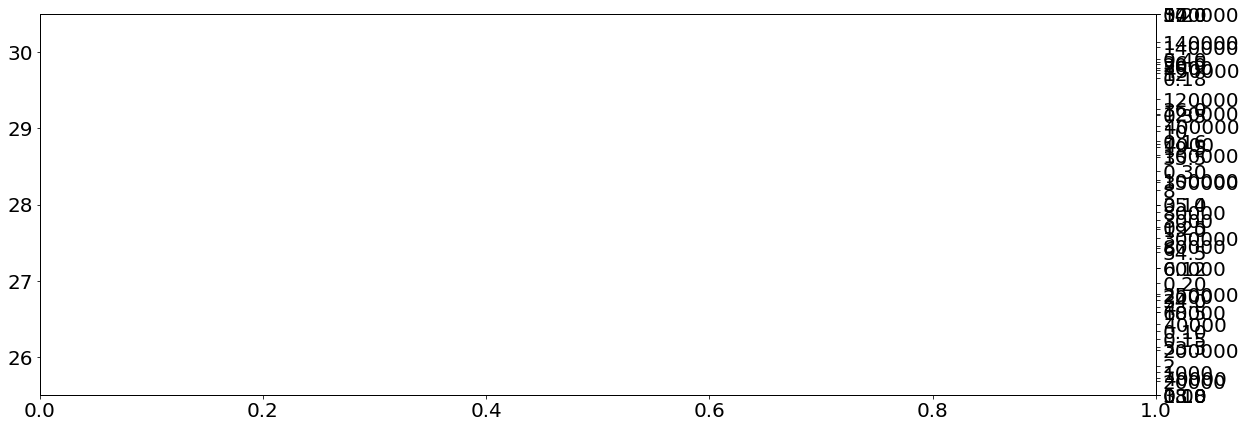

In [461]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

# for i in range(9):
for i in [0,1,4,5,8]:
        # time series plot
        fig, ax = plt.subplots(figsize=(20,7))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()
        ax5 = ax.twinx()
        ax6 = ax.twinx()
        ax7 = ax.twinx()
        ax8 = ax.twinx()
        ax9 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)

        ax2.set_ylim(.08, .2)
        ax3.set_ylim(15000, 150000)
        ax4.set_ylim(700, 5700)
        ax5.set_ylim(35000, 150000)
        ax6.set_ylim(160000, 500000)
        ax7.set_ylim(.1, .44)
        ax8.set_ylim(1, 14)
        ax9.set_ylim(18, 20.3)
        
        ax.scatter(tsg_df_subset.loc[start_times[i]:end_times[i]].index, len(tsg_df_subset.loc[start_times[i]:end_times[i]].index)*[26]+tsg_df_subset.loc[start_times[i]:end_times[i]].cluster)
        
        ax.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, len(tsg_df.loc[start_times[i]:end_times[i]].index)*[30], c=tsg_df.loc[start_times[i]:end_times[i]]['water_mass_color'].values)

        
        ax.axhline(temp_gs, color='red')
        ax1.axhline(sal_gs, color='blue')
        ax1.axhline(sal_only_gs, color='blue', ls='--')
        # salinity
    
        ax.set_xlim(pd.to_datetime(start_times[i]),pd.to_datetime(end_times[i]))
        
        ax3.set_yscale('log')
        ax4.set_yscale('log')
        ax5.set_yscale('log')
        ax6.set_yscale('log')

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Syn/mL")
        ax4.set_ylabel("Peuks/mL")
        ax5.set_ylabel("PicoCyano/mL")
        ax6.set_ylabel("Bacteria/mL")
        ax7.set_ylabel("Chla mg/m3")
        ax8.set_ylabel('NCP mmol C m-2 d-1')
        ax9.set_ylabel('Density (sigma)')

        p1, = ax.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=3)
        p2, = ax1.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', lw=3)
        p10, = ax9.plot(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['sigma'], label='Density (sigma)', lw=3, color='black')

        p3 = ax2.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]].rolling(window=5).mean()['cdomVolts'], color='brown', label='CDOM', s=2)

        p4 = ax3.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['SynA'], label='Syn/mL', color='purple')
        p5 = ax4.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['PeuksA'], label='Peuks/mL', color='yellow')
        p6 = ax5.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['PicoCyanoA'], label='PicoCyano/mL', color='blue')
        p7 = ax6.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['BacteriaAvg'], label='Bacteria/mL', color='grey')
        p8 = ax7.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['ChlaAvg'], label='Chla mg/m3', color='green')    
        p9 = ax8.scatter(tsg_df.loc[start_times[i]:end_times[i]].index, tsg_df.loc[start_times[i]:end_times[i]]['NCP'], label='NCP mmol C m-2 d-1', color='lightsalmon')    
         
        
#         ax.set_title(titles[i])

        lns = [p1, p2, p3, p4,p5,p6,p7,p8, p9]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 80))
        ax3.spines['right'].set_position(('outward', 160))
        ax4.spines['right'].set_position(('outward', 250))
        ax5.spines['right'].set_position(('outward', 345))
        ax6.spines['right'].set_position(('outward', 440))
        ax7.spines['right'].set_position(('outward', 540))
        ax8.spines['right'].set_position(('outward', 640))
        ax9.spines['right'].set_position(('outward', 740))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
#         ax3.yaxis.label.set_color(p4.get_color())
#         ax4.yaxis.label.set_color(p5.get_color())
#         ax5.yaxis.label.set_color(p6.get_color())
#         ax6.yaxis.label.set_color(p7.get_color())
#         ax7.yaxis.label.set_color(p8.get_color())
#         ax8.yaxis.label.set_color(p9.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
#         fig, ax = plt.subplots(figsize=(10,8))
#         sc = ax.scatter(df.loc[start_times[i]:end_times[i]]['TSG--sal'],  df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], alpha=0.8,c=df.loc[start_times[i]:end_times[i]]['lon'], cmap='cividis', label='chla')
#         ax.set_xlim(33,37)
#         ax.set_ylim(25,31)
        
#         ax.set_xlabel("Salinity")
#         ax.set_ylabel("Temperature")
#         ax.axvline(35.7)
#         ax.axvline(34.5)

#         fig.savefig('figs/s_t_diagram'+titles[i] +'.png')
#         fig.colorbar(sc)

In [529]:
tsg_df_subset = tsg_df.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00']

In [530]:
start_times

['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 1:00:00',
 '2021-09-6 5:10:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 2:55:00',
 '2021-09-7 6:45:00',
 '2021-09-7 12:10:00']

In [531]:
end_times

['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 4:00:00',
 '2021-09-6 6:45:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 5:35:00',
 '2021-09-7 9:00:00',
 '2021-09-7 15:30:00']

In [532]:
start_times = ['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

In [533]:
start_times = ['2021-09-5 13:00:00',
 '2021-09-5 18:15:00',
 '2021-09-6 12:30:00',
 '2021-09-6 16:45:00',
 '2021-09-7 12:10:00']

end_times = ['2021-09-5 17:30:00',
 '2021-09-5 20:30:00',
 '2021-09-6 15:00:00',
 '2021-09-6 19:20:00',
 '2021-09-7 15:30:00']

dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [534]:
start_times,end_times

(['2021-09-5 13:00:00',
  '2021-09-5 18:15:00',
  '2021-09-6 12:30:00',
  '2021-09-6 16:45:00',
  '2021-09-7 12:10:00'],
 ['2021-09-5 17:30:00',
  '2021-09-5 20:30:00',
  '2021-09-6 15:00:00',
  '2021-09-6 19:20:00',
  '2021-09-7 15:30:00'])

In [535]:
dfs = []
for i in range(len(start_times)):
    dfs.append(tsg_df.loc[start_times[i]:end_times[i]])
tsg_df_subset = pd.concat(dfs)

In [536]:
tsg_df_subset.head()

DateTime     Temp      Sal  Unknown  \
utc_dt                                                                         
2021-09-05 13:00:02.032  09/05/2021,13:00:02.032,  27.1116  34.4627  1539.08   
2021-09-05 13:00:12.016  09/05/2021,13:00:12.016,  27.1116  34.4658  1539.09   
2021-09-05 13:00:22.026  09/05/2021,13:00:22.026,  27.1122  34.4724  1539.09   
2021-09-05 13:00:32.035  09/05/2021,13:00:32.035,  27.1167  34.4759  1539.11   
2021-09-05 13:00:42.042  09/05/2021,13:00:42.042,  27.1207  34.4767  1539.12   

                                       datetime        lat        lon  \
utc_dt                                                                  
2021-09-05 13:00:02.032 2021-09-05 13:00:02.032  35.648912 -74.874555   
2021-09-05 13:00:12.016 2021-09-05 13:00:12.016  35.649203 -74.874498   
2021-09-05 13:00:22.026 2021-09-05 13:00:22.026  35.649493 -74.874520   
2021-09-05 13:00:32.035 2021-09-05 13:00:32.035  35.649742 -74.874615   
2021-09-05 13:00:42.042 2021-09-05 13:00:42.042  35.649985 -74.874792   

                                           geometry  SynA  PeuksA  ...  NO3a  \
utc_dt                                                             ...         
2021-09-05 13:00:02.032  POINT (-74.87456 35.64891)   NaN     NaN  ...   NaN   
2021-09-05 13:00:12.016  POINT (-74.87450 35.64920)   NaN     NaN  ...   NaN   
2021-09-05 13:00:22.026  POINT (-74.87452 35.64949)   NaN     NaN  ...   NaN   
2021-09-05 13:00:32.035  POINT (-74.87462 35.64974)   NaN     NaN  ...   NaN   
2021-09-05 13:00:42.042  POINT (-74.87479 35.64999)   NaN     NaN  ...   NaN   

                         PO4a  SILa  NO2a  NH4a  NO3b PO4b SILb  NO2b  NH4b  
utc_dt                                                                       
2021-09-05 13:00:02.032   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:12.016   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:22.026   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:32.035   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  
2021-09-05 13:00:42.042   NaN   NaN   NaN   NaN   NaN  NaN  NaN   NaN   NaN  

[5 rows x 39 columns]

In [537]:
len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df_subset['water_mass']=='shelf']),len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df_subset['water_mass']=='eddy']),len(tsg_df_subset[tsg_df_subset['SynA'].notnull()][tsg_df['water_mass']=='gulfstream'])

(23, 34, 25)

In [538]:
# columns_to_plot = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']
# scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']

# fig, ax = plt.subplots(len(columns_to_plot),1, figsize=(8,20))


# for i, water_mass in enumerate(['shelf', 'eddy', 'gulfstream']):
#     for j, col in enumerate(columns_to_plot):
#         ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col]), color='black')
#         ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col])+np.std(tsg_df[tsg_df.water_mass == water_mass][col]), color='grey')
#         ax[j].scatter(i, np.mean(tsg_df[tsg_df.water_mass == water_mass][col])-np.std(tsg_df[tsg_df.water_mass == water_mass][col]), color='grey')
#         ax[j].set_yscale(scale_to_plot[j])
#         ax[j].set_ylabel(col)

In [539]:
tsg_df_subset.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg',
       'cdomVolts', 'NCP', 'sigma', 'water_mass', 'water_mass_color',
       'water_mass_code', 'SynB', 'PeuksB', 'PicoCyanoB', 'BacteriaSD',
       'ChlaA', 'ChlaB', 'sigma_grad', 'NCPm2', 'NCPm3', 'MLD', 'NO3a', 'PO4a',
       'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b'],
      dtype='object')

In [73]:
from random import uniform

def rand_jitter(v):
    jittered = []
    for x in v:
        jittered.append(uniform(x-0.05, x+0.05))
    return(jittered)

In [67]:
nuts_df.columns

Index(['Station', 'NO3a', 'PO4a', 'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b',
       'SILb', 'NO2b', 'NH4b', 'Time (UTC)', 'Date', 'datetime'],
      dtype='object')

(array([ 77., 112.,  41.,  14.,  19.,  15.,   4.,   3.,   8.,   8.]),
 array([0.06049153, 0.22833085, 0.39617016, 0.56400948, 0.7318488 ,
        0.89968812, 1.06752744, 1.23536676, 1.40320608, 1.5710454 ,
        1.73888471]),
 <BarContainer object of 10 artists>)

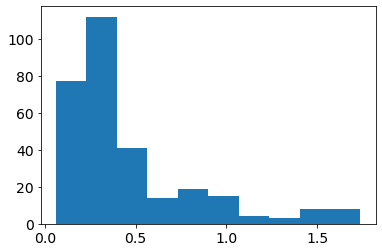

In [71]:
plt.hist(tsg_df_subset.NCPm3)

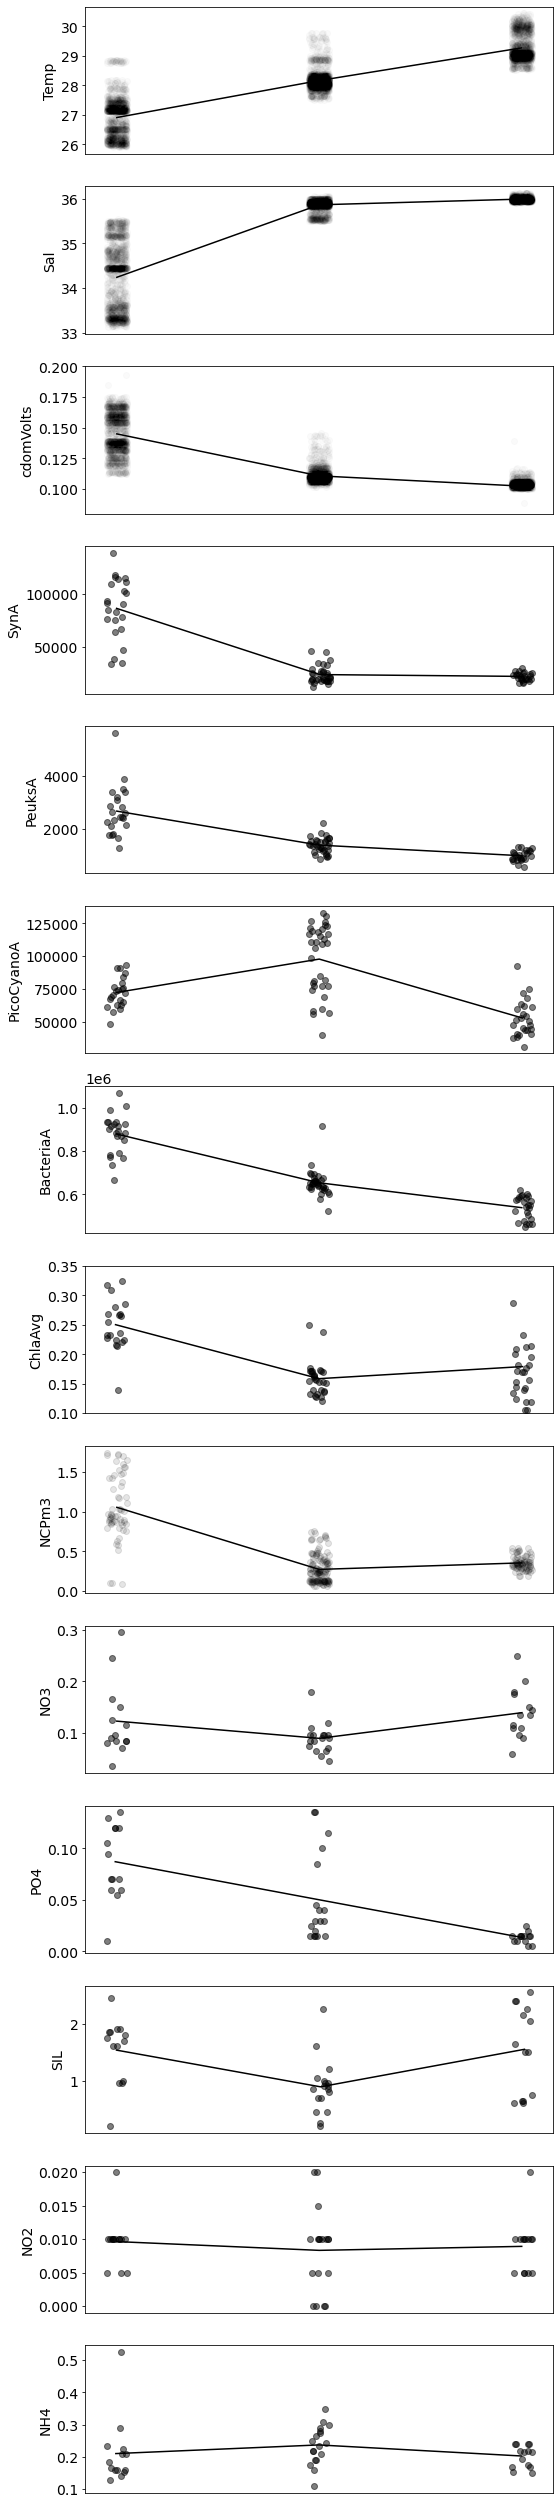

In [72]:
columns_to_plot = ['Temp', 'Sal', 'cdomVolts', 'SynA','PeuksA', 'PicoCyanoA', 'BacteriaA', 'ChlaAvg', 'NCPm3','NO3', 'PO4', 'SIL', 'NO2', 'NH4']
scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']
alpha_to_plot = [.02,.02,.02,.5,.5,.5,.5,.5,.1,.5,.5,.5,.5,.5]

fig, ax = plt.subplots(len(columns_to_plot),1, figsize=(8,35))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot):
        if col in ['NO3', 'PO4', 'SIL', 'NO2', 'NH4']:
            ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col+'a'])*[i])), 
                          (tsg_df_subset[tsg_df_subset.water_mass == water_mass][col+'a']+tsg_df_subset[tsg_df_subset.water_mass == water_mass][col+'b'])/2.0, 
                          color='black', alpha=alpha_to_plot[j])

        else:
            ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i])), tsg_df_subset[tsg_df_subset.water_mass == water_mass][col], color='black', alpha=alpha_to_plot[j])
        
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot):
    means = []
    for wm in water_masses:
        if col in ['NO3', 'PO4', 'SIL', 'NO2', 'NH4']:
            means.append((np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col+'a'])+np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col+'b']))/2)
        else:
            means.append(np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

ax[4+3].set_ylim(0.1,0.35)
ax[2].set_ylim(0.08,0.2)
fig.tight_layout()
# fig.savefig('fcm_trends_across_features.png',dpi=600)

In [69]:
for i in optical_df.columns:
#     print(i)
    pass

In [111]:
acs_wavelength[36]

555.3

In [78]:
optical_df_quality.HH_G50

utc_dt
2021-09-05 14:20:00     5.290850
2021-09-05 14:22:00    10.559948
2021-09-05 14:24:00     9.710914
2021-09-05 14:26:00    10.888990
2021-09-05 14:28:00     9.468042
                         ...    
2021-09-07 15:22:00     7.154922
2021-09-07 15:24:00     7.254366
2021-09-07 15:26:00     7.385684
2021-09-07 15:28:00     6.660247
2021-09-07 15:30:00     4.271988
Name: HH_G50, Length: 586, dtype: float64

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

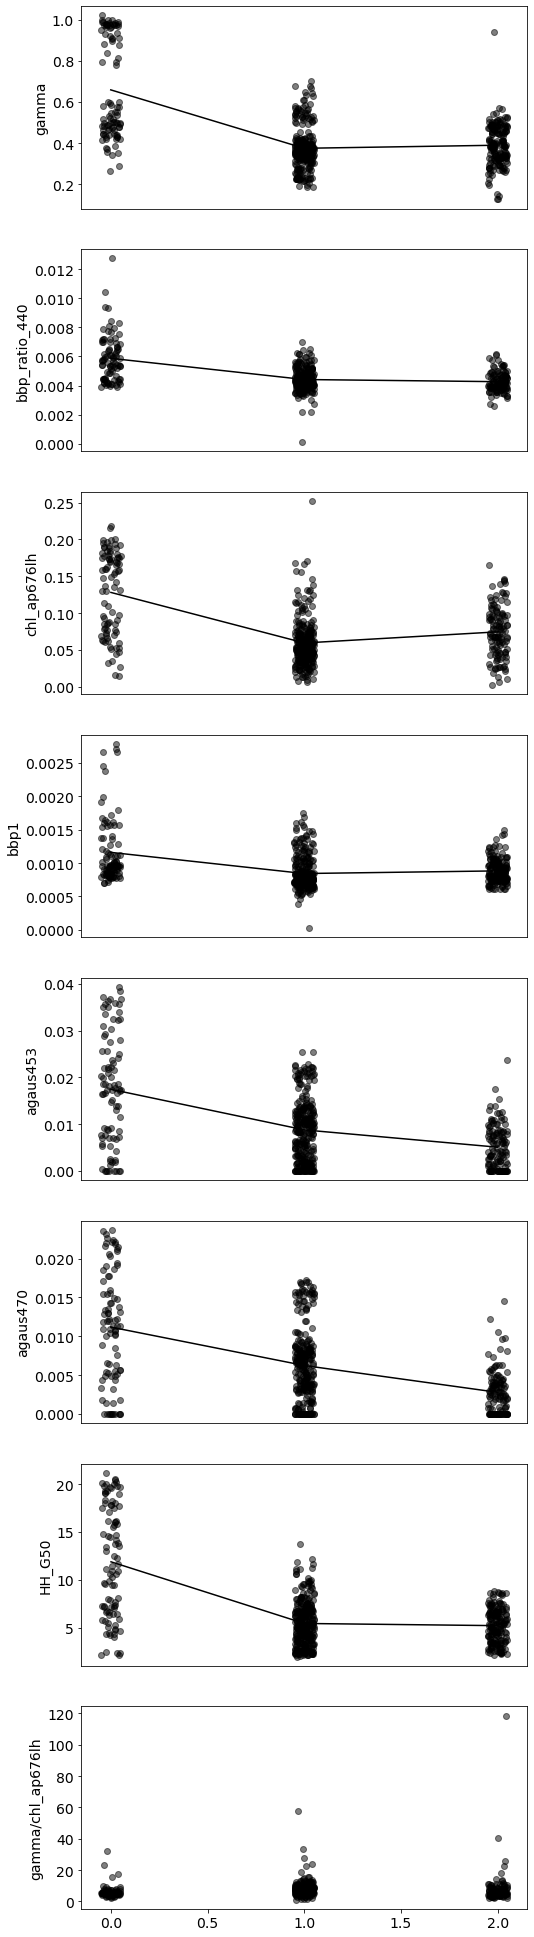

In [83]:
columns_to_plot = ['gamma', 'bbp_ratio_440', 'chl_ap676lh', 'bbp1','agaus453', 'agaus470', 'HH_G50']
#scale_to_plot = ['log','log', 'log', 'log', 'linear', 'linear', 'linear']
#alpha_to_plot = [.02,.02,.02,.5,.5,.5,.5,.5,.1,.5,.5,.5,.5,.5]
alpha=0.5

fig, ax = plt.subplots(len(columns_to_plot)+1,1, figsize=(8,35))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot):
        ax[j].scatter(rand_jitter(np.array(len(optical_df_quality[optical_df_quality.water_mass == water_mass][col])*[i])), optical_df_quality[optical_df_quality.water_mass == water_mass][col], color='black', alpha=alpha)
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for i, water_mass in enumerate(water_masses):
        ax[j+1].scatter(rand_jitter(np.array(len(optical_df_quality[optical_df_quality.water_mass == water_mass][col])*[i])), optical_df_quality[optical_df_quality.water_mass == water_mass].gamma/optical_df_quality[optical_df_quality.water_mass == water_mass].chl_ap676lh, color='black', alpha=alpha)
        ax[j+1].set_yscale('linear')#scale_to_plot[j])
        ax[j+1].set_ylabel('gamma/chl_ap676lh')
        
for j, col in enumerate(columns_to_plot):
    means = []
    for wm in water_masses:
        means.append(np.nanmean(optical_df_quality[optical_df_quality.water_mass == wm][col]))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

means = []
for wm in water_masses:
#     means.append(np.mean(optical_df[optical_df.water_mass == wm].gamma/optical_df[optical_df.water_mass == wm].chl_ap676lh))
    pass
ax[j+1].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
ax[j+1].xaxis.set_ticks([])


# ax[4+3].set_ylim(0.1,0.35)
# ax[2].set_ylim(0.08,0.2)
fig.tight_layout()
# fig.savefig('optical_fcm_trends_across_features.png',dpi=600)

In [85]:
len(np.arange(399,750,4.35))

81

In [95]:
optical_df_subset.iloc[:,1:82].mean(axis=0)

ap_1     0.007413
ap_2     0.012232
ap_3     0.013837
ap_4     0.014761
ap_5     0.014505
           ...   
ap_77    0.000079
ap_78    0.000015
ap_79    0.000367
ap_80   -0.000035
ap_81   -0.000073
Length: 81, dtype: float64

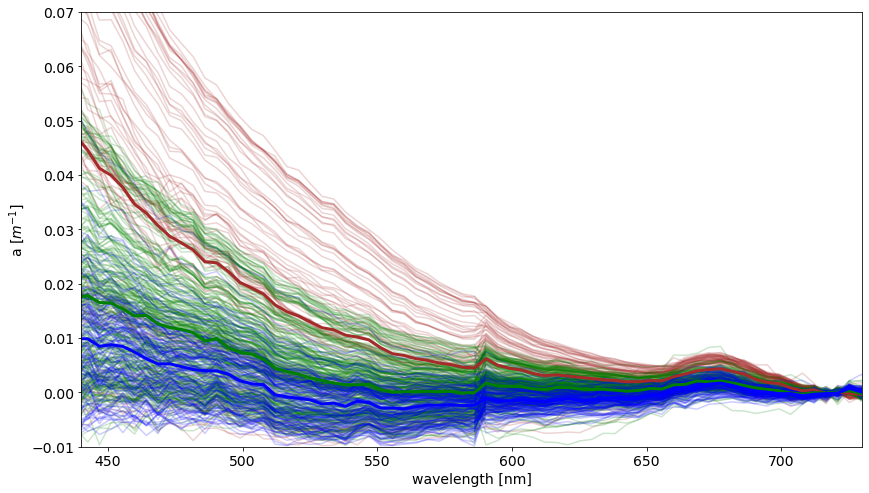

In [71]:
fig, ax = plt.subplots(figsize=(14,8))
wm_colors = ['brown', 'green', 'blue']
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    for i in range(len(optical_df_subset)):
        if ~optical_df_subset.iloc[i,1:82].isnull().values.all():
            ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[i,1:82].rolling(window=1, win_type='triang').mean(), c=wm_colors[idx], alpha=.2)
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[:,1:82].mean(axis=0), c=wm_colors[idx], alpha=1, lw=3)
ax.set_ylim(-0.01,.07)
ax.set_xlim(440,730)
#ax.set_title('Particulate Abs')
ax.set_ylabel('a [$m^{-1}$]')
ax.set_xlabel('wavelength [nm]')  
# plt.title('Absorption colored by time (brown to blue) across a coastal to open ocean transect')
# plt.savefig('figs/watermasses_a_spec.png', dpi=300)
plt.show()

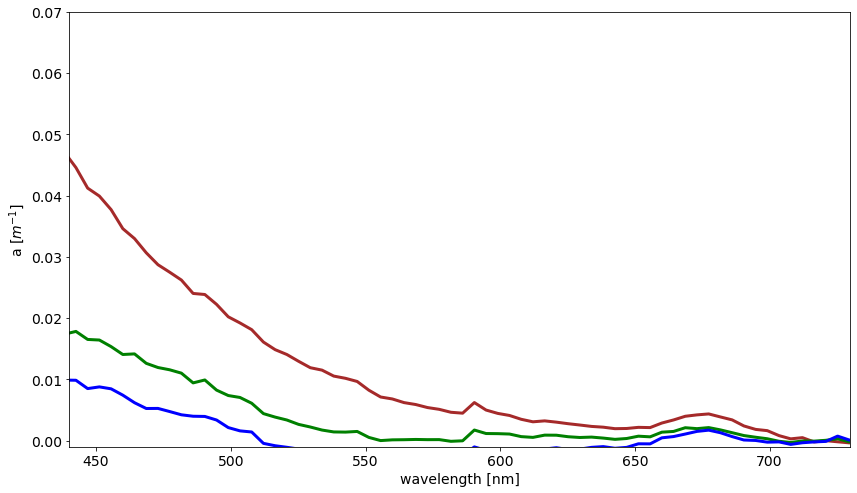

In [70]:
fig, ax = plt.subplots(figsize=(14,8))
wm_colors = ['brown', 'green', 'blue']
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    for i in range(len(optical_df_subset)):
        if ~optical_df_subset.iloc[i,1:82].isnull().values.all():
            #ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[i,1:82].rolling(window=1, win_type='triang').mean(), c=wm_colors[idx], alpha=.2)
            pass
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[:,1:82].mean(axis=0), c=wm_colors[idx], alpha=1, lw=3)
ax.set_ylim(-0.001,.07)
ax.set_xlim(440,730)
#ax.set_title('Particulate Abs')
ax.set_ylabel('a [$m^{-1}$]')
ax.set_xlabel('wavelength [nm]')  
# plt.title('Absorption colored by time (brown to blue) across a coastal to open ocean transect')
# plt.savefig('figs/watermasses_a_spec_means.png', dpi=300)
plt.show()

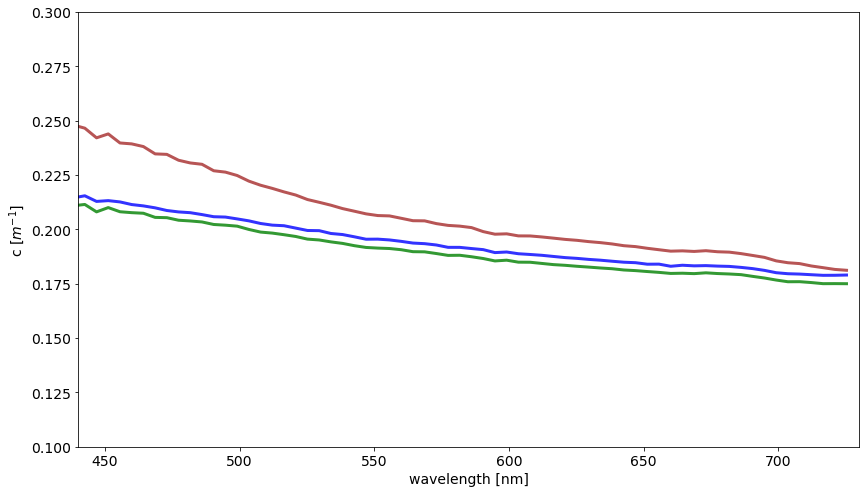

In [68]:
fig, ax = plt.subplots(figsize=(14,8))
wm_colors = ['brown', 'green', 'blue']
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    for i in range(len(optical_df_subset)):
        if ~optical_df_subset.iloc[i,1+81:82+81].isnull().values.all():
            #ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[i,1+81:82+81].rolling(window=1, win_type='triang').mean(), c=wm_colors[idx], alpha=.2)
            pass
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[:,1+81:82+81].mean(axis=0), c=wm_colors[idx], alpha=.8, lw=3)
ax.set_ylim(0.1,.3)
ax.set_xlim(440,730)
#ax.set_title('Particulate Abs')
ax.set_ylabel('c [$m^{-1}$]')
ax.set_xlabel('wavelength [nm]')  
# plt.title('Absorption colored by time (brown to blue) across a coastal to open ocean transect')
# plt.savefig('figs/watermasses_c_spec_means.png', dpi=300)
plt.show()

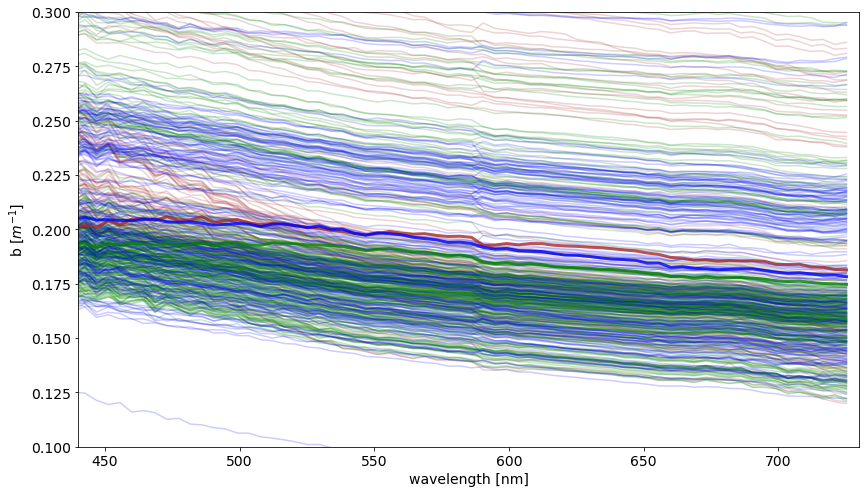

In [69]:
fig, ax = plt.subplots(figsize=(14,8))
wm_colors = ['brown', 'green', 'blue']
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    for i in range(len(optical_df_subset)):
        if ~optical_df_subset.iloc[i,1+81:82+81].isnull().values.all():
            ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[i,1+81:82+81].rolling(window=1, win_type='triang').mean(), c=wm_colors[idx], alpha=.2)
for idx, wm in enumerate(['shelf', 'eddy', 'gulfstream']):
    optical_df_subset = optical_df_quality[optical_df_quality.water_mass == wm]
    ax.plot(np.arange(399,750,4.35),optical_df_subset.iloc[:,1+81:82+81].mean(axis=0).values-optical_df_subset.iloc[:,1:82].mean(axis=0).values, c=wm_colors[idx], alpha=.8, lw=3)
ax.set_ylim(0.1,.3)
ax.set_xlim(440,730)
#ax.set_title('Particulate Abs')
ax.set_ylabel('b [$m^{-1}$]')
ax.set_xlabel('wavelength [nm]')  
# plt.title('Absorption colored by time (brown to blue) across a coastal to open ocean transect')
# plt.savefig('figs/watermasses_b_spec.png', dpi=300)
plt.show()

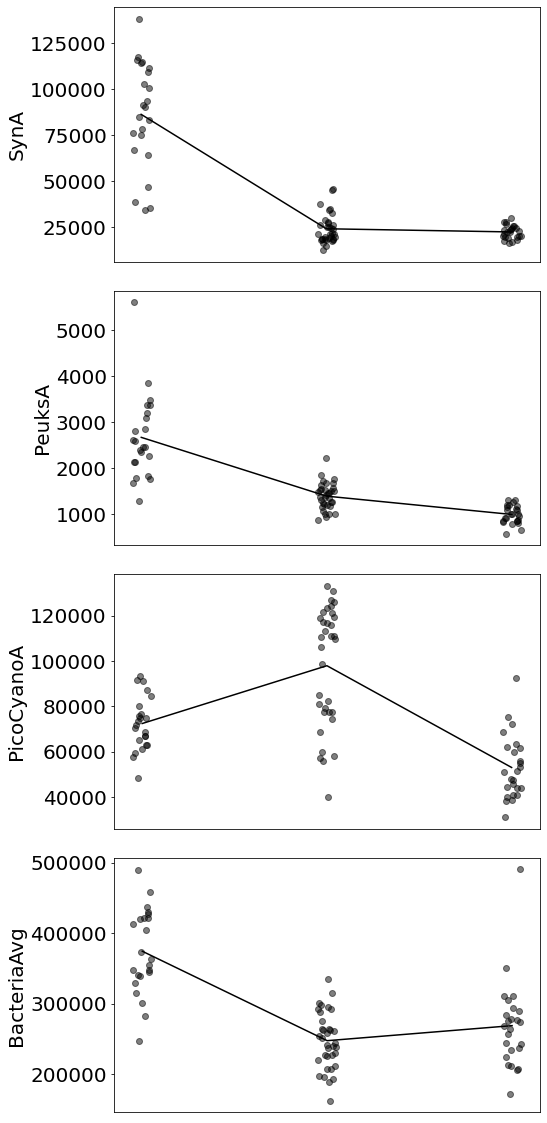

In [467]:
columns_to_plot_normed = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg']
alpha_to_plot_normed = [.5,.5,.5,.5]

fig, ax = plt.subplots(len(columns_to_plot_normed),1, figsize=(8,16))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot_normed):
        ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i])), tsg_df_subset[tsg_df_subset.water_mass == water_mass][col], color='black', alpha=alpha_to_plot_normed[j])
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot_normed):
    means = []
    for wm in water_masses:
        means.append(np.mean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

# ax[0].set_ylim(0,150000)
# ax[1].set_ylim(0,6000)
# ax[2].set_ylim(0,140000)
# ax[3].set_ylim(0,550000)

fig.tight_layout()
fig.savefig('fcm_trends_across_features_unnormalized.png',dpi=600)

In [414]:
means

[nan, nan, 1644652.1787075961]

In [438]:
np.unique(tsg_df_subset.water_mass)

array(['eddy', 'gulfstream', 'shelf'], dtype=object)

array([0.1692 , 0.2502 , 0.17145, 0.1717 , 0.1537 , 0.23745, 0.1677 ,
       0.1717 , 0.1722 , 0.15445, 0.1532 , 0.1647 , 0.1762 , 0.1572 ,
       0.1607 , 0.13695, 0.1332 , 0.1397 , 0.15895, 0.13895, 0.1637 ,
       0.12045, 0.13295, 0.12995, 0.1507 , 0.1277 , 0.12795, 0.13545,
       0.1737 ])

In [469]:
tsg_df_subset.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg',
       'cdomVolts', 'NCP', 'sigma', 'water_mass', 'water_mass_color',
       'water_mass_code', 'SynB', 'PeuksB', 'PicoCyanoB', 'BacteriaSD',
       'ChlaA', 'ChlaB', 'sigma_grad', 'NCPm2', 'NCPm3', 'MLD'],
      dtype='object')

In [471]:
from scipy.stats import mannwhitneyu
# compare samples
for target in ['Temp', 'Sal', 'cdomVolts', 'SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg','ChlaAvg', 'NCP']:
    dist1 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'eddy'][target].values
    dist2 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'gulfstream'][target].values

    stat, p = mannwhitneyu(dist1,dist2)
    # stat, p = mannwhitneyu([1,2,3,0], [2,3,4,5,6])
    print('\n-----------'+target+'-----------')
    print('Statistics=%.3f, p=%.9f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


-----------Temp-----------
Statistics=193964.000, p=0.000000000
Different distribution (reject H0)

-----------Sal-----------
Statistics=455093.500, p=0.000000000
Different distribution (reject H0)

-----------cdomVolts-----------
Statistics=579820.000, p=0.000000000
Different distribution (reject H0)

-----------SynA-----------
Statistics=416.000, p=0.448130540
Same distribution (fail to reject H0)

-----------PeuksA-----------
Statistics=103.500, p=0.000000420
Different distribution (reject H0)

-----------PicoCyanoA-----------
Statistics=67.000, p=0.000000021
Different distribution (reject H0)

-----------BacteriaAvg-----------
Statistics=346.000, p=0.086210300
Same distribution (fail to reject H0)

-----------ChlaAvg-----------
Statistics=299.500, p=0.139113720
Same distribution (fail to reject H0)

-----------NCP-----------
Statistics=3997.000, p=0.000000000
Different distribution (reject H0)


In [473]:
from scipy.stats import mannwhitneyu
# compare samples
for target in ['Temp', 'Sal', 'cdomVolts', 'SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg','ChlaAvg', 'NCP']:
    dist1 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'eddy'][target].values
    dist2 = tsg_df_subset[tsg_df_subset[target].notnull()][tsg_df_subset.water_mass == 'shelf'][target].values

    stat, p = mannwhitneyu(dist1,dist2)
    # stat, p = mannwhitneyu([1,2,3,0], [2,3,4,5,6])
    print('\n-----------'+target+'-----------')
    print('Statistics=%.3f, p=%.9f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


-----------Temp-----------
Statistics=340201.500, p=0.000000000
Different distribution (reject H0)

-----------Sal-----------
Statistics=188.000, p=0.000000000
Different distribution (reject H0)

-----------cdomVolts-----------
Statistics=154063.500, p=0.000000000
Different distribution (reject H0)

-----------SynA-----------
Statistics=9.000, p=0.000000000
Different distribution (reject H0)

-----------PeuksA-----------
Statistics=35.000, p=0.000000004
Different distribution (reject H0)

-----------PicoCyanoA-----------
Statistics=169.000, p=0.000157370
Different distribution (reject H0)

-----------BacteriaAvg-----------
Statistics=30.000, p=0.000000002
Different distribution (reject H0)

-----------ChlaAvg-----------
Statistics=37.000, p=0.000000140
Different distribution (reject H0)

-----------NCP-----------
Statistics=6461.000, p=0.000001520
Different distribution (reject H0)


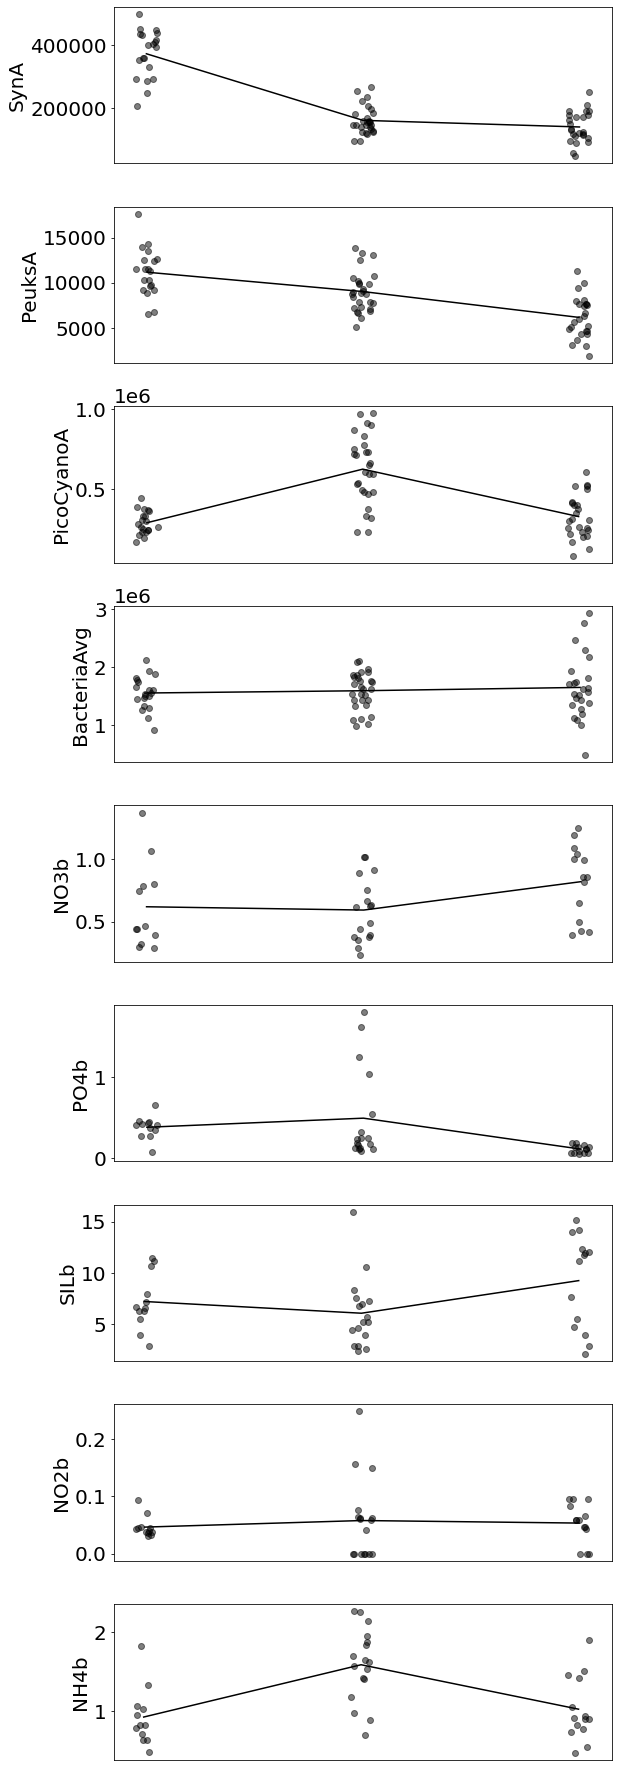

In [570]:
columns_to_plot_normed = ['SynA','PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b']
alpha_to_plot_normed = [.5,.5,.5,.5,.5,.5,.5,.5,.5]

fig, ax = plt.subplots(len(columns_to_plot_normed),1, figsize=(9,25))

water_masses = ['shelf', 'eddy', 'gulfstream']

for i, water_mass in enumerate(water_masses):
    for j, col in enumerate(columns_to_plot_normed):
        ax[j].scatter(rand_jitter(np.array(len(tsg_df_subset[tsg_df.water_mass == water_mass][col])*[i])), tsg_df_subset[tsg_df_subset.water_mass == water_mass][col]/tsg_df_subset[tsg_df_subset.water_mass == water_mass]['ChlaAvg'], color='black', alpha=alpha_to_plot_normed[j])
        ax[j].set_yscale('linear')#scale_to_plot[j])
        ax[j].set_ylabel(col)
        
for j, col in enumerate(columns_to_plot_normed):
    means = []
    for wm in water_masses:
        means.append(np.nanmean(tsg_df_subset[tsg_df_subset.water_mass == wm][col]/tsg_df_subset[tsg_df_subset.water_mass == wm]['ChlaAvg']))
    ax[j].plot([0,1,2], means, color='black', alpha=1)#, marker='o', markerfacecolor='None', markersize=10)
    ax[j].xaxis.set_ticks([])

# ax[0].set_ylim(0,150000*5)
# ax[1].set_ylim(0,6000*5)
# ax[2].set_ylim(0,140000*5)
# ax[3].set_ylim(0,550000*5)
fig.tight_layout()
# fig.savefig('fcm_trends_across_features_normalized.png',dpi=600)

In [69]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [70]:
columns_to_plot

['SynA', 'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP']

In [82]:
# Create linear regression object
regr = linear_model.LinearRegression()

target='PicoCyanoA'

X = tsg_df_subset[tsg_df_subset[target].notnull()][['Temp', 'Sal', 'water_mass_code']].values
# X = tsg_df_subset[tsg_df_subset['SynA'].notnull()][['Temp', 'Sal']].values

y = tsg_df_subset[tsg_df_subset[target].notnull()][target].values

# Train the model using the training sets
regr.fit(X, y)

LinearRegression()

In [83]:
X.shape, y.shape

((82, 3), (82,))

In [84]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
# x = StandardScaler().fit_transform(x)

Coefficients: 
 [-25605.79666629  42632.6961041  -18160.30565242]
Mean squared error: 15924.00
Coefficient of determination: 0.66


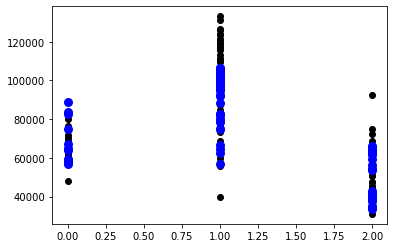

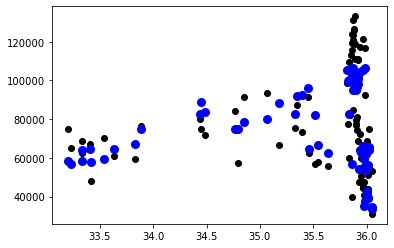

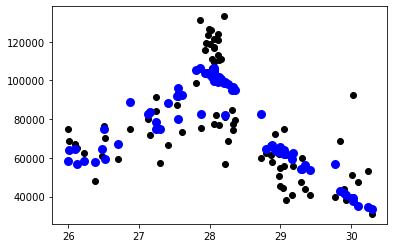

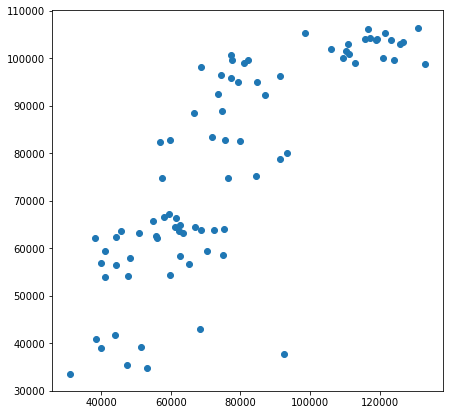

In [86]:
# Make predictions using the testing set
y_pred = regr.predict(X)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

# Plot outputs
plt.scatter(X[:,2], y, color="black")
plt.scatter(X[:,2], y_pred, color="blue", linewidth=3)
plt.show()

# Plot outputs
plt.scatter(X[:,1], y, color="black")
plt.scatter(X[:,1], y_pred, color="blue", linewidth=3)
plt.show()

# Plot outputs
plt.scatter(X[:,0], y, color="black")
plt.scatter(X[:,0], y_pred, color="blue", linewidth=3)
plt.show()

fig,ax=plt.subplots(figsize=(7,7))
plt.scatter(y, y_pred)
plt.show()
# plt.xticks(())
# plt.yticks(())



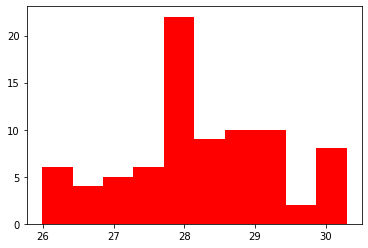

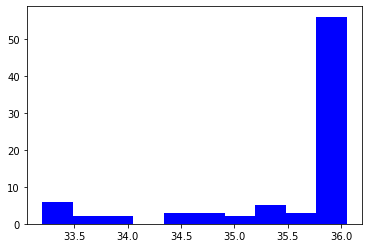

In [324]:
plt.hist(X[:,0], color='red')
plt.show()
plt.hist(X[:,1], color='blue')
plt.show()
# plt.hist(X[:,2], color='brown')
# plt.show()

In [370]:
! pip install pygam

     |████████████████████████████████| 1.8 MB 1.5 MB/s eta 0:00:01


In [393]:
tsg_df.columns

Index(['Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon', 'geometry', 'SynA',
       'PeuksA', 'PicoCyanoA', 'BacteriaAvg', 'ChlaAvg', 'cdomVolts', 'NCP',
       'sigma', 'water_mass'],
      dtype='object')

In [271]:
target='PeuksA'

X = tsg_df_subset[tsg_df_subset[target].notnull()][['Temp', 'Sal', 'water_mass_code']].values
# X = tsg_df_subset[tsg_df_subset['SynA'].notnull()][['Temp', 'Sal']].values

y = tsg_df_subset[tsg_df_subset[target].notnull()][target].values

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

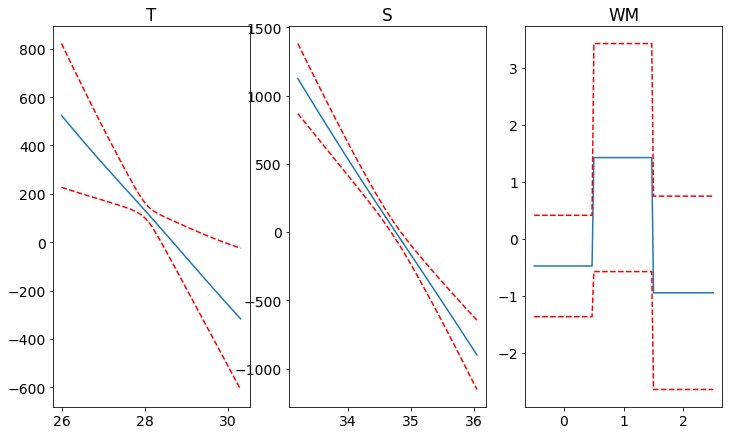

In [272]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

# X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3, figsize=(12,7));

titles = ['T', 'S', 'WM']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     if i == 2:
#         ax.set_xlim(0,.4)
    ax.set_title(titles[i]);

In [119]:
X = tsg_df_subset[['Temp', 'Sal', 'cdomVolts']].values

In [120]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [121]:
tsg_df_subset['cluster'] = kmeans.labels_

In [106]:
acs_device_file = """C399.6	A401.2	8	-1.383813	-1.066823		0.060252	0.051557	0.046522	0.044713	0.042715	0.040001	0.037303	0.03545	0.037248	0.032625	0.029873	0.032147	0.024443	0.027135	0.026485	0.018729	0.019909	0.014787	0.010355	0.008871	0.007876	0.005683	0.002318	0.002538	-0.000071	0	-0.000517	0.004021	0.001437	0.003682	0.003449	0.003614	0.004246	0.007185	0.015037	0.021388		0.269036	0.256804	0.239715	0.22147	0.203317	0.179577	0.158033	0.13612	0.119143	0.106312	0.098681	0.091583	0.081262	0.072483	0.070274	0.062959	0.056527	0.052112	0.043262	0.037851	0.027792	0.024797	0.020994	0.014378	0.010976	0	-0.00054	-0.003323	-0.003902	-0.003782	-0.010391	-0.014753	-0.017805	-0.021754	-0.031734	-0.030839		"; C and A offset, and C and A temperature correction info"
C403.2	A405.1	10	-1.055362	-0.715377		0.040446	0.037387	0.034597	0.030453	0.030017	0.031986	0.032867	0.030632	0.027846	0.026569	0.023514	0.023522	0.022554	0.020594	0.02007	0.016056	0.013668	0.015054	0.010358	0.008342	0.007171	0.00597	0.003334	0.002575	0.002691	0	-0.001309	0.003034	0.001606	0.003447	0.004092	0.007236	0.006167	0.011777	0.013282	0.018961		0.249905	0.239502	0.22367	0.206362	0.190552	0.167808	0.146584	0.125943	0.111151	0.098645	0.09101	0.083596	0.074522	0.067714	0.066221	0.057476	0.052098	0.047393	0.040615	0.035777	0.023931	0.020457	0.017008	0.011362	0.009981	0	-0.001389	-0.002747	-0.004318	-0.003782	-0.010352	-0.014665	-0.018384	-0.020722	-0.03179	-0.02496		"; C and A offset, and C and A temperature correction info"
C406.9	A408.4	11	-0.709445	-0.399667		0.015174	0.016838	0.017907	0.022477	0.023197	0.024926	0.024155	0.022103	0.019289	0.018116	0.018443	0.017446	0.013469	0.01617	0.014846	0.01412	0.012213	0.009665	0.008691	0.006729	0.002215	0.004255	0.002029	0.001681	-0.002094	0	-0.003811	0.001393	0.000139	0.000095	0.000579	0.000386	0.003485	0.00425	0.008425	0.008217		0.232193	0.222888	0.20935	0.19526	0.179832	0.157904	0.136596	0.117918	0.103622	0.092275	0.084807	0.077884	0.068112	0.062493	0.059795	0.05469	0.04789	0.043487	0.036974	0.033126	0.024019	0.0219	0.015107	0.010651	0.009624	0	-0.000416	-0.001758	-0.003867	-0.003681	-0.009578	-0.014524	-0.016843	-0.020541	-0.029061	-0.024795		"; C and A offset, and C and A temperature correction info"
C410.1	A411.9	12	-0.417007	-0.095672		0.001053	0.006131	0.01502	0.01873	0.017803	0.021619	0.025369	0.023228	0.022844	0.021352	0.01699	0.017676	0.016139	0.017023	0.015301	0.012118	0.012817	0.012649	0.008945	0.008051	0.007385	0.007335	0.006369	0.002206	0.000488	0	-0.001481	0.00073	-0.001605	0.001025	-0.000286	0.002339	0.00139	0.003176	0.005684	0.005547		0.215795	0.207907	0.195507	0.181597	0.166624	0.146029	0.126135	0.108131	0.093702	0.083635	0.076087	0.070176	0.062299	0.057035	0.05421	0.048634	0.042971	0.03825	0.034064	0.028939	0.021335	0.018599	0.015061	0.010544	0.007921	0	-0.001262	-0.002686	-0.004932	-0.004792	-0.009104	-0.013433	-0.016608	-0.020413	-0.027211	-0.033927		"; C and A offset, and C and A temperature correction info"
C414.1	A415.7	13	-0.131524	0.186856		-0.013749	-0.004901	0.004959	0.009604	0.015508	0.019541	0.022394	0.021486	0.021014	0.017695	0.016646	0.015821	0.015438	0.013427	0.013856	0.011563	0.010601	0.009212	0.008907	0.007179	0.008227	0.005633	0.003677	0.000941	0.002081	0	-0.001249	-0.000338	-0.00192	-0.001003	-0.001995	-0.001143	-0.003124	-0.000872	-0.001279	0.000254		0.200652	0.192846	0.180773	0.168361	0.154535	0.134873	0.114476	0.097444	0.084271	0.07441	0.067496	0.061103	0.054574	0.048327	0.04595	0.040878	0.036811	0.032772	0.028023	0.023389	0.016964	0.014803	0.011397	0.006949	0.0058	0	-0.000981	-0.002682	-0.004957	-0.005185	-0.009776	-0.013315	-0.015649	-0.019558	-0.025951	-0.028503		"; C and A offset, and C and A temperature correction info"
C417.8	A419.8	15	0.125898	0.45101		-0.024389	-0.014822	-0.00233	0.005343	0.007828	0.01372	0.015072	0.015623	0.015143	0.013023	0.012042	0.012038	0.01138	0.013317	0.012579	0.00922	0.010279	0.008549	0.007355	0.00779	0.004961	0.005645	0.003555	0.002604	0.000494	0	-0.004161	-0.003755	-0.003753	-0.003153	-0.004478	-0.003711	-0.005256	-0.005602	-0.006989	-0.006849		0.188458	0.18166	0.170678	0.158691	0.145512	0.126077	0.106271	0.089821	0.077313	0.067872	0.061419	0.0556	0.049003	0.044139	0.041932	0.037912	0.032744	0.030104	0.025861	0.022166	0.016251	0.014088	0.011462	0.007011	0.006018	0	0.000149	-0.00125	-0.003738	-0.003069	-0.007041	-0.010614	-0.012936	-0.015698	-0.021437	-0.02057		"; C and A offset, and C and A temperature correction info"
C421.9	A424.0	16	0.357364	0.702295		-0.027076	-0.015887	-0.002337	0.002425	0.004629	0.010971	0.013105	0.014027	0.015399	0.014355	0.011326	0.012387	0.010703	0.011407	0.010163	0.01008	0.009467	0.008685	0.006494	0.007958	0.006894	0.007114	0.004956	0.003603	0.002329	0	-0.001945	-0.0003	-0.003889	-0.003393	-0.003418	-0.00342	-0.0055	-0.006684	-0.007581	-0.002036		0.175852	0.169613	0.159169	0.147707	0.135244	0.1164	0.097528	0.081756	0.069623	0.060201	0.053796	0.048325	0.04279	0.037694	0.036529	0.032126	0.027604	0.025088	0.021349	0.018925	0.013153	0.011313	0.009004	0.005325	0.004386	0	-0.000708	-0.002149	-0.003853	-0.00392	-0.007057	-0.010196	-0.011785	-0.014628	-0.018509	-0.023355		"; C and A offset, and C and A temperature correction info"
C426.3	A428.5	17	0.564953	0.937346		-0.031821	-0.021183	-0.009541	-0.003827	0.000978	0.004547	0.007916	0.007923	0.007651	0.006493	0.006255	0.007296	0.007004	0.006684	0.00754	0.00797	0.006789	0.006448	0.00579	0.005366	0.006342	0.004239	0.004164	0.003356	0.001967	0	-0.001513	-0.002477	-0.002331	-0.001362	-0.002281	-0.003184	-0.00597	-0.007669	-0.011952	-0.014404		0.164016	0.15809	0.148109	0.137618	0.126021	0.107143	0.088517	0.073017	0.061406	0.052868	0.047625	0.042201	0.036902	0.032653	0.030911	0.027236	0.02375	0.021646	0.01821	0.01558	0.011049	0.009719	0.007237	0.004165	0.003962	0	-0.000746	-0.001638	-0.003036	-0.002843	-0.005901	-0.008502	-0.009581	-0.011886	-0.016055	-0.016981		"; C and A offset, and C and A temperature correction info"
C430.4	A432.4	18	0.76592	1.161043		-0.032838	-0.0235	-0.012882	-0.007974	-0.007196	-0.003605	-0.000555	0.001355	0.001843	0.001134	0.002124	0.001912	0.00283	0.004178	0.003545	0.003733	0.004272	0.0033	0.003685	0.004142	0.003922	0.004221	0.002689	0.002269	0.000363	0	-0.001246	-0.00139	-0.00266	-0.002281	-0.003737	-0.002442	-0.005657	-0.00692	-0.011305	-0.012964		0.152385	0.147314	0.13857	0.128795	0.116643	0.098833	0.080727	0.066142	0.055212	0.047601	0.041546	0.036858	0.032061	0.028932	0.026746	0.024016	0.020629	0.019179	0.016149	0.014606	0.010216	0.009224	0.007016	0.004968	0.003539	0	0.000701	-0.000102	-0.001971	-0.001556	-0.003518	-0.005808	-0.007484	-0.009202	-0.013285	-0.012587		"; C and A offset, and C and A temperature correction info"
C434.3	A436.3	20	0.938264	1.376242		-0.032122	-0.023741	-0.015459	-0.013532	-0.011763	-0.008484	-0.00717	-0.005559	-0.004191	-0.003079	-0.003427	-0.002392	-0.001487	-0.001657	-0.0009	-0.000961	-0.000058	0.000851	0.00032	0.0014	0.001586	0.00155	0.001511	0.000332	-0.000098	0	-0.001725	-0.00042	-0.001789	-0.001184	-0.000521	-0.001182	-0.002928	-0.005138	-0.010043	-0.014009		0.142358	0.137846	0.129405	0.119696	0.10867	0.091009	0.073696	0.059764	0.049591	0.041544	0.036527	0.032301	0.027714	0.024404	0.022811	0.020163	0.017446	0.015439	0.013464	0.0117	0.007703	0.007058	0.00561	0.003897	0.00344	0	0.000547	-0.000195	-0.001256	-0.001	-0.003142	-0.005008	-0.006246	-0.00718	-0.010544	-0.009726		"; C and A offset, and C and A temperature correction info"
C438.4	A440.0	21	1.110186	1.578256		-0.032544	-0.026645	-0.02141	-0.0186	-0.017248	-0.016185	-0.01516	-0.013181	-0.011734	-0.010562	-0.008906	-0.007321	-0.007413	-0.00505	-0.004527	-0.003155	-0.002511	-0.002516	-0.001768	-0.002784	-0.00064	0.000259	0.00046	0.000449	0.000852	0	0.000703	0.001505	0.000994	0.003267	0.001776	0.002598	0.001025	-0.000819	-0.004693	-0.008188		0.131864	0.12775	0.119722	0.110541	0.099676	0.082675	0.065982	0.052827	0.042866	0.035713	0.03117	0.027269	0.023507	0.019962	0.018751	0.015943	0.013863	0.01217	0.011069	0.009279	0.006093	0.005669	0.003823	0.002128	0.002185	0	-0.000073	-0.000431	-0.001618	-0.001676	-0.002628	-0.004341	-0.005472	-0.006331	-0.00932	-0.010208		"; C and A offset, and C and A temperature correction info"
C442.6	A444.8	22	1.25737	1.775079		-0.032476	-0.028519	-0.02544	-0.024958	-0.025599	-0.024804	-0.02369	-0.020779	-0.018892	-0.016852	-0.015305	-0.013567	-0.012684	-0.01092	-0.009176	-0.008533	-0.007547	-0.007103	-0.006636	-0.005278	-0.004478	-0.00391	-0.002735	-0.001887	-0.001885	0	-0.000689	0.001397	0.001131	0.001778	0.003373	0.004456	0.002724	0.002311	-0.000957	-0.001021		0.124037	0.119791	0.111749	0.102566	0.091735	0.075831	0.05986	0.047563	0.038267	0.031719	0.027166	0.023572	0.020058	0.017441	0.01607	0.013814	0.011836	0.010612	0.009459	0.007699	0.005215	0.004501	0.003615	0.002544	0.00191	0	0.000434	-0.000283	-0.000874	-0.000953	-0.002044	-0.003439	-0.004232	-0.004341	-0.007446	-0.007322		"; C and A offset, and C and A temperature correction info"
C447.0	A449.2	23	1.399575	1.962298		-0.032008	-0.030128	-0.029782	-0.030712	-0.030526	-0.030641	-0.02986	-0.026791	-0.024466	-0.022701	-0.020244	-0.018941	-0.017541	-0.015611	-0.013672	-0.012534	-0.01129	-0.010122	-0.009264	-0.008282	-0.007591	-0.005863	-0.004241	-0.003414	-0.001781	0	0.001321	0.003099	0.004056	0.006244	0.006763	0.008184	0.008196	0.00799	0.005961	0.00482		0.116237	0.112338	0.104417	0.096085	0.085856	0.070471	0.055002	0.043214	0.034328	0.028207	0.023978	0.020798	0.017306	0.015024	0.013543	0.01189	0.010048	0.008727	0.007953	0.006709	0.004505	0.003771	0.003282	0.002014	0.002348	0	0.000683	0.000295	-0.00066	-0.000435	-0.000848	-0.002108	-0.002452	-0.003329	-0.005396	-0.005831		"; C and A offset, and C and A temperature correction info"
C451.8	A453.9	LtBlue	1.535057	2.143054		-0.0314	-0.031885	-0.034249	-0.035404	-0.036042	-0.037602	-0.037251	-0.033886	-0.031444	-0.02864	-0.02541	-0.022918	-0.021343	-0.018935	-0.01731	-0.01544	-0.014526	-0.013154	-0.0122	-0.011415	-0.010137	-0.007838	-0.005942	-0.003927	-0.00253	0	0.001564	0.004939	0.005618	0.008181	0.009434	0.011662	0.012527	0.013387	0.012233	0.010892		0.108553	0.104734	0.097403	0.089701	0.079939	0.06482	0.04987	0.038697	0.030623	0.025048	0.021116	0.018105	0.014982	0.012811	0.011812	0.010169	0.008522	0.007493	0.006614	0.005279	0.003549	0.003223	0.002168	0.001352	0.001949	0	0.000921	0.000305	-0.000043	-0.00004	-0.000701	-0.001747	-0.001839	-0.001991	-0.004054	-0.003152		"; C and A offset, and C and A temperature correction info"
C456.4	A458.2	26	1.654428	2.31342		-0.029229	-0.031706	-0.035141	-0.038637	-0.039939	-0.041086	-0.04103	-0.037395	-0.034837	-0.031217	-0.028904	-0.02699	-0.024936	-0.022606	-0.020418	-0.019049	-0.017269	-0.015613	-0.014343	-0.013237	-0.011461	-0.009728	-0.008227	-0.005014	-0.002866	0	0.002337	0.005878	0.007512	0.00983	0.011993	0.014975	0.01644	0.01891	0.019859	0.020367		0.100828	0.097409	0.090706	0.083011	0.073608	0.059556	0.045236	0.034867	0.027108	0.021953	0.018245	0.015504	0.012549	0.010494	0.009376	0.008198	0.006581	0.005812	0.005266	0.004298	0.002644	0.001913	0.001423	0.001001	0.001285	0	0.000147	0.00015	-0.000098	0.000077	-0.000023	-0.001148	-0.001376	-0.001541	-0.003054	-0.003999		"; C and A offset, and C and A temperature correction info"
C460.4	A462.4	27	1.75579	2.47824		-0.027367	-0.031495	-0.037941	-0.04025	-0.041564	-0.043718	-0.044269	-0.040959	-0.038169	-0.034788	-0.031753	-0.029397	-0.027497	-0.025047	-0.022416	-0.020678	-0.019321	-0.017111	-0.015975	-0.014639	-0.013304	-0.010548	-0.008693	-0.00578	-0.003347	0	0.003811	0.007587	0.00984	0.012325	0.014272	0.017794	0.020507	0.023816	0.025817	0.027996		0.094766	0.091688	0.08501	0.07804	0.069322	0.055451	0.042143	0.031789	0.024316	0.019569	0.016297	0.013535	0.01093	0.009218	0.008378	0.007229	0.005491	0.005122	0.004809	0.003618	0.00248	0.002071	0.001703	0.001043	0.001598	0	0.000684	0.000585	0.000623	0.000668	0.000404	-0.000215	-0.00019	-0.000076	-0.001618	-0.001869		"; C and A offset, and C and A temperature correction info"
C464.7	A466.6	28	1.860282	2.635667		-0.026696	-0.032512	-0.039427	-0.042526	-0.045092	-0.047049	-0.046799	-0.043515	-0.040179	-0.037316	-0.03368	-0.030749	-0.029626	-0.026515	-0.024288	-0.022599	-0.021009	-0.019184	-0.018318	-0.017206	-0.015377	-0.01291	-0.00944	-0.006894	-0.004099	0	0.003237	0.007498	0.010071	0.012974	0.015859	0.019789	0.022643	0.026758	0.030499	0.031614		0.088062	0.085161	0.07917	0.072497	0.0638	0.050746	0.037669	0.028286	0.021334	0.016859	0.013854	0.011437	0.008867	0.00738	0.006627	0.005706	0.004258	0.003924	0.003436	0.002721	0.001503	0.001523	0.001164	0.000793	0.001064	0	0.000587	0.000626	0.000593	0.001145	0.00099	0.000478	0.000467	0.000627	-0.000442	-0.001196		"; C and A offset, and C and A temperature correction info"
C469.2	A471.3	30	1.959591	2.784946		-0.025909	-0.032154	-0.039684	-0.043732	-0.044829	-0.046137	-0.046174	-0.042681	-0.040562	-0.036874	-0.034049	-0.032127	-0.029393	-0.027809	-0.024907	-0.023625	-0.02183	-0.019567	-0.017843	-0.016741	-0.014805	-0.01273	-0.010161	-0.006709	-0.003841	0	0.004056	0.008239	0.010928	0.013918	0.017362	0.021567	0.025648	0.030662	0.035045	0.037341		0.08241	0.079667	0.073652	0.067255	0.058951	0.046393	0.033927	0.025061	0.018441	0.01415	0.011294	0.009088	0.006769	0.005651	0.004771	0.004086	0.003014	0.002727	0.002386	0.001788	0.000599	0.000901	0.000464	0.000285	0.000749	0	0.000497	0.000487	0.000651	0.001159	0.000855	0.000812	0.000771	0.001138	0.000028	0.000469		"; C and A offset, and C and A temperature correction info"
C474.3	A475.9	31	2.0491	2.930072		-0.025402	-0.032537	-0.040473	-0.042941	-0.044201	-0.045856	-0.04563	-0.042805	-0.040415	-0.037324	-0.034633	-0.031669	-0.030167	-0.02771	-0.024816	-0.02278	-0.021793	-0.01969	-0.019008	-0.017325	-0.015918	-0.013136	-0.010699	-0.008086	-0.00416	0	0.004046	0.0079	0.010774	0.013963	0.017107	0.021469	0.025878	0.031235	0.03678	0.042202		0.077809	0.074996	0.069014	0.062866	0.054964	0.042617	0.030714	0.02197	0.015908	0.011972	0.00938	0.00764	0.005368	0.004459	0.003626	0.002999	0.002023	0.001902	0.001512	0.001044	0.000224	0.000411	0.000222	0.000056	0.000348	0	0.000517	0.000761	0.000689	0.001453	0.001438	0.001074	0.001533	0.001549	0.001019	0.000009		"; C and A offset, and C and A temperature correction info"
C478.7	A481.0	32	2.13146	3.070095		-0.025981	-0.032772	-0.039429	-0.042143	-0.043722	-0.044279	-0.042918	-0.040213	-0.037448	-0.03471	-0.031675	-0.030154	-0.028192	-0.025689	-0.023654	-0.02226	-0.020144	-0.01919	-0.017225	-0.016543	-0.014511	-0.012877	-0.009535	-0.006557	-0.003897	0	0.003692	0.008133	0.011169	0.014294	0.017317	0.022194	0.026377	0.032289	0.038459	0.040117		0.072941	0.070118	0.064417	0.058317	0.050709	0.038986	0.027583	0.019599	0.013706	0.010089	0.007776	0.005907	0.004116	0.003185	0.002834	0.002059	0.001301	0.001329	0.001005	0.00068	-0.000209	0.0002	0.000022	0.000085	0.00055	0	0.000464	0.000738	0.001004	0.001623	0.001917	0.001762	0.002052	0.002304	0.001728	0.001429		"; C and A offset, and C and A temperature correction info"
C483.8	A485.3	34	2.219625	3.204797		-0.026791	-0.032699	-0.038388	-0.040446	-0.040123	-0.039716	-0.039392	-0.036347	-0.034486	-0.032423	-0.030123	-0.028172	-0.026495	-0.024307	-0.022138	-0.020366	-0.019205	-0.017572	-0.016163	-0.014867	-0.013394	-0.010962	-0.008971	-0.006475	-0.003331	0	0.003576	0.007984	0.010665	0.013703	0.017062	0.021303	0.02627	0.031588	0.037944	0.043288		0.067656	0.064958	0.059221	0.053679	0.046341	0.035088	0.02427	0.016587	0.011112	0.007906	0.005443	0.004073	0.002445	0.001539	0.001383	0.000788	0.000033	0.000172	0.000138	-0.00022	-0.00077	-0.000545	-0.000381	-0.000274	0.000201	0	0.000461	0.000672	0.000923	0.001723	0.001893	0.001903	0.00214	0.00253	0.002042	0.002592		"; C and A offset, and C and A temperature correction info"
C488.0	A489.9	35	2.291979	3.336087		-0.028773	-0.034012	-0.037982	-0.038293	-0.038297	-0.037624	-0.036245	-0.033771	-0.031879	-0.029716	-0.027592	-0.02577	-0.024036	-0.022177	-0.020012	-0.018568	-0.017596	-0.015746	-0.015046	-0.013944	-0.01266	-0.010573	-0.008246	-0.006021	-0.003159	0	0.003314	0.006982	0.009548	0.012306	0.015167	0.019379	0.023305	0.029147	0.035822	0.038511		0.065008	0.062152	0.056531	0.051144	0.044001	0.0329	0.022446	0.015046	0.009972	0.006807	0.004865	0.003459	0.001937	0.001148	0.001015	0.00052	-0.000048	0.000056	-0.000276	-0.000137	-0.000808	-0.000627	-0.000516	-0.000232	0.000228	0	0.000736	0.000952	0.001335	0.002001	0.002212	0.002381	0.00293	0.003407	0.003065	0.00389		"; C and A offset, and C and A temperature correction info"
C492.5	A494.4	36	2.371804	3.460286		-0.030151	-0.033732	-0.035414	-0.035644	-0.034923	-0.032636	-0.03042	-0.02812	-0.02663	-0.025081	-0.023372	-0.022285	-0.020729	-0.01871	-0.017284	-0.016064	-0.014859	-0.013641	-0.012776	-0.011367	-0.010107	-0.008272	-0.006252	-0.003882	-0.002202	0	0.002649	0.006385	0.008954	0.011633	0.014242	0.018246	0.021956	0.027223	0.033213	0.036074		0.061279	0.058568	0.05319	0.047888	0.040905	0.030435	0.020351	0.013356	0.008529	0.00557	0.003644	0.002437	0.001121	0.000363	0.000169	-0.000181	-0.000566	-0.000601	-0.00061	-0.000665	-0.001243	-0.000794	-0.000514	-0.000271	0.000244	0	0.000559	0.001156	0.001277	0.002302	0.00265	0.002784	0.00333	0.003736	0.003521	0.003565		"; C and A offset, and C and A temperature correction info"
C496.7	A498.4	37	2.446298	3.576218		-0.033137	-0.035096	-0.035113	-0.033414	-0.03132	-0.028622	-0.026505	-0.024963	-0.023621	-0.022372	-0.021292	-0.019851	-0.018546	-0.016923	-0.015594	-0.014226	-0.01349	-0.012014	-0.011069	-0.01008	-0.008625	-0.00729	-0.005948	-0.004357	-0.002334	0	0.001974	0.005455	0.007212	0.0092	0.01171	0.015013	0.018639	0.023264	0.028765	0.033952		0.05734	0.054812	0.049581	0.044637	0.038124	0.028076	0.018274	0.011615	0.007015	0.004359	0.002478	0.001414	0.000369	-0.000137	-0.000386	-0.000587	-0.001067	-0.001036	-0.000923	-0.001027	-0.001252	-0.000877	-0.000717	-0.000412	0.000259	0	0.000704	0.001194	0.00156	0.002371	0.002883	0.003132	0.00367	0.004041	0.004025	0.004521		"; C and A offset, and C and A temperature correction info"
C501.0	A502.8	39	2.506622	3.686126		-0.035949	-0.036452	-0.033978	-0.031375	-0.029587	-0.02602	-0.023	-0.021185	-0.019712	-0.019228	-0.018002	-0.016707	-0.015714	-0.014121	-0.012887	-0.0119	-0.01116	-0.010191	-0.009213	-0.008197	-0.007171	-0.005764	-0.004259	-0.003215	-0.001751	0	0.001705	0.00393	0.005496	0.008024	0.009834	0.012799	0.015392	0.019351	0.023839	0.027224		0.053568	0.051212	0.046495	0.041807	0.035381	0.025717	0.016376	0.010082	0.005746	0.003204	0.001591	0.000636	-0.000566	-0.000825	-0.000965	-0.001246	-0.001695	-0.00142	-0.001264	-0.001371	-0.001642	-0.001185	-0.000919	-0.000603	0.000132	0	0.000861	0.001224	0.001473	0.002283	0.00273	0.003192	0.003737	0.004278	0.004226	0.005133		"; C and A offset, and C and A temperature correction info"
C505.7	A507.4	40	2.564408	3.789976		-0.036775	-0.035569	-0.031394	-0.028443	-0.025621	-0.020996	-0.017917	-0.016405	-0.015711	-0.015271	-0.014793	-0.013785	-0.012511	-0.011462	-0.010281	-0.009582	-0.008624	-0.007681	-0.006861	-0.005919	-0.004833	-0.003872	-0.002706	-0.001552	-0.001062	0	0.001115	0.00323	0.004673	0.006577	0.00819	0.010781	0.013203	0.015981	0.019765	0.022195		0.050139	0.048066	0.043651	0.039143	0.033059	0.023756	0.014821	0.008852	0.004709	0.002317	0.000796	-0.000012	-0.001007	-0.001337	-0.001442	-0.0015	-0.001836	-0.001798	-0.001602	-0.001568	-0.001928	-0.001373	-0.001096	-0.000756	-0.000195	0	0.000515	0.000915	0.001466	0.002337	0.002928	0.003333	0.003793	0.004453	0.004412	0.005608		"; C and A offset, and C and A temperature correction info"
C510.4	A512.0	41	2.622192	3.889237		-0.039825	-0.037161	-0.031396	-0.026756	-0.023433	-0.018957	-0.015833	-0.014597	-0.013487	-0.013475	-0.012776	-0.011946	-0.011026	-0.009979	-0.009042	-0.008044	-0.007343	-0.006269	-0.005785	-0.004659	-0.003613	-0.002913	-0.002341	-0.001691	-0.000851	0	0.00077	0.002151	0.002738	0.004176	0.005711	0.007633	0.009025	0.011346	0.014102	0.016677		0.046159	0.044341	0.040305	0.036165	0.030548	0.021612	0.013175	0.007399	0.003541	0.001528	-0.000091	-0.000768	-0.001642	-0.001831	-0.001674	-0.001897	-0.002104	-0.00199	-0.00168	-0.001685	-0.001905	-0.001519	-0.000963	-0.000867	-0.000119	0	0.000793	0.001138	0.001713	0.002672	0.003023	0.003519	0.004158	0.004598	0.004736	0.005056		"; C and A offset, and C and A temperature correction info"
C515.1	A517.0	42	2.666617	3.988719		-0.041376	-0.037469	-0.029763	-0.025207	-0.021998	-0.016739	-0.013121	-0.011668	-0.010783	-0.010876	-0.010823	-0.009962	-0.008821	-0.008046	-0.007268	-0.006449	-0.005644	-0.005004	-0.004291	-0.003143	-0.002224	-0.001396	-0.000846	-0.000303	-0.000305	0	0.000372	0.001181	0.001859	0.003648	0.004354	0.005965	0.006829	0.00843	0.009998	0.011041		0.043107	0.041246	0.037481	0.033425	0.027847	0.019242	0.011297	0.005871	0.002459	0.000476	-0.000798	-0.001414	-0.002195	-0.002262	-0.002116	-0.002274	-0.002368	-0.002263	-0.002037	-0.001837	-0.00198	-0.001528	-0.001279	-0.000858	-0.000049	0	0.00068	0.001322	0.001674	0.002623	0.003108	0.003652	0.004334	0.004834	0.005043	0.005281		"; C and A offset, and C and A temperature correction info"
C519.9	A521.3	44	2.71415	4.085283		-0.04241	-0.037296	-0.028843	-0.023713	-0.019711	-0.014151	-0.010772	-0.009732	-0.009167	-0.009286	-0.009149	-0.008851	-0.007787	-0.006896	-0.006208	-0.005474	-0.004454	-0.003803	-0.002915	-0.002085	-0.001071	-0.000598	-0.000211	0.000363	0.000235	0	-0.000141	0.000535	0.00081	0.001973	0.002751	0.003825	0.004188	0.0048	0.0054	0.005837		0.040682	0.038815	0.035008	0.031227	0.025854	0.017817	0.010019	0.00498	0.001668	-0.000214	-0.001333	-0.00188	-0.002421	-0.002591	-0.002412	-0.002389	-0.00258	-0.002249	-0.002113	-0.001922	-0.002292	-0.00146	-0.001292	-0.000964	-0.000205	0	0.000724	0.001017	0.001596	0.002661	0.003225	0.003711	0.004435	0.004931	0.005156	0.005298		"; C and A offset, and C and A temperature correction info"
C524.2	A525.8	45	2.756441	4.17758		-0.043239	-0.037413	-0.028015	-0.022299	-0.0185	-0.013387	-0.010026	-0.00908	-0.008252	-0.008697	-0.008609	-0.007595	-0.006717	-0.006205	-0.005621	-0.004536	-0.004062	-0.003272	-0.002456	-0.001188	-0.000494	0.000163	0.000343	0.000285	0.000376	0	-0.000243	-0.000075	0.000018	0.00091	0.001502	0.002142	0.001919	0.001939	0.001621	0.002418		0.037298	0.035495	0.031913	0.028392	0.023373	0.015462	0.008319	0.00363	0.00054	-0.001095	-0.00198	-0.002305	-0.002936	-0.0028	-0.002618	-0.002574	-0.002692	-0.002554	-0.002254	-0.002062	-0.00221	-0.001618	-0.001285	-0.000905	-0.000155	0	0.000677	0.001242	0.001762	0.002785	0.00325	0.00388	0.004539	0.004949	0.005291	0.005426		"; C and A offset, and C and A temperature correction info"
C528.5	A529.8	46	2.795598	4.268547		-0.04369	-0.037023	-0.027076	-0.021916	-0.018576	-0.012755	-0.009086	-0.008114	-0.007473	-0.007725	-0.007711	-0.007087	-0.006247	-0.005743	-0.005094	-0.004443	-0.003441	-0.002879	-0.001937	-0.000929	-0.000002	0.000507	0.001149	0.001024	0.000691	0	-0.000524	-0.000639	-0.000718	0.000472	0.000535	0.000963	0.000292	-0.000227	-0.001476	-0.002624		0.033381	0.031586	0.028295	0.024957	0.020162	0.012861	0.006105	0.00177	-0.000863	-0.00215	-0.003023	-0.003208	-0.003643	-0.003477	-0.003208	-0.003022	-0.003116	-0.002678	-0.002483	-0.002186	-0.002356	-0.001733	-0.001511	-0.000852	-0.000323	0	0.000811	0.001272	0.001736	0.002829	0.003248	0.004011	0.00454	0.005158	0.00534	0.005893		"; C and A offset, and C and A temperature correction info"
C532.7	A534.2	47	2.832073	4.356407		-0.044786	-0.037451	-0.027417	-0.021801	-0.017895	-0.012707	-0.009764	-0.008782	-0.008202	-0.008309	-0.008314	-0.007789	-0.006829	-0.006152	-0.005514	-0.004544	-0.003745	-0.002934	-0.002133	-0.000867	0.000058	0.000458	0.000667	0.000679	0.000551	0	-0.000966	-0.001	-0.001151	-0.000484	-0.000334	-0.0002	-0.00097	-0.002031	-0.004053	-0.004349		0.029465	0.027683	0.024445	0.021431	0.017031	0.010177	0.003843	-0.000032	-0.002423	-0.0035	-0.004142	-0.004109	-0.004451	-0.004152	-0.003924	-0.003641	-0.003613	-0.003139	-0.002897	-0.002562	-0.002565	-0.001955	-0.001589	-0.001171	-0.000305	0	0.000604	0.000959	0.001776	0.002748	0.003265	0.003858	0.004477	0.005102	0.005367	0.006098		"; C and A offset, and C and A temperature correction info"
C536.8	A538.2	49	2.870777	4.440335		-0.044272	-0.036896	-0.026569	-0.021219	-0.017916	-0.013402	-0.010291	-0.009318	-0.008337	-0.008563	-0.008332	-0.007609	-0.006644	-0.006021	-0.005521	-0.004443	-0.003659	-0.002987	-0.001955	-0.000853	0.00008	0.000868	0.000968	0.000928	0.000714	0	-0.000808	-0.000948	-0.001304	-0.000678	-0.00056	-0.000639	-0.001726	-0.003134	-0.005382	-0.006427		0.025633	0.023831	0.020915	0.018072	0.013918	0.007518	0.001834	-0.001651	-0.003613	-0.004597	-0.004953	-0.004751	-0.004995	-0.004592	-0.004227	-0.003981	-0.003733	-0.003303	-0.002876	-0.002617	-0.002617	-0.00194	-0.001448	-0.001083	-0.000258	0	0.000619	0.001182	0.001752	0.002735	0.003337	0.003884	0.00468	0.005124	0.005405	0.005869		"; C and A offset, and C and A temperature correction info"
C541.1	A542.8	LtCyan	2.904051	4.521371		-0.043208	-0.035687	-0.02621	-0.021628	-0.018456	-0.013714	-0.010907	-0.00991	-0.009388	-0.009294	-0.009055	-0.008428	-0.0075	-0.006825	-0.006118	-0.005263	-0.004237	-0.003347	-0.002456	-0.001321	-0.000259	0.000448	0.000983	0.001033	0.000667	0	-0.000758	-0.001032	-0.001299	-0.000552	-0.000575	-0.000547	-0.001732	-0.003396	-0.006328	-0.008053		0.021909	0.020164	0.017524	0.014851	0.011069	0.005284	0.000056	-0.003047	-0.00466	-0.005412	-0.005596	-0.005323	-0.005318	-0.005001	-0.00445	-0.004143	-0.003939	-0.003339	-0.003076	-0.002601	-0.002633	-0.001839	-0.001457	-0.000922	-0.000265	0	0.000851	0.0013	0.001862	0.002756	0.003468	0.004142	0.004827	0.00526	0.005537	0.005692		"; C and A offset, and C and A temperature correction info"
C545.6	A546.8	51	2.94027	4.595425		-0.042133	-0.034921	-0.026098	-0.021442	-0.018384	-0.014888	-0.012814	-0.011604	-0.010794	-0.010638	-0.010331	-0.009419	-0.008584	-0.007598	-0.006948	-0.005904	-0.00494	-0.004216	-0.00298	-0.001787	-0.000776	-0.000143	0.00003	0.000381	0.000401	0	-0.000847	-0.001035	-0.001416	-0.000837	-0.000747	-0.000923	-0.002088	-0.003823	-0.00682	-0.007871		0.017949	0.016233	0.013839	0.011562	0.008083	0.002774	-0.001976	-0.004582	-0.006053	-0.00647	-0.006572	-0.006079	-0.006029	-0.005462	-0.004856	-0.00455	-0.004256	-0.003852	-0.00323	-0.002815	-0.002682	-0.002152	-0.00177	-0.001106	-0.000462	0	0.000665	0.000992	0.001668	0.002586	0.0032	0.00376	0.004415	0.004931	0.005312	0.005362		"; C and A offset, and C and A temperature correction info"
C549.9	A551.2	52	2.976811	4.666566		-0.039442	-0.032749	-0.024628	-0.020903	-0.018708	-0.015557	-0.013337	-0.01235	-0.011313	-0.01105	-0.010629	-0.009813	-0.00887	-0.008134	-0.007347	-0.006209	-0.005424	-0.00433	-0.003396	-0.002122	-0.001112	-0.00019	0.00036	0.000538	0.000461	0	-0.000574	-0.000603	-0.000883	-0.00018	-0.000212	-0.000193	-0.001447	-0.003171	-0.006223	-0.007896		0.014404	0.012743	0.010701	0.00862	0.005428	0.000525	-0.003635	-0.005861	-0.006938	-0.007261	-0.007074	-0.00654	-0.006397	-0.005821	-0.005072	-0.004788	-0.004399	-0.003794	-0.003202	-0.002885	-0.002848	-0.001987	-0.001594	-0.001029	-0.000412	0	0.000662	0.001049	0.001664	0.002617	0.00321	0.003823	0.004447	0.004927	0.005239	0.005489		"; C and A offset, and C and A temperature correction info"
C554.1	A555.3	54	3.001121	4.734801		-0.036828	-0.030542	-0.02391	-0.020904	-0.018726	-0.016043	-0.014528	-0.013473	-0.012749	-0.012228	-0.011715	-0.010924	-0.009834	-0.009035	-0.008063	-0.007062	-0.006075	-0.005099	-0.004004	-0.002837	-0.001667	-0.000888	-0.000131	0.000211	0.000123	0	-0.000361	-0.00049	-0.000626	0.000202	0.000322	0.000273	-0.000735	-0.002355	-0.005362	-0.007581		0.011348	0.009746	0.007841	0.006039	0.003158	-0.001239	-0.005012	-0.006886	-0.007829	-0.007937	-0.007606	-0.007078	-0.006729	-0.006119	-0.005429	-0.004915	-0.004581	-0.004032	-0.003373	-0.002956	-0.002727	-0.002063	-0.001605	-0.001118	-0.000387	0	0.000671	0.001099	0.001647	0.002522	0.003159	0.003739	0.004344	0.004826	0.005081	0.005778		"; C and A offset, and C and A temperature correction info"
C558.4	A559.8	55	3.03235	4.799603		-0.033587	-0.028254	-0.022706	-0.02006	-0.018591	-0.017082	-0.016055	-0.014832	-0.013875	-0.013173	-0.012527	-0.011358	-0.010649	-0.009576	-0.008731	-0.007708	-0.006526	-0.00563	-0.004664	-0.003479	-0.002554	-0.001602	-0.001074	-0.00048	-0.000109	0	-0.00028	-0.000096	-0.000208	0.00038	0.000591	0.00069	-0.00015	-0.001659	-0.004258	-0.005652		0.008762	0.007294	0.005682	0.004134	0.001522	-0.00263	-0.005996	-0.007734	-0.008424	-0.008432	-0.00804	-0.007357	-0.007014	-0.006342	-0.005603	-0.005144	-0.00474	-0.004066	-0.003491	-0.003001	-0.002696	-0.002001	-0.001561	-0.001005	-0.000339	0	0.000687	0.001193	0.001725	0.002588	0.003134	0.003637	0.004222	0.004729	0.005026	0.005249		"; C and A offset, and C and A temperature correction info"
C563.0	A563.9	56	3.059106	4.859994		-0.029726	-0.025015	-0.020537	-0.019076	-0.01832	-0.017026	-0.016102	-0.015068	-0.014021	-0.013325	-0.012395	-0.011666	-0.010761	-0.009943	-0.008979	-0.008005	-0.007019	-0.006053	-0.005185	-0.003888	-0.003039	-0.001949	-0.001042	-0.00051	-0.000288	0	0.000014	0.00039	0.000327	0.0012	0.001514	0.001737	0.00107	-0.000119	-0.002599	-0.004569		0.007658	0.006104	0.004505	0.002937	0.000358	-0.003509	-0.006662	-0.008281	-0.008842	-0.008724	-0.008335	-0.007624	-0.007248	-0.00648	-0.005836	-0.005298	-0.00492	-0.004205	-0.003563	-0.003131	-0.002682	-0.002065	-0.001477	-0.000989	-0.000364	0	0.000716	0.001161	0.001739	0.002628	0.003106	0.003715	0.004283	0.004745	0.00504	0.005325		"; C and A offset, and C and A temperature correction info"
C566.9	A568.3	57	3.083703	4.915238		-0.026624	-0.022785	-0.019878	-0.018714	-0.018009	-0.017443	-0.01709	-0.015953	-0.015204	-0.014205	-0.013263	-0.01229	-0.01135	-0.010376	-0.009286	-0.008442	-0.007457	-0.006422	-0.005531	-0.004551	-0.003534	-0.002571	-0.001763	-0.00106	-0.000474	0	0.000163	0.000486	0.000806	0.001607	0.00192	0.002402	0.002013	0.0011	-0.001133	-0.002504		0.008049	0.006595	0.005018	0.00357	0.001116	-0.002747	-0.005983	-0.0076	-0.008276	-0.008243	-0.0079	-0.007324	-0.006869	-0.006317	-0.005646	-0.005107	-0.004758	-0.004109	-0.003527	-0.003066	-0.002757	-0.002048	-0.001611	-0.001033	-0.000437	0	0.000687	0.001062	0.001587	0.002435	0.003041	0.003617	0.004152	0.004673	0.004929	0.004786		"; C and A offset, and C and A temperature correction info"
C570.8	A572.0	59	3.106085	4.96573		-0.023153	-0.020318	-0.018421	-0.017959	-0.017981	-0.018169	-0.018048	-0.016831	-0.015639	-0.014527	-0.013496	-0.01246	-0.01168	-0.010637	-0.009715	-0.008715	-0.007821	-0.006845	-0.006015	-0.005026	-0.004083	-0.00318	-0.002342	-0.001496	-0.000629	0	0.000338	0.000942	0.001335	0.002187	0.002679	0.003253	0.003028	0.002437	0.000812	-0.000026		0.008827	0.007476	0.005977	0.004556	0.002055	-0.00189	-0.005207	-0.006966	-0.007743	-0.007835	-0.007566	-0.006915	-0.006674	-0.006106	-0.005601	-0.005085	-0.004698	-0.004128	-0.00352	-0.002945	-0.002702	-0.001977	-0.001541	-0.000982	-0.000392	0	0.000627	0.001106	0.001654	0.002537	0.003098	0.003596	0.004244	0.004685	0.005094	0.005365		"; C and A offset, and C and A temperature correction info"
C574.6	A575.6	60	3.121756	5.010847		-0.019617	-0.017494	-0.016895	-0.017275	-0.017513	-0.017934	-0.01797	-0.016697	-0.015735	-0.01451	-0.013323	-0.012394	-0.01163	-0.010756	-0.009716	-0.008816	-0.007901	-0.007023	-0.006282	-0.005465	-0.004596	-0.003641	-0.002496	-0.00164	-0.000732	0	0.000665	0.00149	0.001968	0.002895	0.003449	0.004238	0.004319	0.004093	0.002792	0.00177		0.010302	0.009082	0.007646	0.006055	0.00351	-0.000569	-0.004128	-0.006126	-0.007096	-0.007312	-0.007273	-0.006771	-0.006487	-0.006106	-0.005614	-0.005154	-0.004795	-0.004244	-0.003623	-0.003184	-0.002776	-0.002166	-0.001614	-0.001031	-0.000447	0	0.000656	0.001114	0.001686	0.002464	0.003049	0.003659	0.004245	0.004693	0.00509	0.005709		"; C and A offset, and C and A temperature correction info"
C578.1	A579.3	61	3.140959	5.051346		-0.017464	-0.016281	-0.016733	-0.017321	-0.017784	-0.018821	-0.019237	-0.017821	-0.016774	-0.015233	-0.014015	-0.013062	-0.012198	-0.011102	-0.010222	-0.00927	-0.008388	-0.007587	-0.006719	-0.00611	-0.005209	-0.00423	-0.003299	-0.002233	-0.001189	0	0.000738	0.001754	0.002389	0.003229	0.004038	0.004886	0.005321	0.005472	0.004695	0.004393		0.012618	0.011495	0.009993	0.008449	0.005714	0.001314	-0.00276	-0.00499	-0.006279	-0.006657	-0.006737	-0.006549	-0.006326	-0.006059	-0.005609	-0.005126	-0.004896	-0.004288	-0.003753	-0.003265	-0.002866	-0.002225	-0.001752	-0.001126	-0.000432	0	0.000658	0.001075	0.001633	0.002486	0.003034	0.003675	0.004337	0.004907	0.005296	0.005284		"; C and A offset, and C and A temperature correction info"
C581.9	A582.9	62	3.152032	5.087119		-0.014903	-0.014577	-0.015889	-0.017209	-0.018159	-0.019458	-0.019833	-0.018359	-0.017071	-0.015536	-0.014145	-0.013179	-0.012435	-0.011417	-0.010431	-0.009524	-0.008811	-0.00788	-0.007235	-0.006477	-0.005698	-0.004685	-0.003603	-0.002389	-0.001314	0	0.000987	0.002221	0.003053	0.003944	0.004835	0.005979	0.006597	0.007132	0.006956	0.007025		0.014993	0.014042	0.012524	0.010809	0.007874	0.003094	-0.001259	-0.003957	-0.005437	-0.006169	-0.00635	-0.00626	-0.006288	-0.006039	-0.005689	-0.005352	-0.00506	-0.004463	-0.003929	-0.00343	-0.003065	-0.002387	-0.001867	-0.001227	-0.000554	0	0.000648	0.000993	0.001515	0.002427	0.003017	0.003583	0.004273	0.004938	0.005395	0.005235		"; C and A offset, and C and A temperature correction info"
C586.1	A587.6	64	3.152394	5.074265		-0.007757	-0.00821	-0.009959	-0.011694	-0.012867	-0.014131	-0.01393	-0.012096	-0.010562	-0.009127	-0.007859	-0.007435	-0.007452	-0.006912	-0.00633	-0.005763	-0.005247	-0.00437	-0.004019	-0.003627	-0.003289	-0.002707	-0.002022	-0.001517	-0.000862	0	0.000843	0.001884	0.002376	0.002766	0.003184	0.00387	0.004157	0.004632	0.004565	0.004398		0.045076	0.044004	0.040844	0.03755	0.031854	0.022386	0.012574	0.005355	0.000331	-0.003096	-0.005326	-0.007004	-0.008321	-0.008941	-0.00919	-0.009156	-0.00885	-0.007963	-0.007015	-0.006044	-0.005195	-0.004021	-0.00289	-0.001839	-0.000755	0	0.000879	0.001542	0.002077	0.003162	0.003935	0.004861	0.005974	0.007058	0.007966	0.008209		"; C and A offset, and C and A temperature correction info"
C590.0	A591.8	65	3.15659	5.102298		-0.006826	-0.008113	-0.010977	-0.013043	-0.014152	-0.015507	-0.015673	-0.013658	-0.01239	-0.010698	-0.009403	-0.008982	-0.008825	-0.008243	-0.007679	-0.006937	-0.006249	-0.005457	-0.005099	-0.004748	-0.004317	-0.003652	-0.002862	-0.001976	-0.001151	0	0.001032	0.002469	0.002988	0.003608	0.0041	0.005069	0.005864	0.006697	0.007189	0.006886		0.044763	0.043817	0.040622	0.037224	0.031518	0.021972	0.012022	0.004712	-0.000465	-0.003984	-0.006343	-0.008039	-0.009248	-0.00991	-0.010074	-0.009946	-0.009486	-0.008516	-0.007464	-0.006416	-0.005351	-0.004234	-0.002914	-0.001815	-0.000709	0	0.00095	0.001618	0.002264	0.003375	0.004284	0.005203	0.006271	0.007376	0.008246	0.008634		"; C and A offset, and C and A temperature correction info"
C594.4	A596.0	66	3.152377	5.12823		-0.005564	-0.007578	-0.011087	-0.013232	-0.014561	-0.016302	-0.016536	-0.014532	-0.013033	-0.011324	-0.009994	-0.009407	-0.009273	-0.008633	-0.007936	-0.00741	-0.006908	-0.006059	-0.005705	-0.00544	-0.004978	-0.004321	-0.003323	-0.002424	-0.001344	0	0.001182	0.002602	0.00361	0.004247	0.004938	0.006093	0.007221	0.008533	0.009743	0.010635		0.044723	0.043765	0.040539	0.037121	0.031378	0.021783	0.011686	0.004262	-0.000947	-0.004403	-0.006823	-0.008537	-0.009783	-0.01043	-0.010589	-0.010443	-0.009936	-0.0089	-0.007759	-0.006635	-0.005489	-0.004333	-0.003019	-0.001912	-0.000792	0	0.001037	0.001733	0.002321	0.003456	0.004348	0.005347	0.006464	0.007674	0.008549	0.009093		"; C and A offset, and C and A temperature correction info"
C598.7	A600.4	67	3.148892	5.155177		-0.00444	-0.007019	-0.011134	-0.013864	-0.015414	-0.017182	-0.017272	-0.015224	-0.013646	-0.011872	-0.010509	-0.009953	-0.009811	-0.009151	-0.008529	-0.007872	-0.00727	-0.006424	-0.00611	-0.005943	-0.005467	-0.00471	-0.00375	-0.002674	-0.001537	0	0.001579	0.003282	0.004281	0.005064	0.00604	0.007483	0.008862	0.01065	0.012295	0.013234		0.043684	0.042905	0.039878	0.036458	0.030769	0.021261	0.011338	0.004017	-0.001232	-0.004693	-0.00716	-0.008904	-0.010251	-0.010912	-0.011049	-0.0108	-0.010312	-0.009182	-0.007999	-0.006824	-0.005587	-0.004338	-0.003065	-0.00195	-0.000809	0	0.001127	0.001823	0.002444	0.003538	0.004425	0.005514	0.006614	0.00789	0.008861	0.008975		"; C and A offset, and C and A temperature correction info"
C603.1	A604.6	69	3.154607	5.18877		-0.003259	-0.006483	-0.011296	-0.013925	-0.015341	-0.017151	-0.017485	-0.015449	-0.01393	-0.012065	-0.010625	-0.009969	-0.009789	-0.009188	-0.008521	-0.008004	-0.007437	-0.00682	-0.006558	-0.006425	-0.005983	-0.005144	-0.004193	-0.003019	-0.001655	0	0.001763	0.003496	0.004652	0.00556	0.006697	0.008297	0.009936	0.012182	0.014292	0.015586		0.042255	0.041609	0.038628	0.035378	0.029755	0.020403	0.010516	0.003217	-0.001929	-0.005363	-0.007761	-0.009552	-0.010761	-0.011363	-0.011502	-0.011283	-0.010612	-0.009413	-0.008174	-0.006947	-0.005667	-0.004485	-0.003021	-0.001849	-0.000752	0	0.001165	0.001853	0.002528	0.003692	0.00463	0.005605	0.006819	0.008023	0.009064	0.009274		"; C and A offset, and C and A temperature correction info"
C607.6	A609.3	70	3.164983	5.230089		-0.002561	-0.006158	-0.011197	-0.013992	-0.015606	-0.017469	-0.017719	-0.015694	-0.01413	-0.012254	-0.010808	-0.010154	-0.009933	-0.009237	-0.00863	-0.008078	-0.007656	-0.007024	-0.006749	-0.006724	-0.006239	-0.005467	-0.00444	-0.003229	-0.001824	0	0.001766	0.003705	0.005012	0.006062	0.007207	0.009039	0.010936	0.013397	0.016153	0.017727		0.040809	0.04013	0.03721	0.034082	0.028585	0.019301	0.009609	0.002441	-0.002636	-0.006021	-0.008458	-0.010141	-0.011462	-0.011968	-0.012027	-0.011767	-0.01106	-0.009751	-0.00839	-0.007071	-0.005942	-0.004568	-0.003263	-0.002027	-0.000802	0	0.001063	0.001781	0.002382	0.003617	0.004587	0.005621	0.006823	0.00813	0.009087	0.009614		"; C and A offset, and C and A temperature correction info"
C612.2	A613.7	71	3.180517	5.275228		-0.001757	-0.005595	-0.010861	-0.013709	-0.015173	-0.016855	-0.017026	-0.014995	-0.013555	-0.011697	-0.010318	-0.009619	-0.009415	-0.008835	-0.008207	-0.00781	-0.007442	-0.006884	-0.006685	-0.006624	-0.006322	-0.005596	-0.004581	-0.003234	-0.001798	0	0.00189	0.004019	0.005335	0.006426	0.007708	0.009624	0.011832	0.014524	0.017561	0.019151		0.039296	0.038657	0.035953	0.032788	0.027406	0.01829	0.008818	0.001785	-0.003178	-0.006532	-0.008828	-0.01049	-0.011729	-0.01228	-0.012252	-0.011922	-0.011172	-0.009846	-0.008528	-0.007173	-0.005966	-0.004611	-0.003289	-0.002018	-0.000838	0	0.001116	0.001786	0.002439	0.003678	0.004641	0.005747	0.006928	0.00818	0.009162	0.009799		"; C and A offset, and C and A temperature correction info"
C616.5	A618.0	72	3.200373	5.321248		-0.001559	-0.005558	-0.010818	-0.01354	-0.014933	-0.016607	-0.016743	-0.014792	-0.013281	-0.011496	-0.01005	-0.009394	-0.009203	-0.008615	-0.008064	-0.007602	-0.007353	-0.006824	-0.006724	-0.006756	-0.006417	-0.005663	-0.004659	-0.003415	-0.001889	0	0.001909	0.004084	0.005453	0.006519	0.007906	0.009939	0.012297	0.01519	0.018644	0.020709		0.03799	0.037319	0.034558	0.03157	0.02631	0.017435	0.008015	0.001116	-0.003792	-0.006975	-0.009231	-0.010888	-0.012052	-0.012524	-0.012514	-0.012104	-0.011292	-0.010021	-0.008597	-0.007275	-0.005954	-0.004672	-0.003196	-0.002025	-0.000737	0	0.001119	0.001802	0.002448	0.00369	0.004724	0.005817	0.006979	0.008238	0.009183	0.009758		"; C and A offset, and C and A temperature correction info"
C621.0	A622.2	74	3.224478	5.366895		-0.001031	-0.005094	-0.01028	-0.012942	-0.014257	-0.015689	-0.015714	-0.013768	-0.012294	-0.010628	-0.009372	-0.008679	-0.00847	-0.008028	-0.007497	-0.007146	-0.006925	-0.006525	-0.006509	-0.006487	-0.006225	-0.005513	-0.004567	-0.003357	-0.001861	0	0.002013	0.004122	0.005504	0.0067	0.008114	0.010171	0.012538	0.015676	0.019406	0.021504		0.036774	0.036214	0.033593	0.030589	0.02535	0.016588	0.007399	0.000654	-0.004167	-0.007311	-0.009429	-0.011018	-0.012163	-0.012576	-0.012545	-0.012135	-0.011348	-0.010042	-0.00859	-0.007192	-0.006009	-0.004692	-0.003356	-0.00208	-0.000904	0	0.000978	0.001751	0.002369	0.003604	0.004585	0.005663	0.006901	0.008146	0.009179	0.009699		"; C and A offset, and C and A temperature correction info"
C625.0	A626.7	LtGreen	3.239672	5.41148		-0.000804	-0.004818	-0.009812	-0.012286	-0.013452	-0.014645	-0.014578	-0.012704	-0.011388	-0.009773	-0.008521	-0.008002	-0.00783	-0.007429	-0.007004	-0.006613	-0.006578	-0.00622	-0.006258	-0.006344	-0.006166	-0.005524	-0.004631	-0.003424	-0.001989	0	0.001861	0.003867	0.005362	0.006466	0.007871	0.010002	0.012448	0.015561	0.0195	0.021663		0.035773	0.035248	0.032684	0.029762	0.024601	0.016093	0.007057	0.000428	-0.004254	-0.007301	-0.009548	-0.011029	-0.012138	-0.012539	-0.012425	-0.011979	-0.011202	-0.009822	-0.008478	-0.007061	-0.005825	-0.004576	-0.003159	-0.002	-0.000835	0	0.001139	0.001817	0.002469	0.003742	0.004716	0.005822	0.007073	0.008223	0.009262	0.009462		"; C and A offset, and C and A temperature correction info"
C629.4	A630.9	76	3.258573	5.454171		-0.000647	-0.004463	-0.009086	-0.011366	-0.012404	-0.013357	-0.013119	-0.01146	-0.010058	-0.008663	-0.007476	-0.006947	-0.006843	-0.006441	-0.006125	-0.005903	-0.005878	-0.005642	-0.005759	-0.00585	-0.005679	-0.005122	-0.004222	-0.003149	-0.001797	0	0.001831	0.003887	0.005264	0.006452	0.007855	0.009948	0.012425	0.015584	0.019585	0.021687		0.034735	0.034256	0.031724	0.028969	0.023909	0.015476	0.006601	0.000147	-0.004497	-0.007466	-0.009619	-0.011082	-0.012177	-0.012451	-0.012366	-0.011888	-0.01111	-0.009749	-0.008401	-0.006962	-0.005769	-0.004432	-0.003107	-0.00195	-0.00079	0	0.001131	0.00181	0.002531	0.003657	0.004712	0.005824	0.007031	0.008283	0.009193	0.009757		"; C and A offset, and C and A temperature correction info"
C633.7	A635.0	77	3.279254	5.496046		-0.000518	-0.004136	-0.008399	-0.010279	-0.011139	-0.011847	-0.011619	-0.009924	-0.008703	-0.007354	-0.006376	-0.005842	-0.005734	-0.005475	-0.005309	-0.005081	-0.005048	-0.005076	-0.00516	-0.005394	-0.005264	-0.00479	-0.004068	-0.00306	-0.001829	0	0.001737	0.003698	0.004973	0.006079	0.007489	0.009515	0.01185	0.015106	0.019105	0.021333		0.033846	0.033372	0.030968	0.028153	0.023221	0.014972	0.006325	-0.00006	-0.004596	-0.007583	-0.009589	-0.011101	-0.012149	-0.012498	-0.01231	-0.011856	-0.011048	-0.009735	-0.008443	-0.007055	-0.005836	-0.004596	-0.003247	-0.002067	-0.000877	0	0.001023	0.001733	0.00241	0.003641	0.004669	0.005669	0.006884	0.00814	0.009158	0.009746		"; C and A offset, and C and A temperature correction info"
C638.0	A639.3	79	3.282582	5.535688		-0.000599	-0.003858	-0.007545	-0.009101	-0.009759	-0.010176	-0.009627	-0.008059	-0.00694	-0.00579	-0.00486	-0.004443	-0.004438	-0.004241	-0.004199	-0.004105	-0.004264	-0.004257	-0.004494	-0.004722	-0.004723	-0.004344	-0.003717	-0.002881	-0.001658	0	0.001519	0.003366	0.004699	0.005744	0.007035	0.00897	0.011324	0.014405	0.018321	0.020565		0.033177	0.032715	0.030279	0.027536	0.022799	0.01466	0.006128	-0.000147	-0.004613	-0.007497	-0.009574	-0.011043	-0.012034	-0.012411	-0.01225	-0.011794	-0.010895	-0.009649	-0.00832	-0.006941	-0.00575	-0.004508	-0.003057	-0.001962	-0.000813	0	0.001062	0.001834	0.002484	0.003769	0.004705	0.005819	0.006984	0.00824	0.009204	0.009472		"; C and A offset, and C and A temperature correction info"
C642.3	A643.6	80	3.303876	5.570661		-0.001058	-0.00387	-0.00695	-0.008337	-0.00869	-0.008747	-0.008027	-0.006646	-0.005547	-0.004647	-0.003864	-0.003541	-0.003513	-0.003386	-0.003391	-0.003358	-0.003505	-0.003573	-0.003835	-0.004113	-0.004064	-0.003706	-0.003305	-0.002379	-0.001383	0	0.00146	0.003367	0.004554	0.005508	0.006768	0.008618	0.010884	0.013829	0.017613	0.019845		0.032621	0.032125	0.029753	0.027119	0.022394	0.014313	0.005899	-0.000267	-0.004658	-0.007538	-0.009506	-0.010965	-0.011993	-0.012228	-0.012053	-0.011639	-0.01078	-0.00953	-0.008195	-0.006835	-0.005719	-0.004455	-0.003203	-0.001979	-0.000798	0	0.000984	0.001741	0.002454	0.003737	0.004653	0.005719	0.006879	0.008126	0.009079	0.00969		"; C and A offset, and C and A temperature correction info"
C646.6	A647.9	81	3.314914	5.60334		-0.001683	-0.004094	-0.006474	-0.007218	-0.007336	-0.007097	-0.00626	-0.00493	-0.003972	-0.003102	-0.002463	-0.002171	-0.002192	-0.002208	-0.002382	-0.002232	-0.002582	-0.002776	-0.003188	-0.003424	-0.003569	-0.003327	-0.002904	-0.002255	-0.001401	0	0.001294	0.002832	0.003943	0.004868	0.006088	0.007706	0.009785	0.012577	0.016323	0.018521		0.032578	0.0321	0.029725	0.027002	0.022311	0.0144	0.006066	-0.000003	-0.004342	-0.007194	-0.009157	-0.0106	-0.011567	-0.011848	-0.011735	-0.011333	-0.010573	-0.009225	-0.008019	-0.006653	-0.005559	-0.004252	-0.003024	-0.001859	-0.000791	0	0.001119	0.001934	0.002532	0.003762	0.004729	0.005754	0.006967	0.008132	0.009133	0.00978		"; C and A offset, and C and A temperature correction info"
C651.1	A652.6	82	3.317172	5.63167		-0.001739	-0.00358	-0.005168	-0.005798	-0.005881	-0.005295	-0.004156	-0.0029	-0.002072	-0.001496	-0.001025	-0.000904	-0.000998	-0.001038	-0.001295	-0.001427	-0.001777	-0.002016	-0.002376	-0.002722	-0.002828	-0.002695	-0.002348	-0.001876	-0.001172	0	0.001099	0.002446	0.003508	0.0044	0.005464	0.007026	0.008857	0.011404	0.014837	0.016962		0.03201	0.031479	0.029054	0.026405	0.021878	0.013965	0.005727	-0.000297	-0.00463	-0.007388	-0.009366	-0.010708	-0.011685	-0.011872	-0.011689	-0.011278	-0.010542	-0.009214	-0.007946	-0.006726	-0.005545	-0.004317	-0.002988	-0.00187	-0.000816	0	0.001047	0.001804	0.002411	0.003771	0.004647	0.00567	0.006871	0.008016	0.008978	0.009332		"; C and A offset, and C and A temperature correction info"
C655.4	A656.8	84	3.322501	5.658212		-0.002776	-0.004031	-0.005012	-0.005065	-0.004616	-0.003575	-0.002419	-0.001319	-0.000604	-0.000062	0.000191	0.000382	0.000264	0.000014	-0.000265	-0.000382	-0.000742	-0.001049	-0.001483	-0.001948	-0.001962	-0.002111	-0.001932	-0.001445	-0.000878	0	0.001011	0.002368	0.003109	0.00387	0.004844	0.00633	0.007997	0.010367	0.013399	0.015388		0.031539	0.030947	0.028635	0.026075	0.021565	0.013861	0.005811	-0.000073	-0.00425	-0.00698	-0.008932	-0.010271	-0.011189	-0.011482	-0.011391	-0.010901	-0.010239	-0.008975	-0.007781	-0.006532	-0.005607	-0.004321	-0.002993	-0.001883	-0.000855	0	0.001075	0.001819	0.002343	0.003655	0.004579	0.005628	0.006838	0.00796	0.008906	0.009313		"; C and A offset, and C and A temperature correction info"
C660.1	A661.4	85	3.328964	5.685718		-0.003857	-0.004624	-0.004691	-0.004223	-0.003783	-0.002537	-0.001272	-0.000102	0.000617	0.00097	0.001274	0.001362	0.001207	0.001006	0.000501	0.000398	0.000081	-0.000531	-0.00091	-0.001214	-0.001468	-0.00159	-0.001507	-0.001274	-0.0008	0	0.000822	0.00181	0.002545	0.003207	0.004098	0.005308	0.00664	0.008769	0.011687	0.013303		0.031998	0.031499	0.029153	0.026501	0.021976	0.014356	0.006286	0.000391	-0.003775	-0.006547	-0.008489	-0.009829	-0.010821	-0.011054	-0.011032	-0.010637	-0.009963	-0.008788	-0.007632	-0.006357	-0.005272	-0.004203	-0.002991	-0.001847	-0.000743	0	0.001043	0.001784	0.002413	0.003639	0.004521	0.00564	0.006697	0.007897	0.008946	0.009616		"; C and A offset, and C and A temperature correction info"
C664.6	A665.7	86	3.328262	5.715279		-0.004742	-0.00469	-0.003787	-0.003212	-0.002531	-0.000718	0.00096	0.001931	0.002549	0.002655	0.002696	0.002598	0.002478	0.002012	0.001603	0.001375	0.000878	0.000394	-0.000069	-0.00042	-0.000685	-0.000924	-0.000898	-0.000773	-0.000632	0	0.000466	0.001389	0.00207	0.002679	0.003378	0.004459	0.005677	0.007522	0.009933	0.011491		0.031961	0.031339	0.028886	0.026276	0.021876	0.014215	0.006225	0.000434	-0.003716	-0.006413	-0.008328	-0.00958	-0.010555	-0.010918	-0.010765	-0.010394	-0.009772	-0.008598	-0.007519	-0.006296	-0.005362	-0.004193	-0.002911	-0.001868	-0.000782	0	0.000971	0.001688	0.002337	0.003557	0.004515	0.005537	0.006652	0.007839	0.008747	0.009456		"; C and A offset, and C and A temperature correction info"
C668.8	A670.1	87	3.343854	5.744764		-0.005859	-0.005282	-0.003822	-0.00257	-0.001394	0.000518	0.002008	0.002864	0.003359	0.003538	0.003412	0.003338	0.003268	0.002825	0.002394	0.00217	0.001712	0.001196	0.000639	0.000256	0.000053	-0.00037	-0.000618	-0.000521	-0.000347	0	0.000521	0.001295	0.001702	0.002053	0.002799	0.003686	0.004721	0.006224	0.008295	0.009679		0.031584	0.030995	0.02867	0.026104	0.021566	0.01409	0.006274	0.000547	-0.003469	-0.00614	-0.008032	-0.009354	-0.010254	-0.010541	-0.010447	-0.010074	-0.009495	-0.008443	-0.00731	-0.006091	-0.00526	-0.00405	-0.002879	-0.001712	-0.000766	0	0.000999	0.001707	0.002341	0.003556	0.004474	0.005481	0.006577	0.007691	0.008648	0.009203		"; C and A offset, and C and A temperature correction info"
C673.4	A674.4	89	3.356492	5.772428		-0.00751	-0.006372	-0.003833	-0.002098	-0.001172	0.001068	0.002921	0.004016	0.0045	0.004428	0.004381	0.004254	0.004079	0.003648	0.003123	0.002872	0.002304	0.001726	0.001232	0.000988	0.000439	0.000095	-0.000126	-0.000374	-0.000153	0	0.000076	0.000595	0.000935	0.001418	0.001984	0.00261	0.003307	0.004509	0.006315	0.007102		0.031485	0.030897	0.028539	0.025958	0.02164	0.014309	0.006559	0.000945	-0.00313	-0.005773	-0.007577	-0.008902	-0.009796	-0.010147	-0.010027	-0.00966	-0.009144	-0.008072	-0.006982	-0.005999	-0.004997	-0.003914	-0.002739	-0.001681	-0.000596	0	0.001174	0.001808	0.002359	0.003677	0.004455	0.005507	0.006561	0.007659	0.008573	0.008744		"; C and A offset, and C and A temperature correction info"
C677.5	A678.5	90	3.363126	5.79507		-0.007928	-0.005924	-0.002873	-0.001355	0.000122	0.002905	0.005047	0.00572	0.006035	0.005786	0.005571	0.005246	0.005087	0.004534	0.004036	0.003691	0.003021	0.002586	0.002092	0.001535	0.001399	0.000816	0.000462	0.000239	-0.00002	0	0.000064	0.000361	0.00069	0.001003	0.001369	0.001987	0.002627	0.003457	0.004688	0.006099		0.030972	0.030389	0.02805	0.025615	0.021313	0.014089	0.006479	0.00096	-0.002965	-0.005547	-0.007346	-0.00858	-0.009488	-0.009775	-0.009713	-0.009347	-0.008755	-0.007922	-0.006788	-0.005715	-0.004844	-0.00372	-0.002638	-0.001742	-0.000702	0	0.001125	0.001701	0.002271	0.003593	0.004346	0.005348	0.006358	0.007303	0.008206	0.008982		"; C and A offset, and C and A temperature correction info"
C681.7	A682.7	91	3.362756	5.810147		-0.009479	-0.007129	-0.003418	-0.000817	0.000878	0.003499	0.005261	0.006002	0.006374	0.00617	0.005963	0.005798	0.00566	0.0052	0.004567	0.004472	0.003853	0.003299	0.002645	0.002174	0.001731	0.001302	0.000707	0.00045	0.000183	0	-0.000034	0.000396	0.000119	0.000255	0.000657	0.001079	0.00124	0.001888	0.002691	0.003247		0.0298	0.02934	0.027219	0.024783	0.020676	0.013634	0.006248	0.000945	-0.002789	-0.005404	-0.007102	-0.008281	-0.00916	-0.00943	-0.009314	-0.009039	-0.008517	-0.007621	-0.006594	-0.005635	-0.004739	-0.00373	-0.002612	-0.001704	-0.000666	0	0.001026	0.001597	0.002179	0.003376	0.004142	0.00517	0.006084	0.007094	0.007926	0.008291		"; C and A offset, and C and A temperature correction info"
C685.9	A686.9	92	3.342666	5.816586		-0.010305	-0.00729	-0.002535	-0.00014	0.001256	0.004349	0.006693	0.007539	0.00785	0.007365	0.007046	0.006692	0.0064	0.005878	0.005211	0.004974	0.004311	0.003662	0.003269	0.002974	0.002372	0.001526	0.001372	0.000739	0.000301	0	-0.000432	-0.000433	-0.000448	-0.000148	-0.000059	0.000009	0.00006	0.000379	0.000973	0.000887		0.02946	0.029034	0.026873	0.024526	0.020519	0.013639	0.006399	0.001259	-0.002504	-0.004915	-0.006652	-0.007846	-0.00865	-0.00897	-0.008883	-0.008566	-0.008091	-0.007243	-0.006306	-0.005328	-0.004578	-0.003497	-0.002529	-0.001618	-0.000644	0	0.001089	0.001625	0.002193	0.003314	0.004094	0.004999	0.005935	0.00691	0.007728	0.008469		"; C and A offset, and C and A temperature correction info"
C689.8	A690.8	94	3.323436	5.810547		-0.010823	-0.007335	-0.002585	-0.000007	0.00223	0.00557	0.007878	0.008223	0.008474	0.007894	0.00743	0.007136	0.006842	0.006346	0.005601	0.005345	0.004752	0.004336	0.003728	0.003196	0.002949	0.002302	0.001711	0.000949	0.00045	0	-0.000537	-0.000408	-0.000605	-0.000555	-0.000623	-0.000502	-0.000587	-0.000665	-0.000786	-0.000369		0.028704	0.02829	0.02617	0.023929	0.019968	0.013205	0.0062	0.001191	-0.002397	-0.004799	-0.006362	-0.007407	-0.008396	-0.008554	-0.008443	-0.008204	-0.007822	-0.006937	-0.006104	-0.005215	-0.004496	-0.003423	-0.002436	-0.001534	-0.000685	0	0.000934	0.001546	0.002114	0.003193	0.003931	0.004841	0.00574	0.006659	0.007365	0.007705		"; C and A offset, and C and A temperature correction info"
C693.7	A694.7	95	3.284184	5.791638		-0.012455	-0.008532	-0.002867	0.000663	0.00245	0.005538	0.007611	0.008321	0.008591	0.008285	0.007675	0.007477	0.007296	0.006951	0.006103	0.005902	0.005429	0.00468	0.00412	0.00378	0.003055	0.002413	0.001713	0.001157	0.00045	0	-0.000709	-0.000686	-0.001307	-0.001391	-0.001313	-0.00142	-0.002081	-0.002225	-0.002538	-0.003147		0.028522	0.02815	0.026094	0.023813	0.019963	0.01349	0.006711	0.001799	-0.001692	-0.00398	-0.005528	-0.006597	-0.007533	-0.007783	-0.007731	-0.007434	-0.007036	-0.006285	-0.005566	-0.004616	-0.004025	-0.003137	-0.002088	-0.001258	-0.000489	0	0.001028	0.00159	0.002069	0.003203	0.003964	0.004745	0.005599	0.00647	0.00719	0.007472		"; C and A offset, and C and A temperature correction info"
C697.8	A698.6	96	3.233428	5.757792		-0.011842	-0.007451	-0.001329	0.001394	0.00326	0.006995	0.009434	0.010113	0.010046	0.009364	0.008686	0.008315	0.00797	0.007432	0.006688	0.006379	0.00574	0.004968	0.004587	0.004294	0.003717	0.00299	0.002449	0.001678	0.000859	0	-0.000835	-0.001144	-0.001442	-0.001366	-0.001558	-0.00194	-0.002491	-0.003053	-0.0037	-0.004271		0.02787	0.027386	0.025241	0.023	0.019361	0.012973	0.006338	0.001602	-0.001751	-0.003977	-0.005416	-0.006312	-0.007152	-0.00733	-0.007332	-0.007093	-0.006849	-0.006109	-0.005292	-0.004526	-0.003892	-0.00314	-0.002237	-0.001386	-0.000626	0	0.000916	0.001441	0.001937	0.00293	0.003571	0.004433	0.005265	0.006197	0.006825	0.006725		"; C and A offset, and C and A temperature correction info"
C701.5	A702.6	97	3.157954	5.706186		-0.012339	-0.007581	-0.00162	0.001883	0.004447	0.007859	0.009973	0.010089	0.010194	0.009317	0.008818	0.008355	0.008174	0.007612	0.00691	0.006631	0.006031	0.005669	0.005145	0.004525	0.004298	0.003404	0.002555	0.001797	0.00089	0	-0.00076	-0.001109	-0.001624	-0.001977	-0.002146	-0.002566	-0.00311	-0.004102	-0.005203	-0.004657		0.027054	0.026535	0.024461	0.022282	0.018625	0.012479	0.006187	0.001698	-0.00158	-0.003586	-0.004922	-0.005893	-0.006733	-0.006824	-0.006841	-0.006556	-0.006317	-0.005671	-0.00486	-0.004093	-0.003724	-0.002877	-0.002034	-0.00136	-0.000556	0	0.000893	0.001483	0.001915	0.002891	0.003508	0.004292	0.005061	0.005925	0.006536	0.00664		"; C and A offset, and C and A temperature correction info"
C705.5	A706.3	99	3.072051	5.631719		-0.013664	-0.008682	-0.001702	0.002101	0.003884	0.007243	0.009288	0.00998	0.010204	0.009508	0.008863	0.00849	0.008203	0.007829	0.007054	0.006694	0.006319	0.005663	0.004961	0.004876	0.004134	0.003456	0.002657	0.001798	0.000781	0	-0.00125	-0.001428	-0.002376	-0.002492	-0.002729	-0.003295	-0.004455	-0.00537	-0.006511	-0.007396		0.026375	0.025858	0.023763	0.021514	0.018142	0.012225	0.006196	0.001845	-0.001258	-0.003196	-0.004555	-0.005402	-0.006078	-0.00628	-0.006258	-0.006057	-0.005818	-0.005174	-0.004673	-0.003904	-0.003465	-0.002718	-0.001901	-0.001181	-0.000422	0	0.000926	0.001346	0.001739	0.002724	0.003454	0.004101	0.004901	0.005656	0.00622	0.006241		"; C and A offset, and C and A temperature correction info"
C709.4	A710.2	Yellow	2.955528	5.531824		-0.012915	-0.007448	-0.000544	0.002487	0.004645	0.008633	0.010941	0.011236	0.011043	0.010267	0.009439	0.008701	0.008473	0.007829	0.007277	0.006901	0.006342	0.005736	0.005373	0.005069	0.004687	0.00374	0.003026	0.001964	0.001143	0	-0.001287	-0.001821	-0.002211	-0.002459	-0.002914	-0.003702	-0.004688	-0.005991	-0.007637	-0.009056		0.025591	0.02502	0.022939	0.020854	0.017474	0.011704	0.005874	0.001761	-0.00124	-0.003094	-0.004201	-0.00517	-0.005789	-0.005902	-0.00581	-0.005527	-0.005431	-0.004796	-0.004212	-0.003672	-0.003237	-0.002594	-0.00183	-0.001166	-0.000482	0	0.000952	0.001185	0.001646	0.002535	0.003227	0.003816	0.004524	0.005312	0.005741	0.005883		"; C and A offset, and C and A temperature correction info"
C713.1	A714.2	101	2.814352	5.402975		-0.012913	-0.007535	-0.0008	0.003271	0.005824	0.008889	0.010712	0.010735	0.010874	0.009902	0.009318	0.008946	0.008693	0.008192	0.007472	0.007253	0.006775	0.006434	0.005714	0.005261	0.005025	0.004	0.003052	0.001974	0.001055	0	-0.001083	-0.001645	-0.002642	-0.002914	-0.003407	-0.004022	-0.005314	-0.006519	-0.00865	-0.008946		0.025627	0.025047	0.022958	0.02082	0.017491	0.011854	0.006316	0.002271	-0.000584	-0.00252	-0.003536	-0.004352	-0.005095	-0.005137	-0.005098	-0.004885	-0.004727	-0.004349	-0.003763	-0.00322	-0.003002	-0.002344	-0.00156	-0.000921	-0.000287	0	0.000891	0.00119	0.001677	0.002653	0.003229	0.003826	0.004454	0.005314	0.005748	0.005766		"; C and A offset, and C and A temperature correction info"
C717.3	A718.1	102	2.640331	5.241922		-0.013817	-0.00809	-0.000424	0.003181	0.004699	0.008314	0.010334	0.011117	0.011065	0.010388	0.009525	0.009015	0.008773	0.008193	0.007363	0.007172	0.006925	0.006134	0.005734	0.00573	0.004925	0.004129	0.003421	0.002545	0.001184	0	-0.001327	-0.002063	-0.002893	-0.003174	-0.003502	-0.00453	-0.006163	-0.007607	-0.009405	-0.011248		0.025559	0.025024	0.022839	0.02074	0.017537	0.012029	0.006515	0.002667	-0.000217	-0.002003	-0.003162	-0.003858	-0.004613	-0.004838	-0.004642	-0.004529	-0.004377	-0.00402	-0.003503	-0.002907	-0.002607	-0.002066	-0.001419	-0.000846	-0.000183	0	0.000928	0.001388	0.001687	0.002638	0.003206	0.003719	0.00444	0.005015	0.005513	0.005677		"; C and A offset, and C and A temperature correction info"
C721.4	A722.2	103	2.428568	5.047498		-0.014058	-0.008003	-0.000847	0.002609	0.005098	0.00893	0.011091	0.011062	0.010896	0.01015	0.009148	0.008541	0.008544	0.007652	0.007219	0.007114	0.006441	0.006147	0.005765	0.005484	0.005237	0.00432	0.003433	0.002273	0.00134	0	-0.001383	-0.002182	-0.003006	-0.003305	-0.003903	-0.00493	-0.005992	-0.008023	-0.010436	-0.011797		0.026015	0.025491	0.023447	0.021347	0.018051	0.012626	0.007048	0.003171	0.000405	-0.001485	-0.002555	-0.003281	-0.004045	-0.004321	-0.00421	-0.004112	-0.004099	-0.003725	-0.003115	-0.002867	-0.00256	-0.002034	-0.001642	-0.001019	-0.000205	0	0.000902	0.001063	0.001373	0.002434	0.002867	0.003348	0.004045	0.00486	0.005217	0.005079		"; C and A offset, and C and A temperature correction info"
C724.9	A725.9	104	2.202141	4.829023		-0.015169	-0.009323	-0.001913	0.002412	0.004459	0.0076	0.009549	0.009648	0.01025	0.009253	0.008818	0.008564	0.008287	0.008256	0.007232	0.007234	0.006966	0.006568	0.006023	0.00538	0.005089	0.004399	0.003466	0.002158	0.001009	0	-0.001327	-0.00215	-0.003355	-0.003734	-0.004426	-0.005293	-0.00694	-0.008752	-0.01113	-0.011911		0.027439	0.026871	0.024678	0.02246	0.019139	0.01366	0.008069	0.004139	0.00133	-0.000688	-0.001831	-0.002594	-0.003421	-0.003662	-0.003762	-0.003576	-0.003613	-0.003314	-0.002695	-0.002425	-0.002172	-0.001825	-0.001388	-0.000746	-0.000038	0	0.001044	0.001165	0.001581	0.002488	0.002858	0.003348	0.004034	0.004791	0.004969	0.004992		"; C and A offset, and C and A temperature correction info"
C728.9	A729.7	105	1.950726	4.598172		-0.01615	-0.009861	-0.00193	0.001683	0.003227	0.007052	0.00929	0.010219	0.009883	0.009556	0.008636	0.008128	0.007788	0.007483	0.006888	0.006574	0.006428	0.005946	0.005508	0.005677	0.004972	0.004116	0.003686	0.002452	0.001206	0	-0.001611	-0.002617	-0.003384	-0.003758	-0.00436	-0.005439	-0.007374	-0.009008	-0.011527	-0.013824		0.027767	0.02721	0.024983	0.022878	0.019607	0.013957	0.008353	0.004401	0.001352	-0.000508	-0.001862	-0.002714	-0.00347	-0.003771	-0.003625	-0.003596	-0.003611	-0.00332	-0.002791	-0.002592	-0.002193	-0.001878	-0.001251	-0.000802	-0.000009	0	0.000767	0.001254	0.00152	0.002403	0.002825	0.00332	0.003929	0.004615	0.00505	0.004744		"; C and A offset, and C and A temperature correction info"
C732.9	A733.4	106	1.71737	4.382427		-0.016292	-0.010134	-0.003135	0.000545	0.00351	0.006878	0.008858	0.008886	0.008901	0.00826	0.007635	0.007497	0.007168	0.007113	0.0065	0.006862	0.006194	0.005961	0.005756	0.005219	0.005271	0.004606	0.003372	0.002233	0.001291	0	-0.001799	-0.001952	-0.003342	-0.003669	-0.004394	-0.005659	-0.007101	-0.009283	-0.011981	-0.013023		0.027909	0.027589	0.025445	0.023246	0.019873	0.014335	0.008777	0.004754	0.001807	-0.000158	-0.001356	-0.00225	-0.003137	-0.003399	-0.003447	-0.00333	-0.003407	-0.002903	-0.002565	-0.002269	-0.002253	-0.00179	-0.001131	-0.000624	-0.000015	0	0.000978	0.001329	0.001594	0.002374	0.002764	0.003448	0.004133	0.004709	0.00508	0.005413		"; C and A offset, and C and A temperature correction info"
C736.1	A737.0	107	1.535104	4.208583		-0.017334	-0.011325	-0.00371	0.000377	0.002204	0.005067	0.007151	0.007809	0.0083	0.007879	0.007612	0.007363	0.007349	0.007197	0.006658	0.006626	0.00632	0.006066	0.005437	0.00565	0.004967	0.004296	0.00349	0.002556	0.00112	0	-0.001161	-0.001743	-0.003172	-0.003572	-0.004256	-0.005103	-0.00725	-0.009022	-0.011738	-0.013178		0.028023	0.027754	0.025639	0.023459	0.020225	0.014819	0.009193	0.005133	0.002126	-0.000011	-0.001053	-0.001956	-0.002962	-0.003336	-0.003193	-0.003138	-0.003207	-0.002861	-0.002383	-0.002082	-0.00198	-0.001411	-0.001041	-0.000508	0.000092	0	0.001014	0.001456	0.001721	0.002721	0.002936	0.003401	0.004112	0.004717	0.00499	0.004907		"; C and A offset,"""

In [107]:
acs_lambda = []
for line in acs_device_file.splitlines():
    acs_lambda.append(float(line[8:13]))
acs_wavelength = np.array(acs_lambda)